In [3]:
import os
from pathlib import Path

import polars as pl

from adex.helpers import get_pre_processed_dataset
from adex.models import Condition, TISSUE_COLORS, ConditionDataLoader, TissueEnum, ConditionTissueDataLoader, \
    FileDataLoader, ConditionSequencingTissueDataLoader, SequencingTechnique, ConditionSequencingDataLoader
from adex.models import METADATA_COLUMNS, DATASET_INFO_COLUMNS
from adex.pca import PcaHelper

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import logging
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = 20

files_path = "../data/adex-database/samples"
metadata_path = "../data/adex-database/metadata.csv"
datasets_info_path = "../data/adex-database/datasets_info.csv"

# Experiment with PCA for the RA dataset

In [4]:
ra_dataset = get_pre_processed_dataset(ConditionDataLoader(Condition.RA), files_path, metadata_path, datasets_info_path)
ra_dataset.shape

(1122, 10453)

In [5]:
ra_dataset.head(2)

shape: (2, 10_453)
┌────────────┬──────────┬──────────┬──────────┬───┬─────────┬──────────────┬─────────────┬─────────┐
│ Sample     ┆ RFC2     ┆ HSPA6    ┆ PAX8     ┆ … ┆ Disease ┆ Method       ┆ Title       ┆ Samples │
│ ---        ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---     ┆ ---          ┆ ---         ┆ ---     │
│ str        ┆ f64      ┆ f64      ┆ f64      ┆   ┆ str     ┆ str          ┆ str         ┆ i64     │
╞════════════╪══════════╪══════════╪══════════╪═══╪═════════╪══════════════╪═════════════╪═════════╡
│ GSM1101178 ┆ 6.918468 ┆ 9.488358 ┆ 5.148337 ┆ … ┆ SLE RA  ┆ Expression   ┆ Lymphotoxin ┆ 805     │
│            ┆          ┆          ┆          ┆   ┆         ┆ profiling by ┆ -LIGHT      ┆         │
│            ┆          ┆          ┆          ┆   ┆         ┆ array        ┆ pathway     ┆         │
│            ┆          ┆          ┆          ┆   ┆         ┆              ┆ regula…     ┆         │
│ GSM1381538 ┆ 7.672886 ┆ 7.865389 ┆ 4.827698 ┆ … ┆ RA      ┆ Expression   ┆ Divergent   ┆ 112     │
│            ┆          ┆          ┆          ┆   ┆         ┆ profiling by ┆ gene        ┆         │
│            ┆          ┆          ┆          ┆   ┆         ┆ array        ┆ activation  ┆         │
│            ┆          ┆          ┆          ┆   ┆         ┆              ┆ in per…     ┆         │
└────────────┴──────────┴──────────┴──────────┴───┴─────────┴──────────────┴─────────────┴─────────┘

In [6]:
ra_dataset_only_features_pandas = ra_dataset.drop("Sample").drop(METADATA_COLUMNS).drop(DATASET_INFO_COLUMNS).to_pandas()

In [7]:
ra_dataset_only_features_pandas.head()

RFC2      HSPA6      PAX8      THRA      CCL5     EPHB3     ESRRA  \
0  6.918468   9.488358  5.148337  6.429615  9.897299  5.299390  6.604246   
1  7.672886   7.865389  4.827698  6.362910  7.631212  5.592488  7.163711   
2  7.773619  11.433942  5.358691  5.979848  9.724027  5.805858  6.810464   
3  6.622024  11.014932  5.463513  5.930303  9.537241  5.343486  6.488440   
4  6.850731  10.679743  5.041498  6.308397  9.088953  5.499870  6.582641   

     SCARB1    TTLL12     MAPK1  ...      CA13    SPDYE1    SDHAP3     RGPD2  \
0  5.108522  6.980433  7.147487  ...  5.870998  7.273386  6.850626  7.165960   
1  5.065787  8.133573  8.005712  ...  5.699478  5.662517  4.156366  6.439227   
2  5.397934  7.323927  7.755356  ...  5.375864  6.142975  6.187454  5.992287   
3  5.039748  7.088544  7.524486  ...  5.293022  6.356439  5.520229  7.060200   
4  5.138146  7.992140  7.506091  ...  4.655912  6.365081  6.207055  7.172410   

      RGPD1    LRRC70     TYW1B      RPL26  RPL23AP82    BZW1P2  
0  7.165960  5.747941  6.927263  10.353545   7.201634  6.554741  
1  6.439227  7.107868  7.248925  11.862493   8.304421  9.442021  
2  5.992287  5.307439  6.977066  10.054470   6.701846  5.989623  
3  7.060200  5.308563  6.188722  10.118072   7.132350  5.656441  
4  7.172410  4.912728  6.706205  10.663686   7.069549  5.076460  

[5 rows x 10443 columns]

In [8]:
ra_dataset_values = ra_dataset_only_features_pandas.values
ra_dataset_values

array([[ 6.91846822,  9.48835807,  5.14833668, ..., 10.35354502,
         7.2016339 ,  6.5547414 ],
       [ 7.67288564,  7.86538949,  4.82769834, ..., 11.86249303,
         8.30442079,  9.44202117],
       [ 7.77361939, 11.43394249,  5.3586907 , ..., 10.0544696 ,
         6.70184641,  5.98962327],
       ...,
       [ 5.25406636,  7.45594312,  5.21748745, ...,         nan,
                nan,         nan],
       [ 7.58144919,  9.64335789,  7.3478405 , ...,         nan,
                nan,         nan],
       [ 7.67651373, 10.99336985,  5.45825663, ..., 10.14071538,
         7.27199915,  6.1685929 ]])

In [9]:
ra_dataset_normalized_values = StandardScaler().fit_transform(ra_dataset_values) # normalizing the features
ra_dataset_normalized_values

array([[-0.20459614, -0.06496109, -0.59232609, ..., -0.2056313 ,
        -0.20728736, -0.04923983],
       [ 0.68423893, -1.09662675, -0.81768462, ...,  0.82052495,
         1.07100368,  2.16764814],
       [ 0.80292083,  1.17178044, -0.44448016, ..., -0.40901678,
        -0.78661404, -0.48314429],
       ...,
       [-2.16555131, -1.35689781, -0.54372393, ...,         nan,
                nan,         nan],
       [ 0.57651087,  0.03356699,  0.95358058, ...,         nan,
                nan,         nan],
       [ 0.68851346,  0.89172346, -0.37450091, ..., -0.35036556,
        -0.12572376, -0.34572927]])

In [10]:
ra_dataset_normalized_values.shape

(1122, 10443)

In [11]:
# Check whether the normalized data has a mean of zero and a standard deviation of one! 
np.nanmean(ra_dataset_normalized_values), np.nanstd(ra_dataset_normalized_values)

(6.28760752948788e-18, 1.0)

In [12]:
ra_dataset_normalized_pandas = pd.DataFrame(ra_dataset_normalized_values)
ra_dataset_normalized_pandas

0         1         2         3         4         5         6      \
0    -0.204596 -0.064961 -0.592326 -0.127565  0.663689 -0.557579 -0.724969   
1     0.684239 -1.096627 -0.817685 -0.169725 -0.871061 -0.317558 -0.134934   
2     0.802921  1.171780 -0.444480 -0.411836  0.546337 -0.142827 -0.507482   
3    -0.553859  0.905430 -0.370806 -0.443150  0.419833 -0.521468 -0.847103   
4    -0.284403  0.692362 -0.667417 -0.204179  0.116221 -0.393403 -0.747755   
...        ...       ...       ...       ...       ...       ...       ...   
1117 -1.087727 -3.788367 -1.443273 -0.305579 -1.951874 -1.512220 -1.926750   
1118  1.800298 -0.379504  1.592415  1.421431  1.437190  1.206850  1.162010   
1119 -2.165551 -1.356898 -0.543724 -0.986347 -0.586516  0.036915 -0.604745   
1120  0.576511  0.033567  0.953581  0.380469 -0.588491  1.907985  2.072204   
1121  0.688513  0.891723 -0.374501 -0.170019  0.732849 -0.221744 -0.340239   

         7         8         9      ...     10433     10434     10435  \
0    -0.570741 -0.014911 -0.892652  ...  0.318335  1.367054  1.339804   
1    -0.593257  0.886632 -0.392903  ...  0.174964 -0.904985 -1.996997   
2    -0.418255  0.253638 -0.538686  ... -0.095539 -0.227327  0.518476   
3    -0.606977  0.069612 -0.673123  ... -0.164786  0.073752 -0.307872   
4    -0.555133  0.776058 -0.683835  ... -0.697338  0.085941  0.542751   
...        ...       ...       ...  ...       ...       ...       ...   
1117 -1.040211 -0.734253 -1.105462  ... -1.498700 -0.922727 -1.791850   
1118  1.876342  0.999313  2.210027  ...  1.532199 -1.508258 -1.090901   
1119 -0.793877 -0.231157 -1.252892  ...  0.283718 -1.442791 -2.062454   
1120  0.225811  1.395452 -0.076871  ...       NaN       NaN       NaN   
1121 -0.381983  0.646864 -0.637794  ... -0.774782 -0.207817  0.854044   

         10436     10437     10438     10439     10440     10441     10442  
0     0.088188  0.230593 -0.186832  0.432026 -0.205631 -0.207287 -0.049240  
1    -0.537287 -0.403341  0.992683  0.725577  0.820525  1.071004  2.167648  
2    -0.921952 -0.793208 -0.568896  0.477476 -0.409017 -0.786614 -0.483144  
3    -0.002836  0.138338 -0.567921 -0.241973 -0.365764 -0.287597 -0.738966  
4     0.093740  0.236219 -0.911243  0.230286  0.005280 -0.360393 -1.184282  
...        ...       ...       ...       ...       ...       ...       ...  
1117 -0.196616 -0.058063 -1.474880       NaN       NaN       NaN       NaN  
1118  0.060789  0.257678  0.958429  1.100136  1.812284  1.087527  1.101380  
1119 -1.261546 -1.137394 -1.312506       NaN       NaN       NaN       NaN  
1120       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
1121 -0.711964 -0.580380 -0.217768 -0.101794 -0.350366 -0.125724 -0.345729  

[1122 rows x 10443 columns]

In [13]:
pca = PCA(n_components=2)
ra_pca = pca.fit_transform(ra_dataset_normalized_pandas.fillna(0))

In [14]:
ra_pca_pandas = pd.DataFrame(
    data = ra_pca, 
    columns = ['PC1', 'PC2']
)

In [15]:
ra_pca_pandas.head()

PC1        PC2
0 -27.096255 -15.079219
1  -8.674139 -13.963939
2 -32.583410 -38.528399
3 -39.791462 -27.413311
4 -37.203713 -25.185138

In [16]:
print(f"Explained variation per principal component: {pca.explained_variance_ratio_}")

Explained variation per principal component: [0.49981769 0.10236722]


<Figure size 640x480 with 0 Axes>

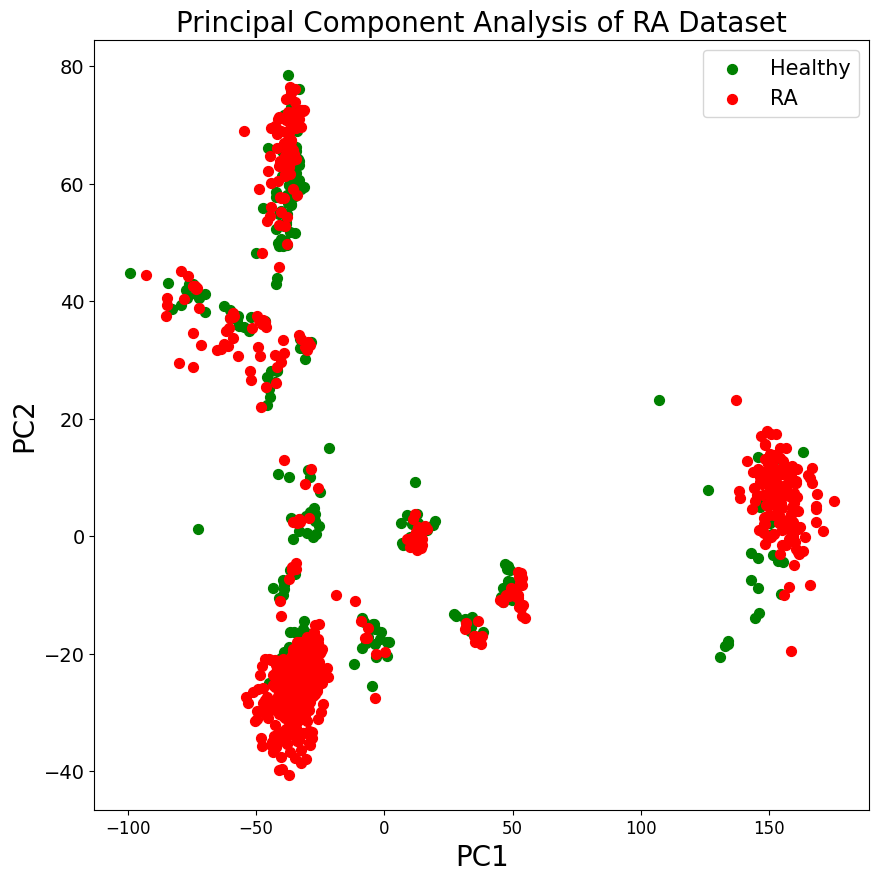

In [17]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('PC1', fontsize=20)
plt.ylabel('PC2', fontsize=20)
plt.title("Principal Component Analysis of RA Dataset", fontsize=20)
targets = ['Healthy', 'RA']
colors = ['g', 'r']
for target, color in zip(targets, colors):
    index = ra_dataset.to_pandas()['Condition'] == target
    plt.scatter(
        ra_pca_pandas.loc[index, 'PC1'], 
        ra_pca_pandas.loc[index, 'PC2'], 
        c=color, 
        s=50
    )

plt.legend(targets, prop={'size': 15})

# PCA per Condition

INFO : --- Running PCA for 'RA'---
INFO : Loaded dataset for PCA with shape: Samples(1122), Genes(10453)
INFO : Dataset normalised | Mean: '2.76347933614501e-18' Standard Deviation:'1.0'
INFO : Explained variation per principal component: [0.49981769 0.10236722]
INFO : ----------------------------------------------
INFO : --- Running PCA for 'T1D'---
INFO : Loaded dataset for PCA with shape: Samples(176), Genes(7711)
INFO : Dataset normalised | Mean: '1.2510993265873388e-17' Standard Deviation:'1.0'
INFO : Explained variation per principal component: [0.43202088 0.2343705 ]
INFO : ----------------------------------------------
INFO : --- Running PCA for 'SSc'---
INFO : Loaded dataset for PCA with shape: Samples(229), Genes(9984)
INFO : Dataset normalised | Mean: '-2.1711991878478496e-17' Standard Deviation:'0.9999999999999994'
INFO : Explained variation per principal component: [0.45925356 0.16098887]
INFO : ----------------------------------------------
INFO : --- Running PCA for 'SLE

<Figure size 640x480 with 0 Axes>

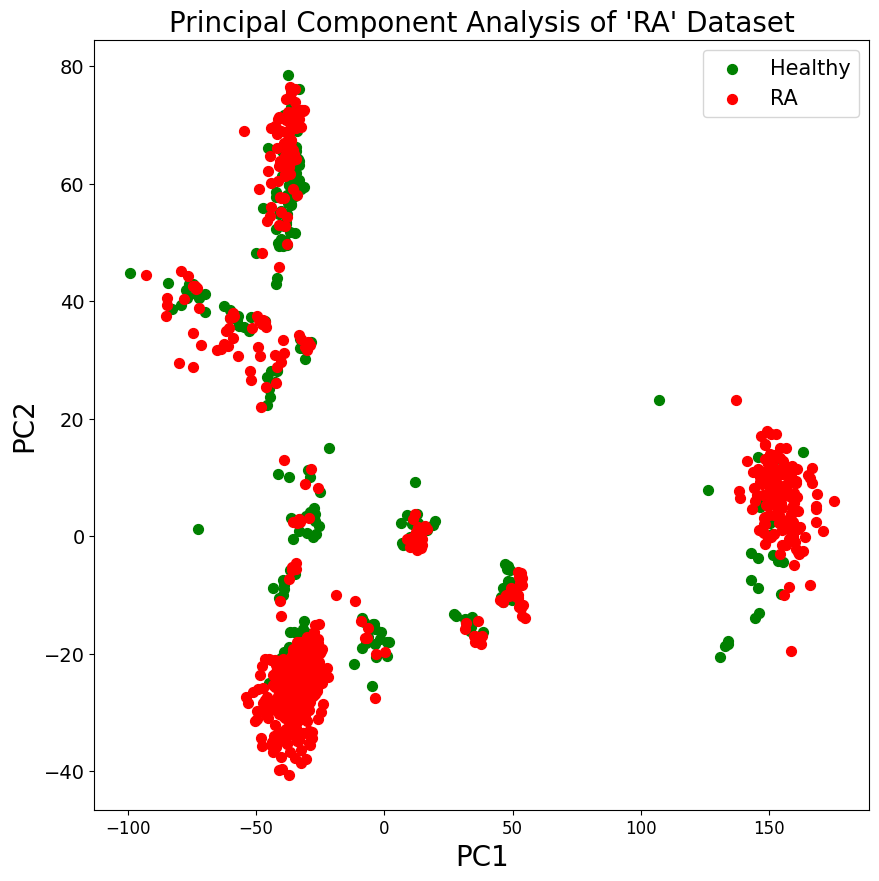

<Figure size 640x480 with 0 Axes>

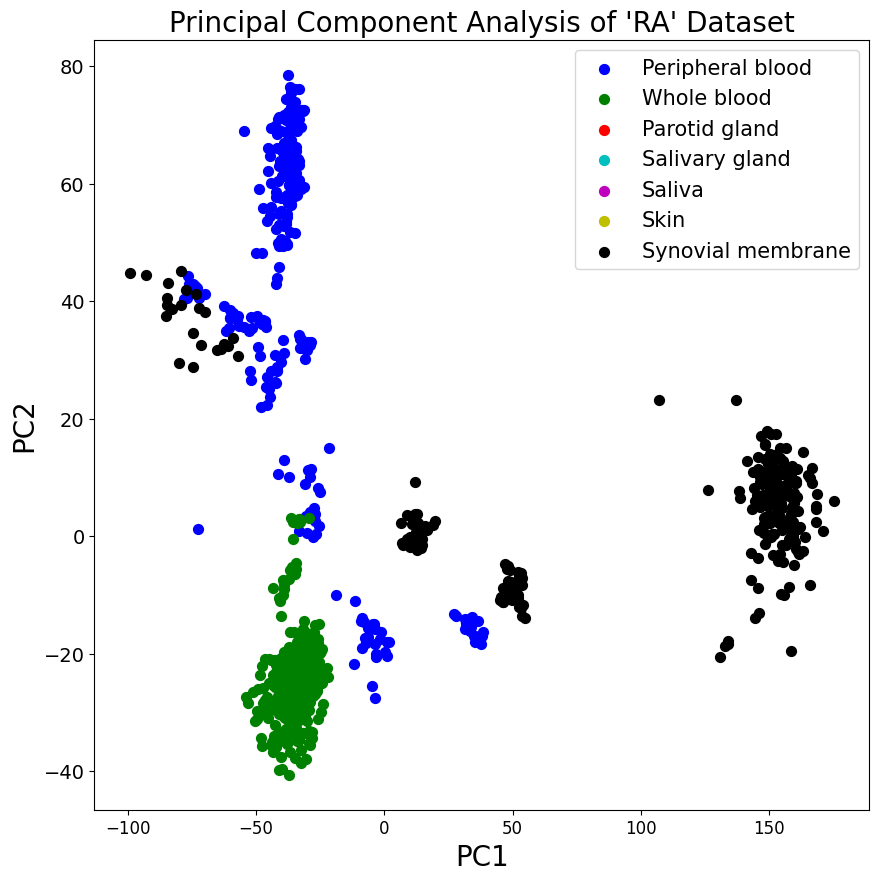

<Figure size 640x480 with 0 Axes>

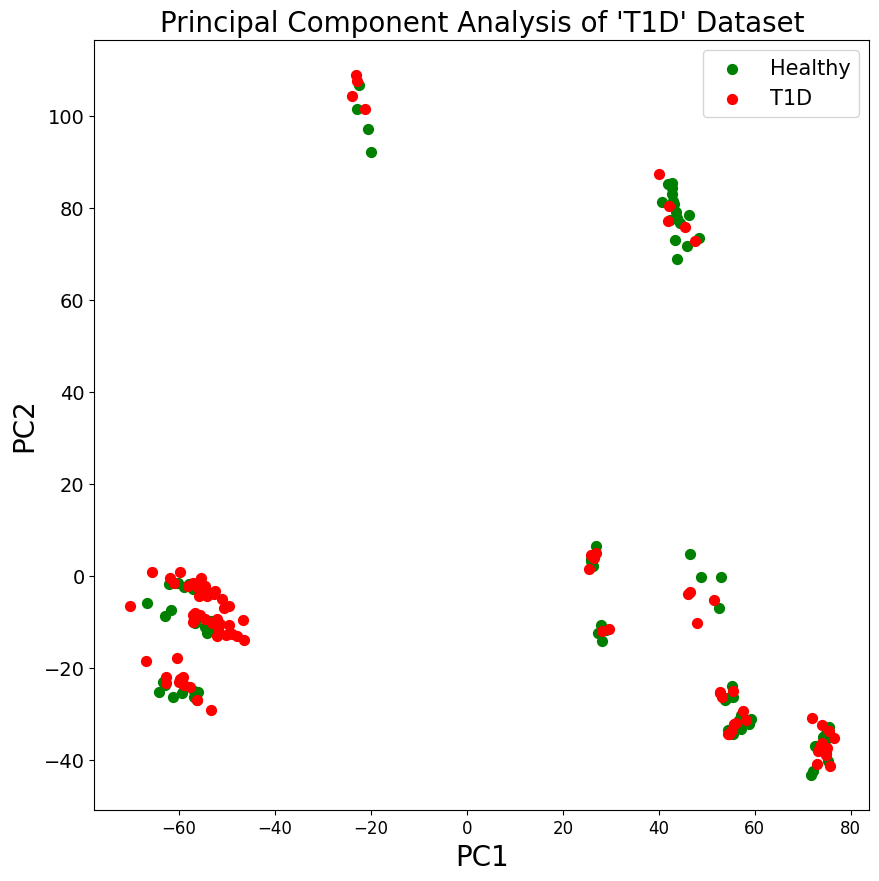

<Figure size 640x480 with 0 Axes>

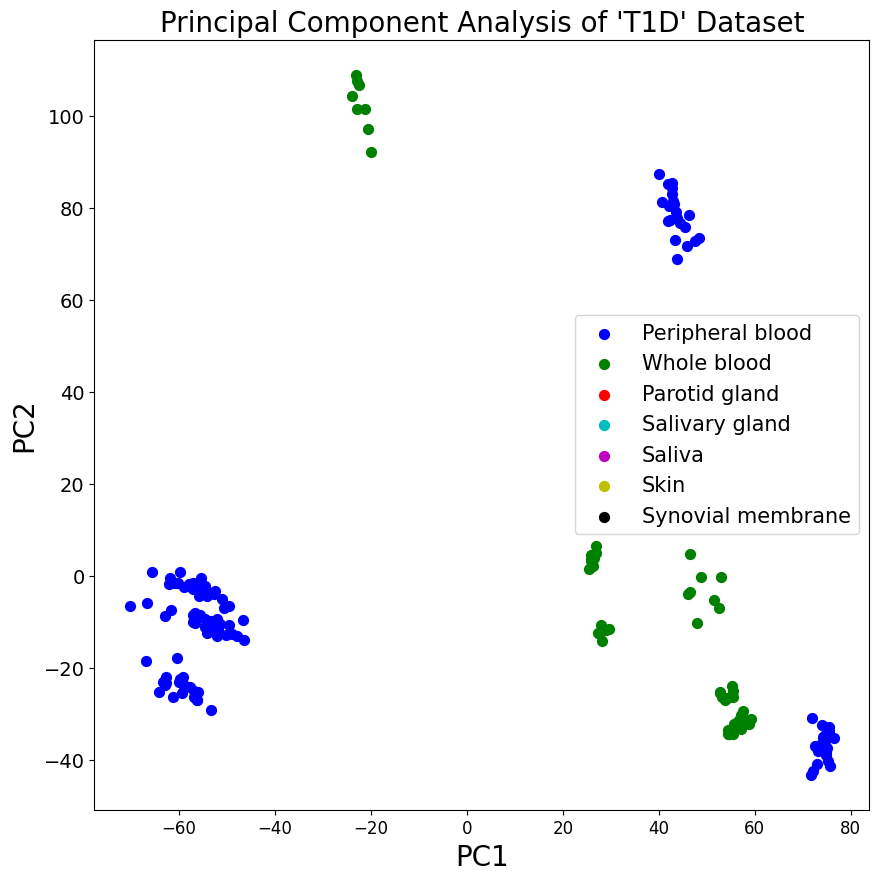

<Figure size 640x480 with 0 Axes>

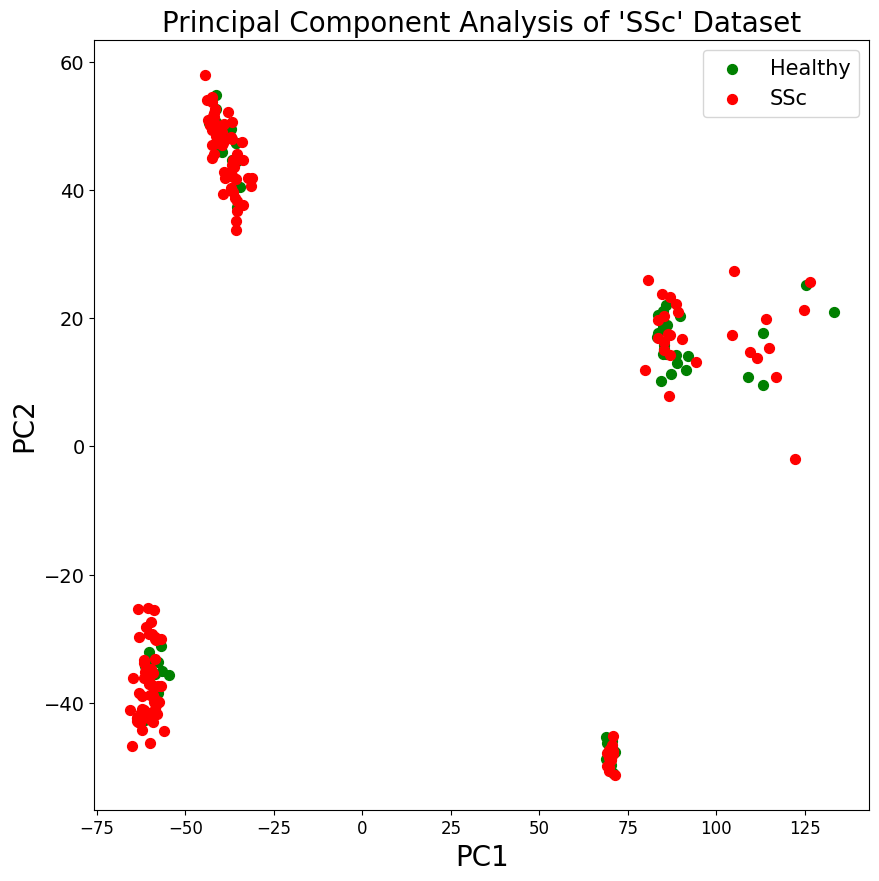

<Figure size 640x480 with 0 Axes>

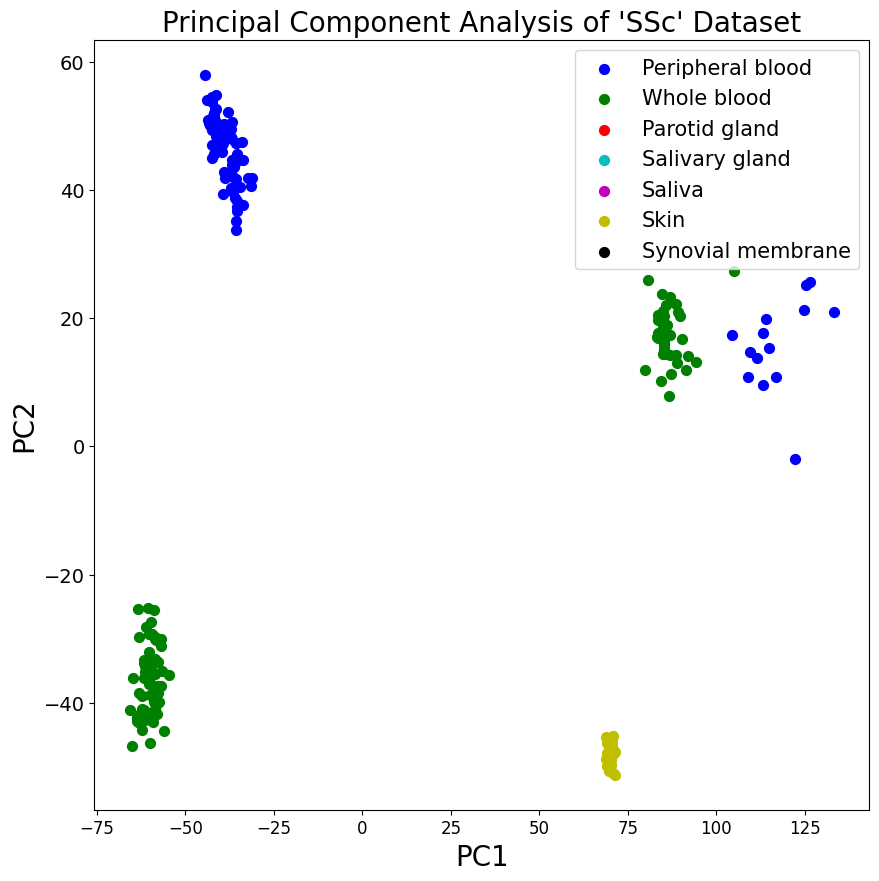

<Figure size 640x480 with 0 Axes>

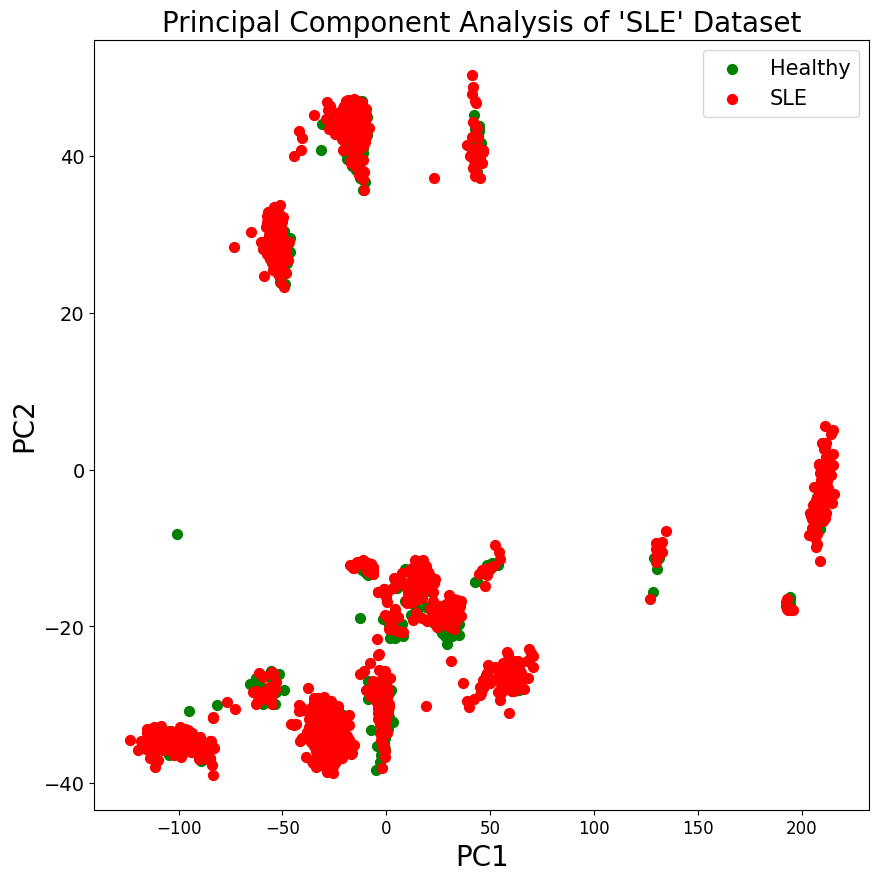

<Figure size 640x480 with 0 Axes>

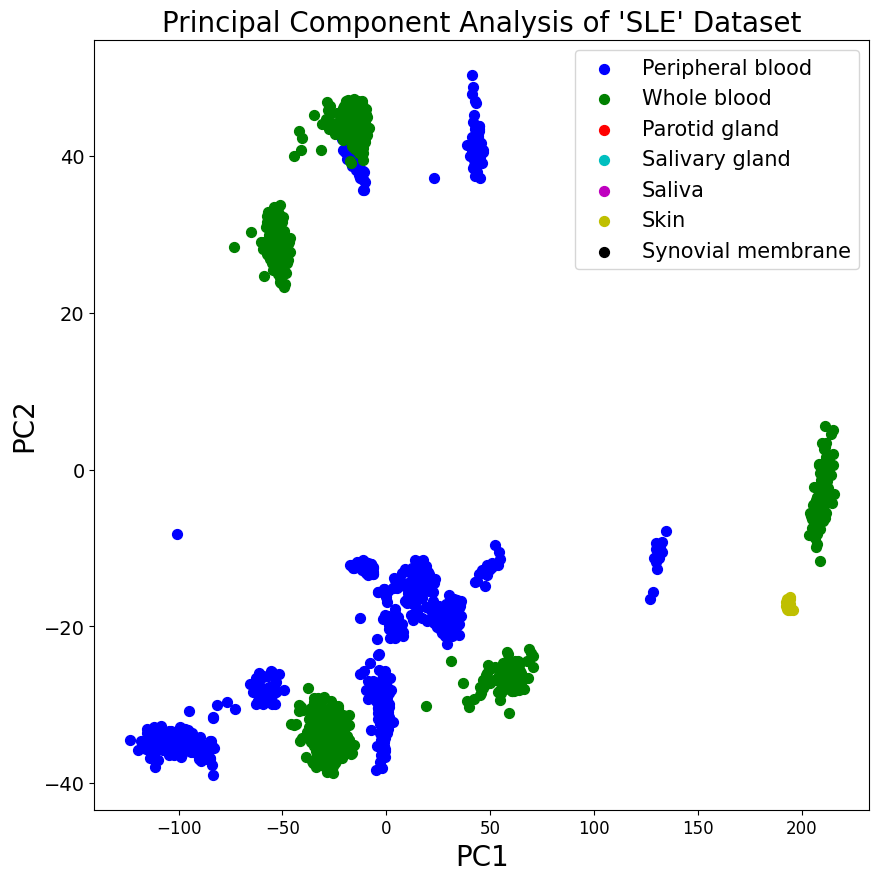

<Figure size 640x480 with 0 Axes>

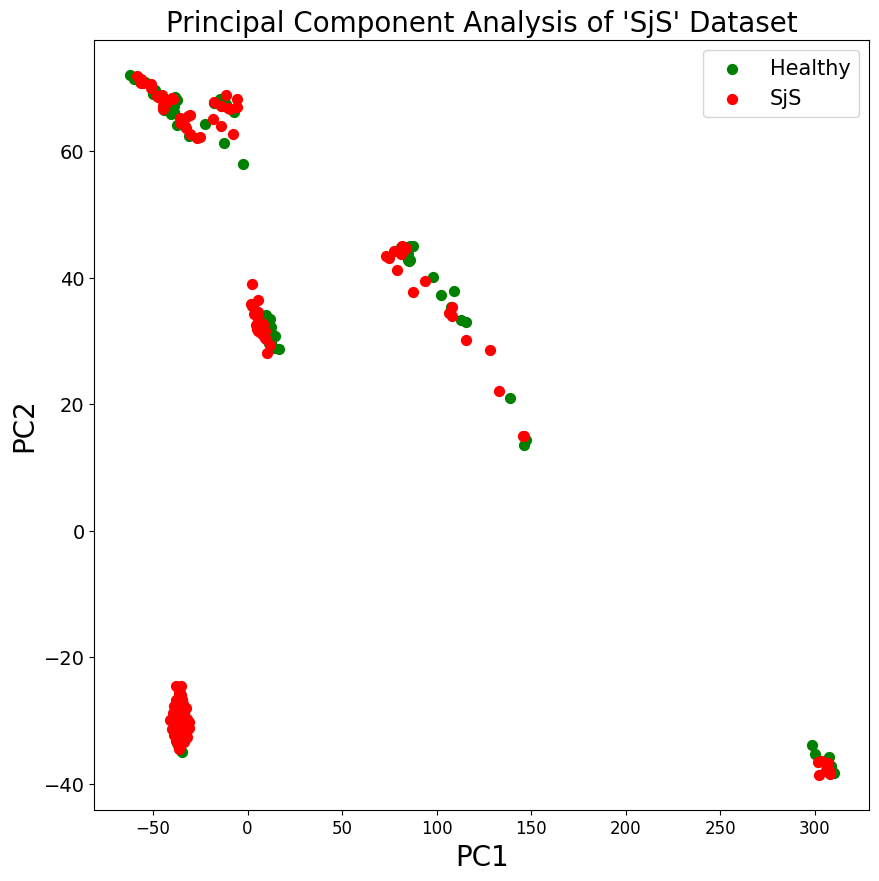

<Figure size 640x480 with 0 Axes>

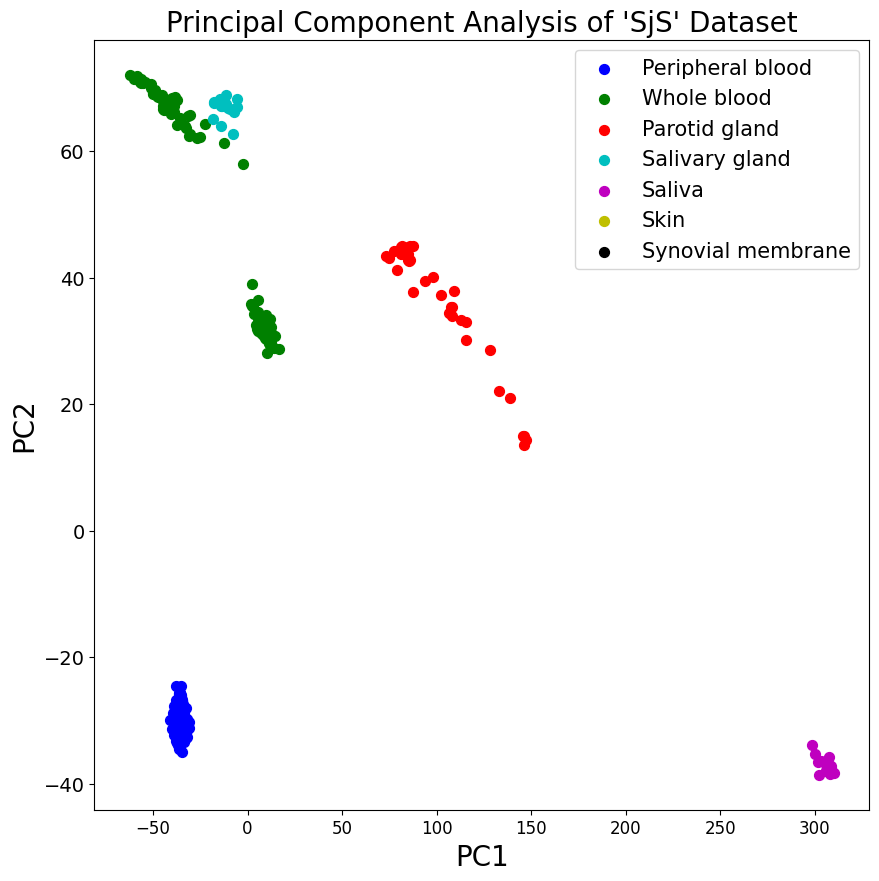

In [18]:
for condition in Condition:
    pca = PcaHelper(ConditionDataLoader(condition), files_path, metadata_path, datasets_info_path)
    pca.draw(
        column_that_defines_colors="Condition",
        target_colors=[
            ("Healthy", "g"),
            (condition.name, "r")
        ]
    )

    pca.draw(
        column_that_defines_colors="Tissue",
        target_colors=TISSUE_COLORS
    )

# PCA per Condition, and Sequencing Technique


INFO : --- Running PCA for 'RA|MICROARRAYS'---
INFO : Loaded dataset for PCA with shape: Samples(918), Genes(10432)
INFO : Dataset normalised | Mean: '1.0240580206474888e-17' Standard Deviation:'1.0000000000000002'
INFO : Explained variation per principal component: [0.23346294 0.19439382]
INFO : ----------------------------------------------
INFO : --- Running PCA for 'T1D|MICROARRAYS'---
INFO : Loaded dataset for PCA with shape: Samples(79), Genes(4988)
INFO : Dataset normalised | Mean: '2.1279253461047858e-17' Standard Deviation:'1.0'
INFO : Explained variation per principal component: [0.49224565 0.29366128]
INFO : ----------------------------------------------
INFO : --- Running PCA for 'SSc|MICROARRAYS'---
INFO : Loaded dataset for PCA with shape: Samples(84), Genes(8734)
INFO : Dataset normalised | Mean: '-9.029904565256763e-19' Standard Deviation:'1.0'
INFO : Explained variation per principal component: [0.48708144 0.18882726]
INFO : --------------------------------------------

<Figure size 640x480 with 0 Axes>

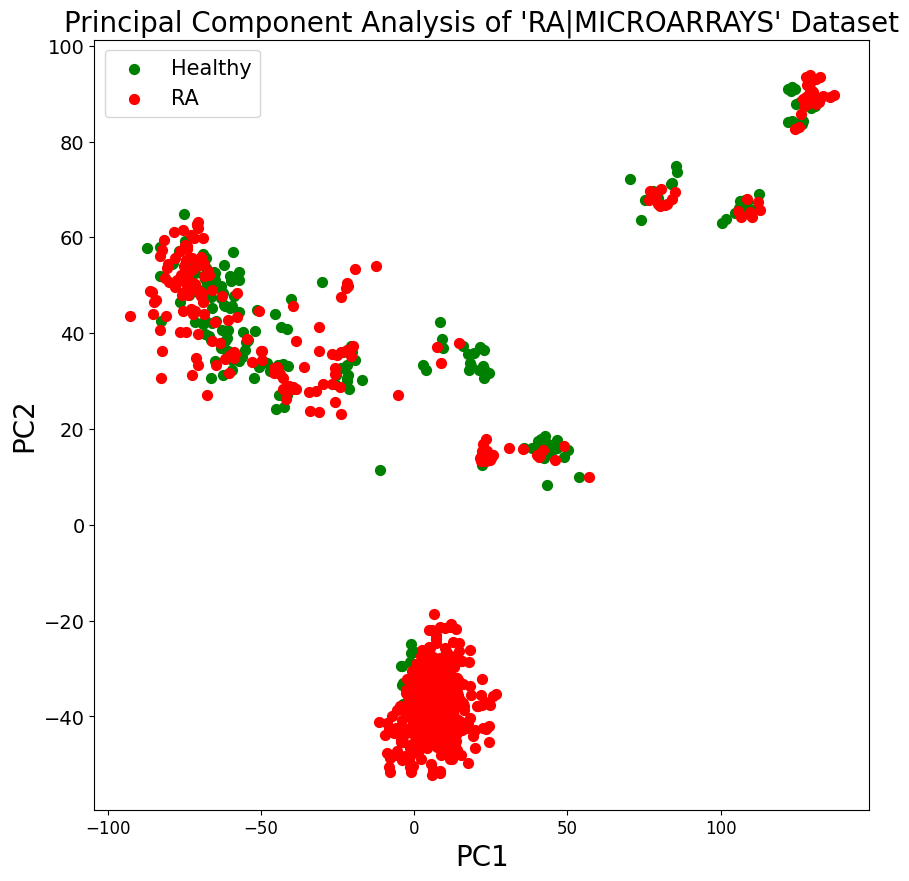

<Figure size 640x480 with 0 Axes>

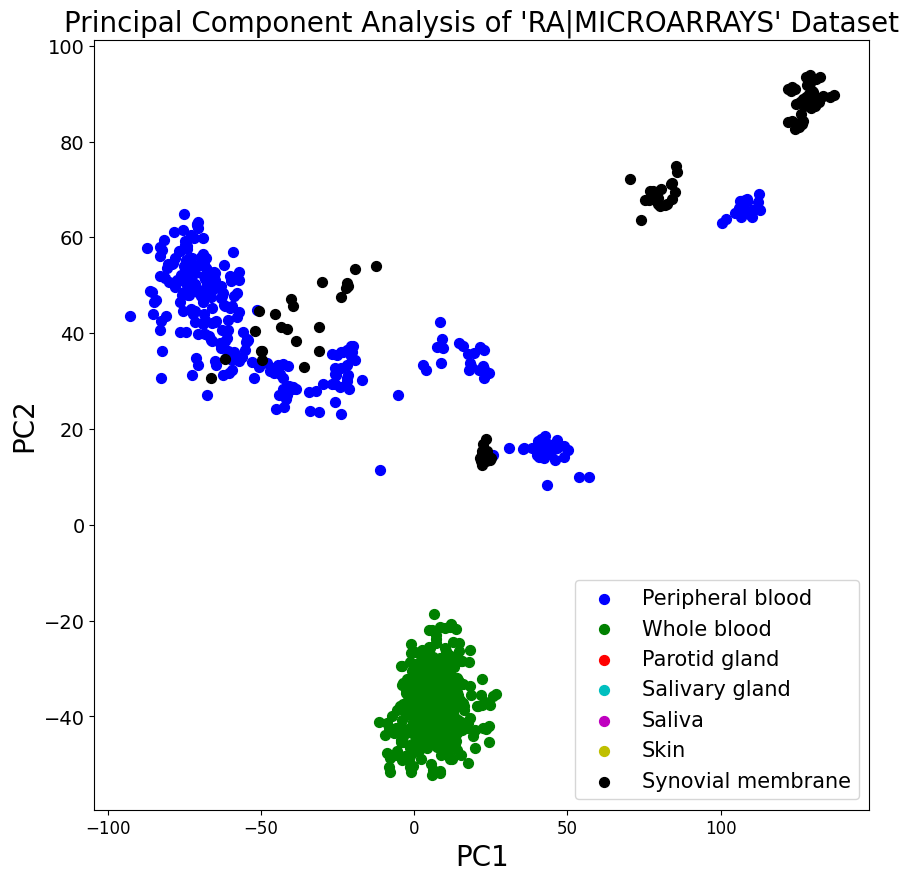

<Figure size 640x480 with 0 Axes>

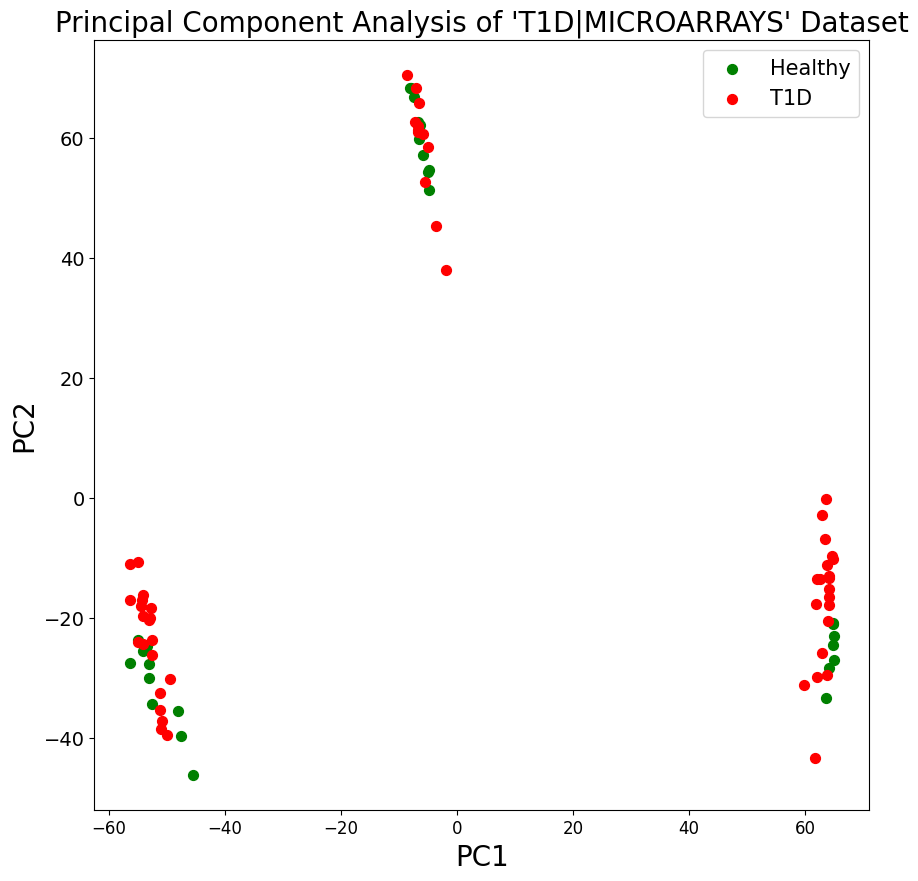

<Figure size 640x480 with 0 Axes>

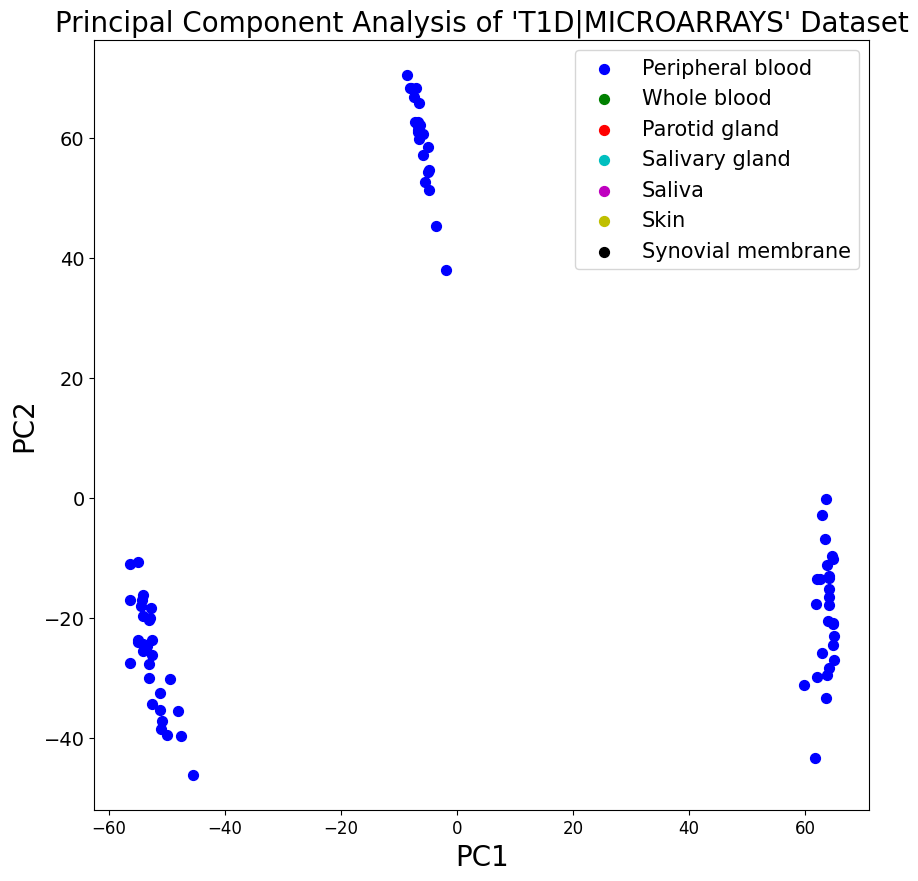

<Figure size 640x480 with 0 Axes>

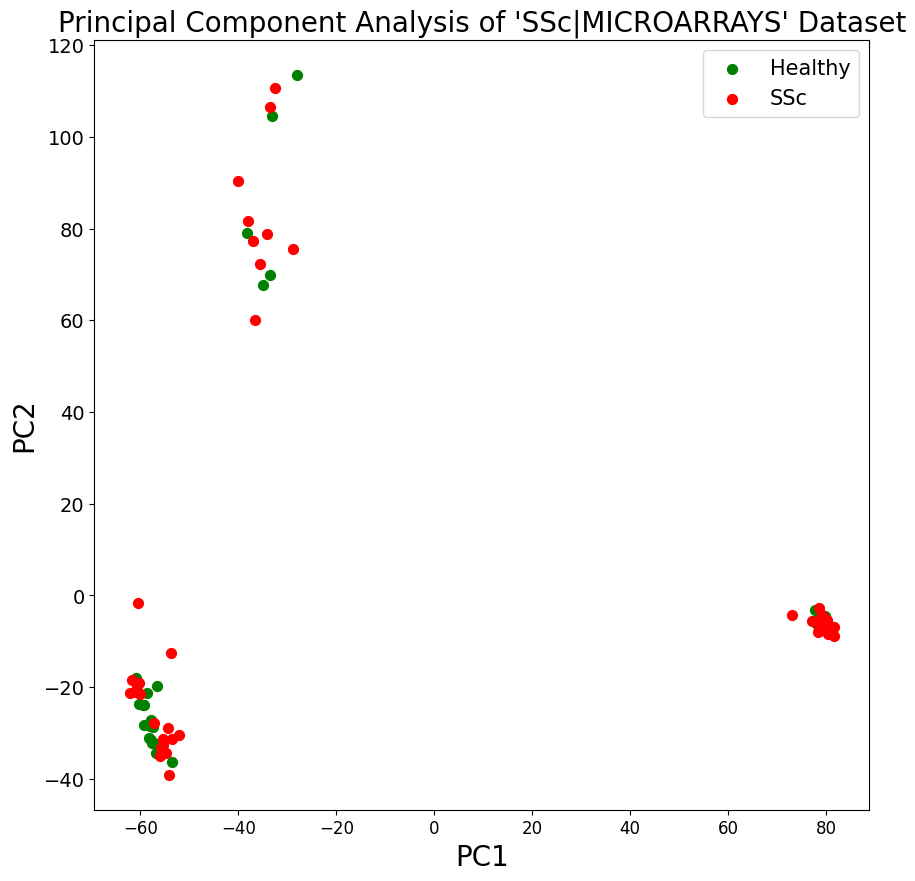

<Figure size 640x480 with 0 Axes>

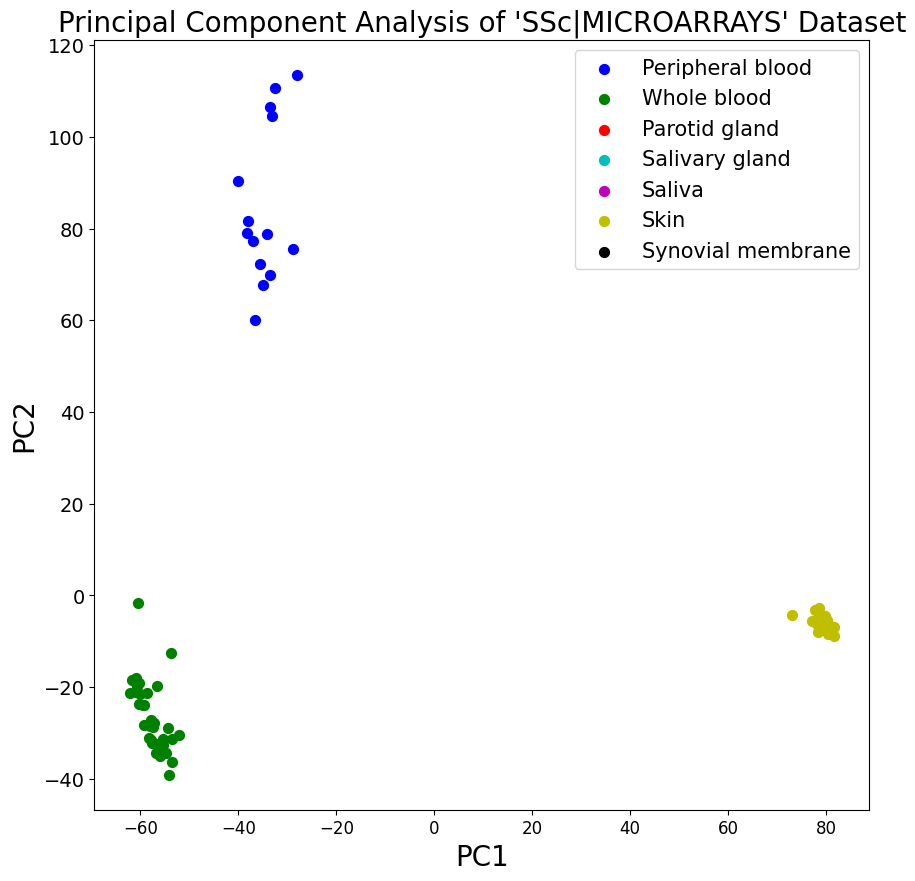

<Figure size 640x480 with 0 Axes>

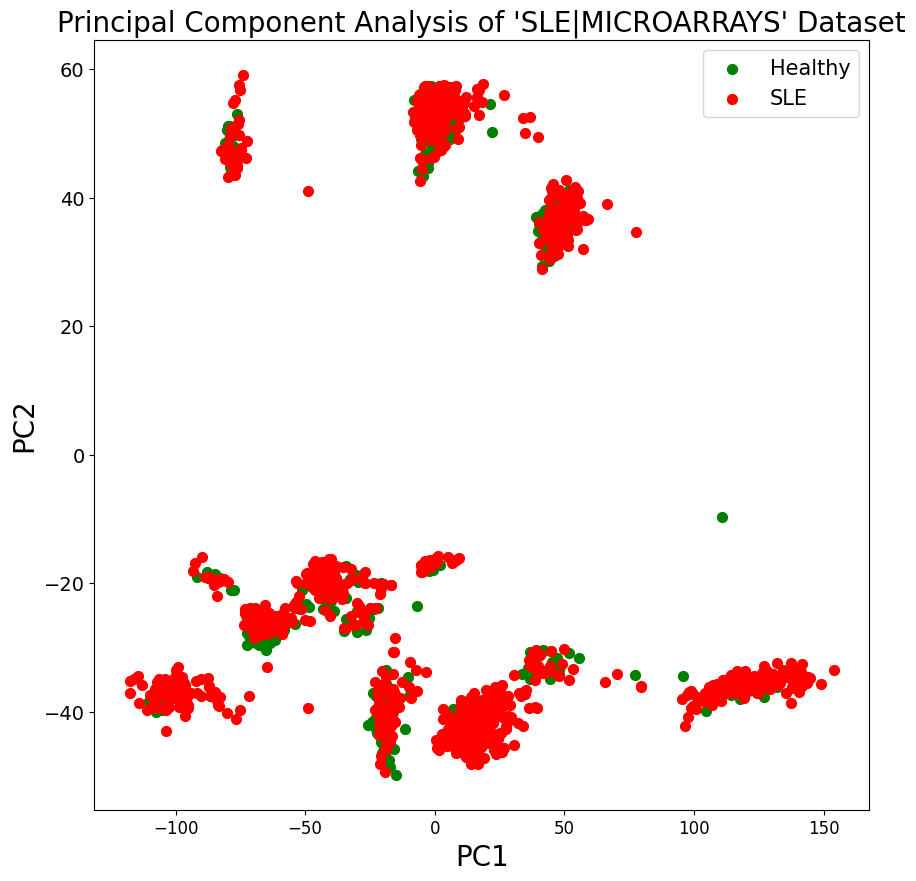

<Figure size 640x480 with 0 Axes>

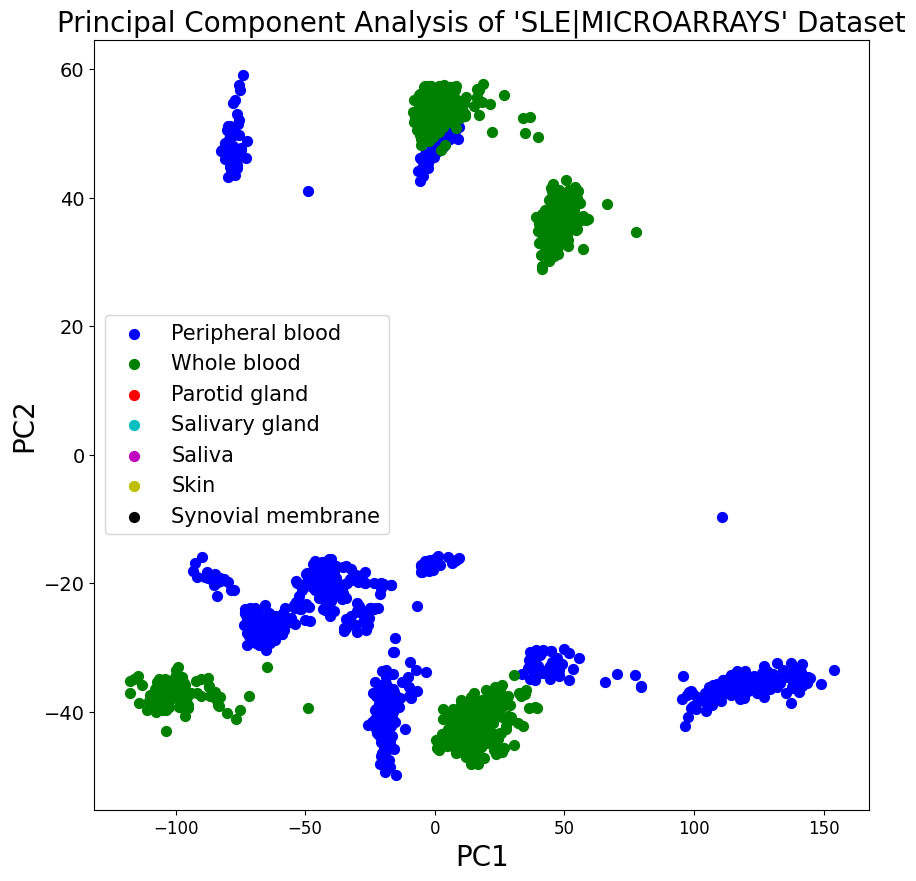

<Figure size 640x480 with 0 Axes>

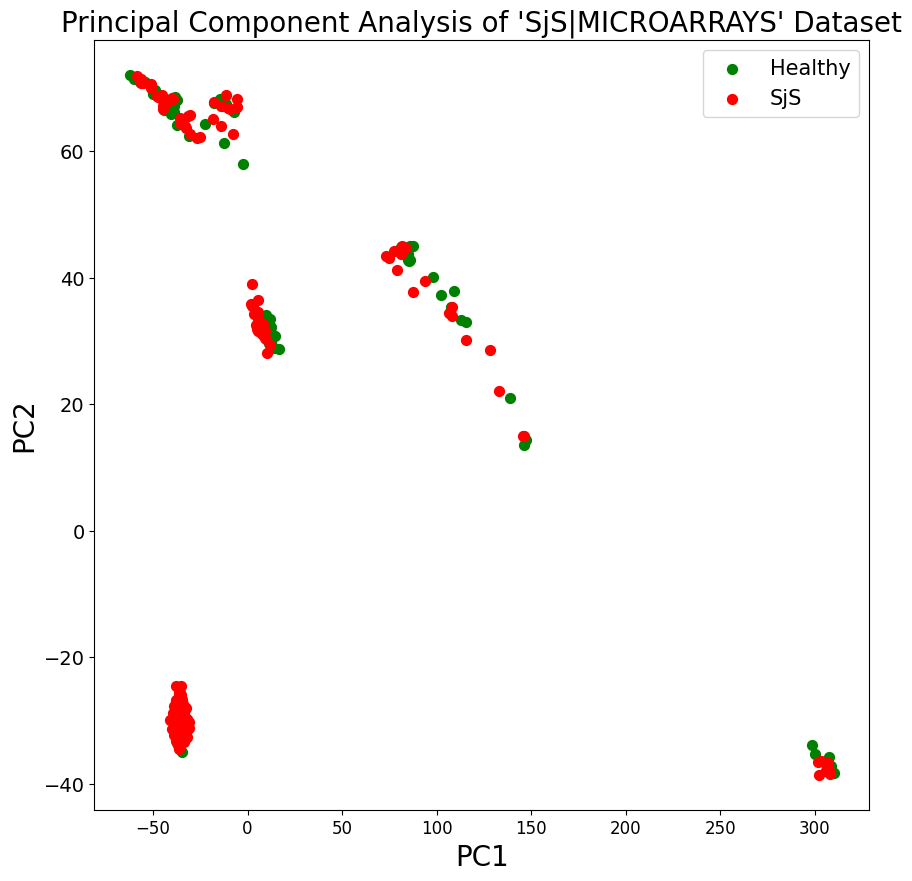

<Figure size 640x480 with 0 Axes>

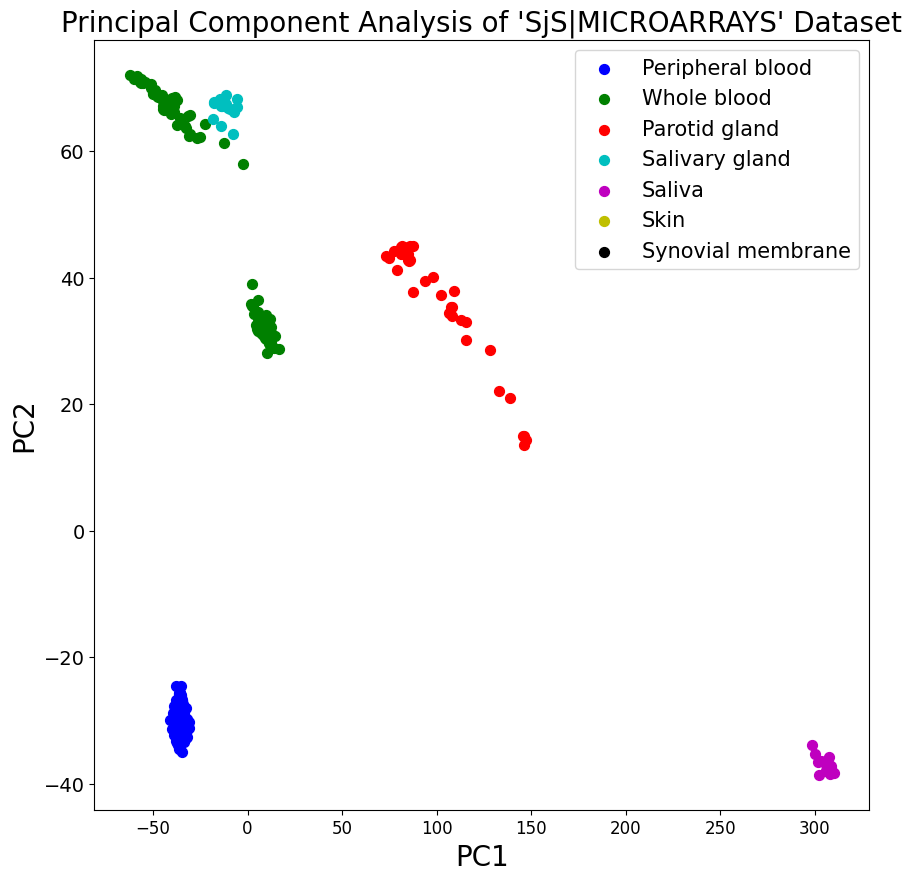

<Figure size 640x480 with 0 Axes>

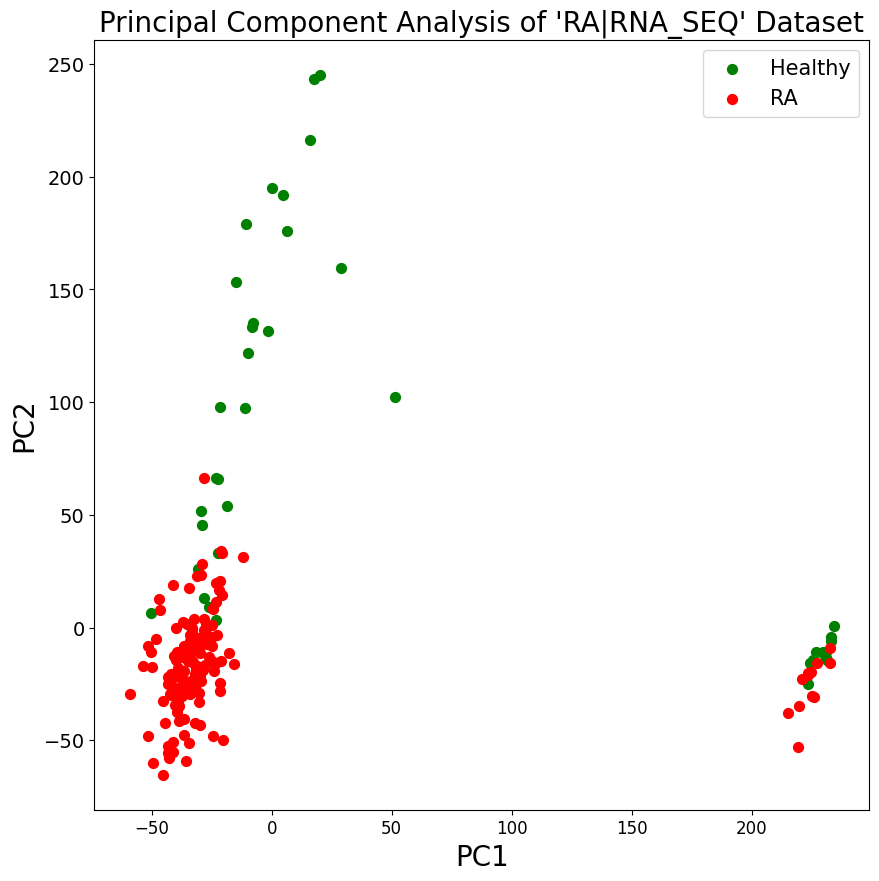

<Figure size 640x480 with 0 Axes>

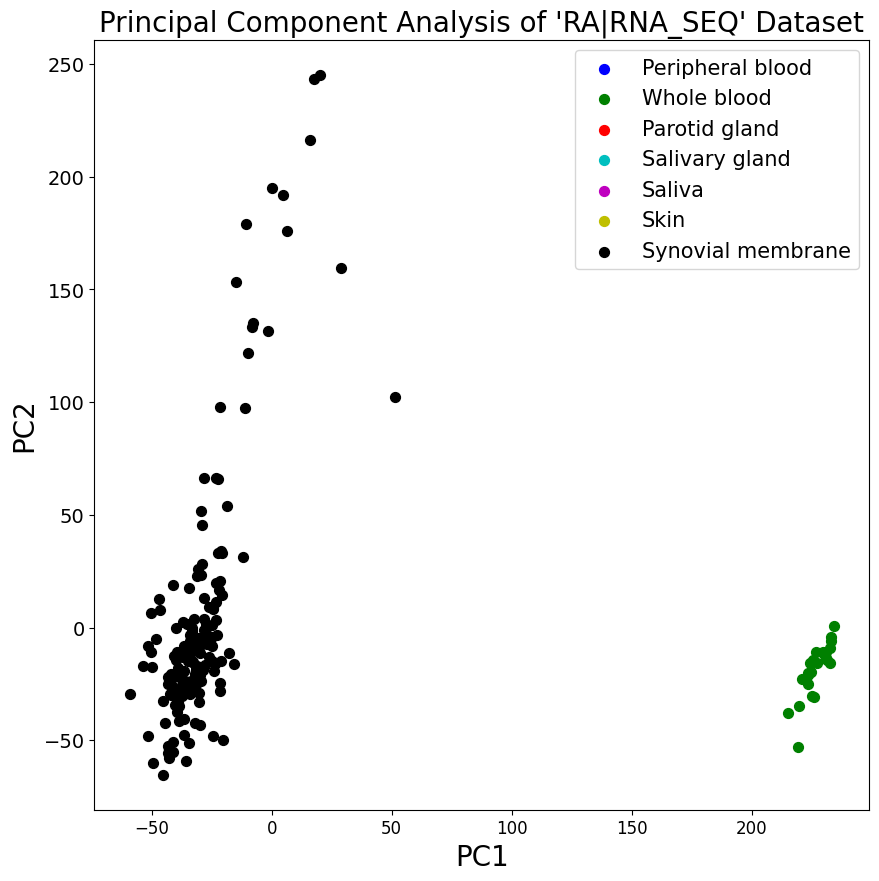

<Figure size 640x480 with 0 Axes>

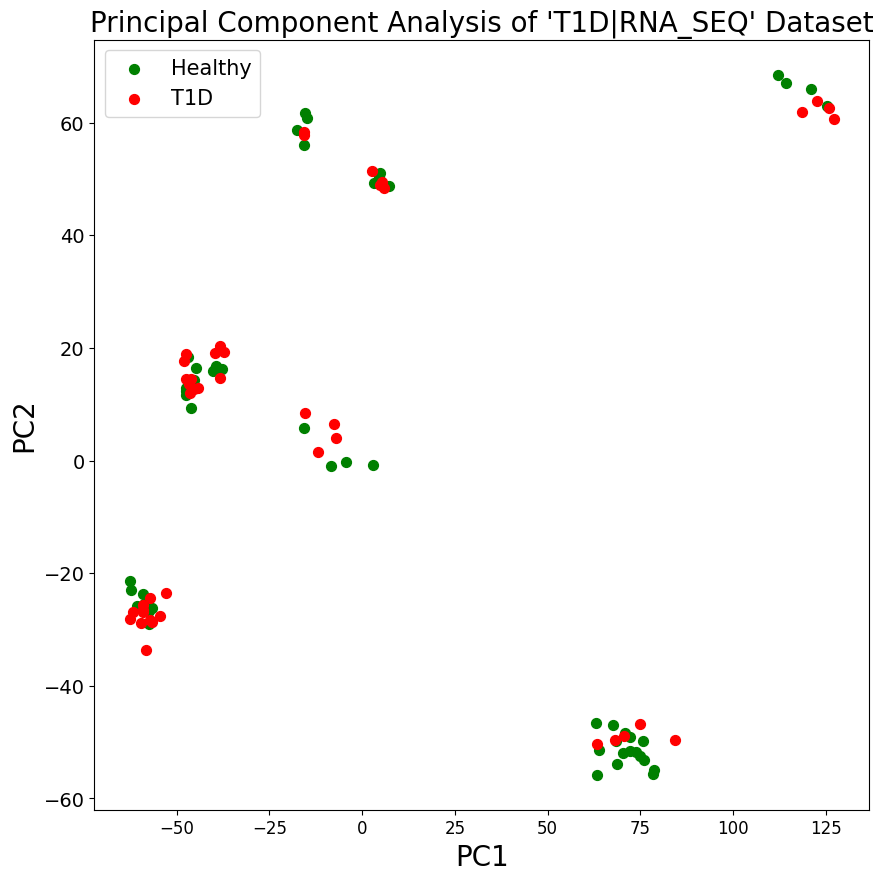

<Figure size 640x480 with 0 Axes>

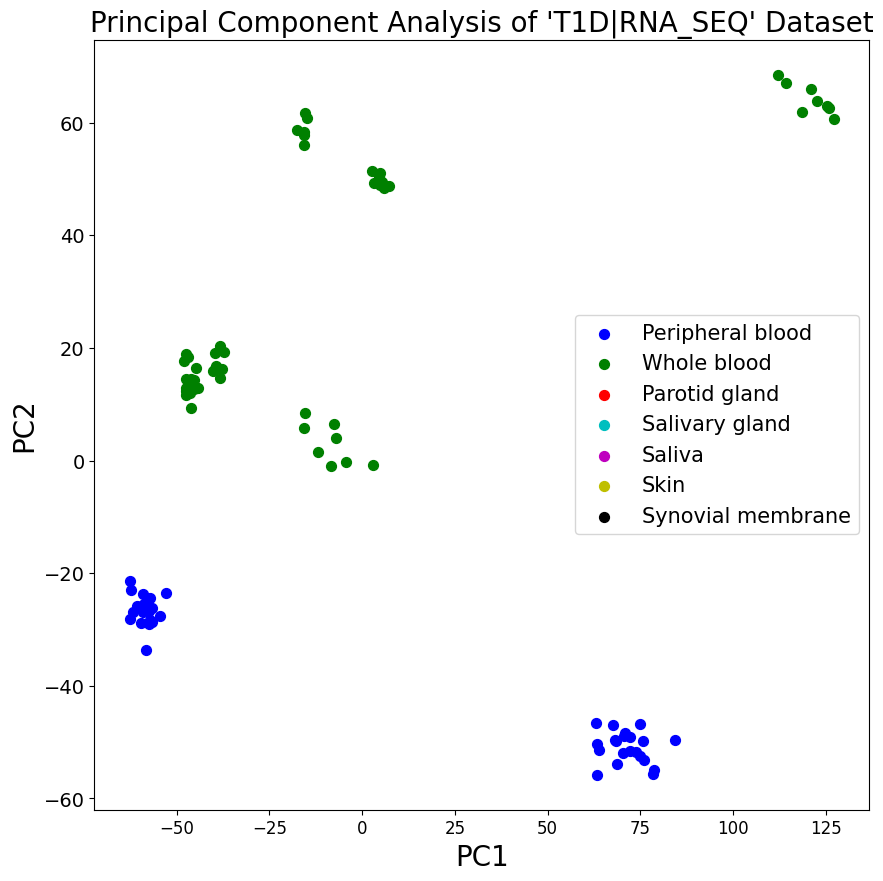

<Figure size 640x480 with 0 Axes>

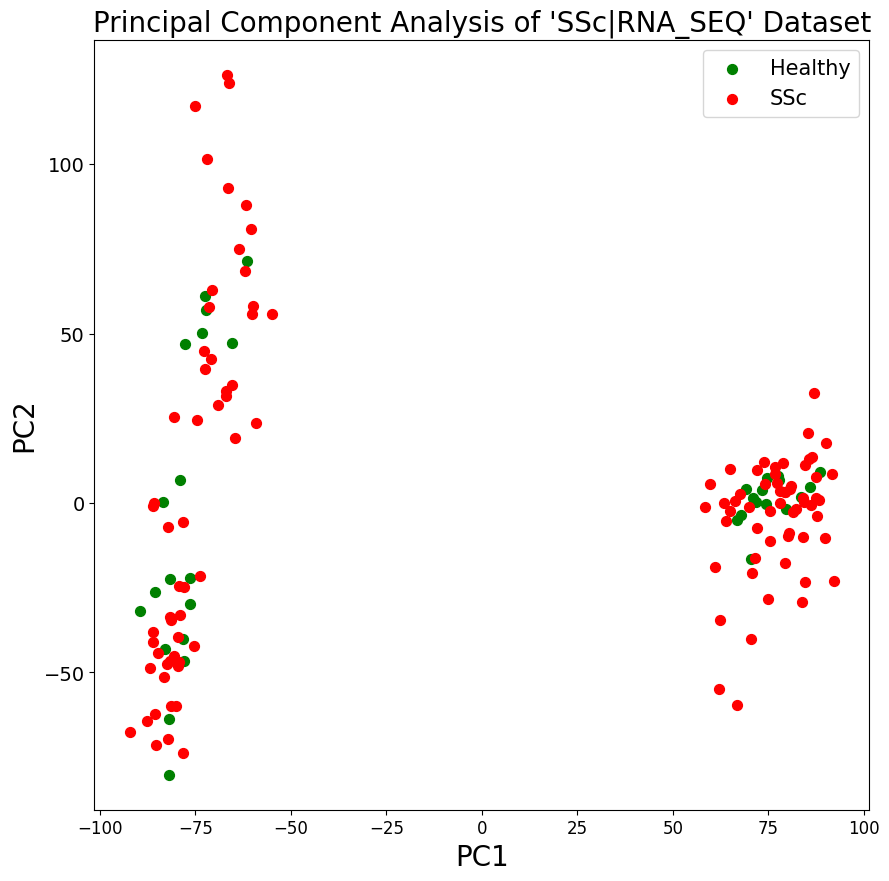

<Figure size 640x480 with 0 Axes>

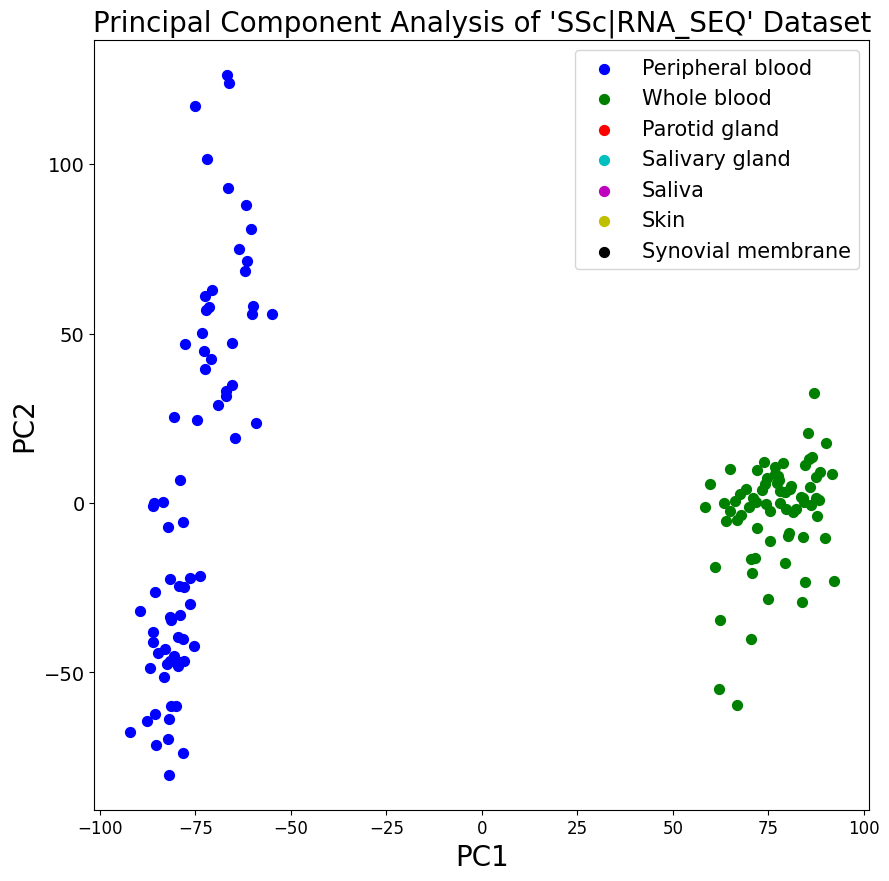

<Figure size 640x480 with 0 Axes>

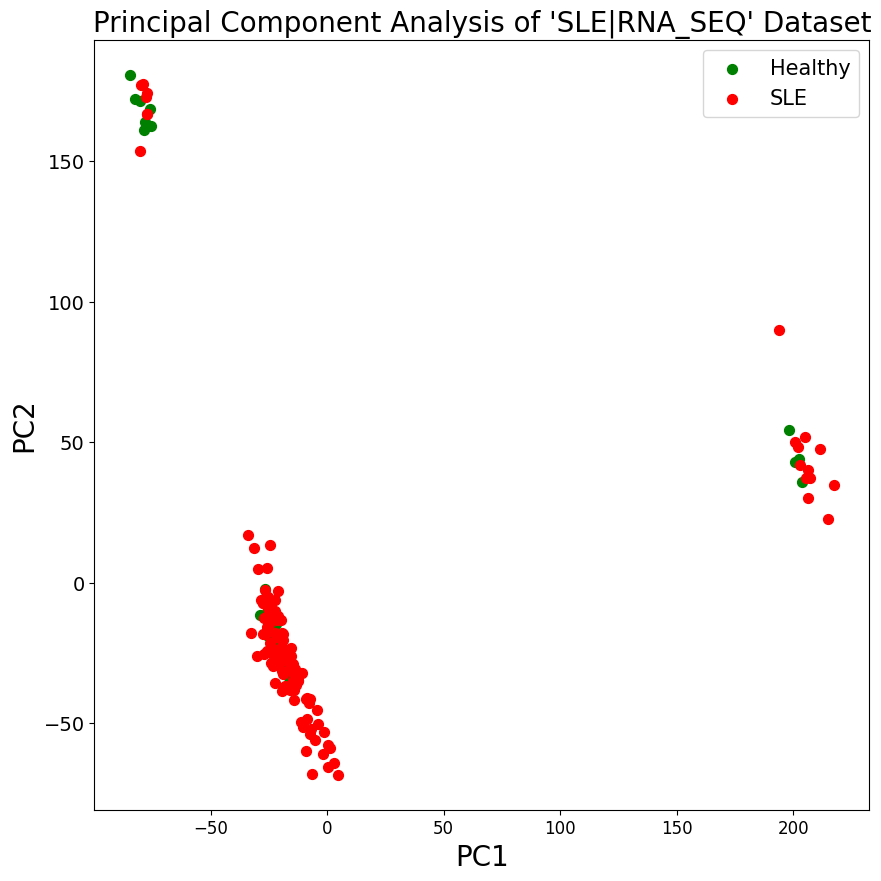

<Figure size 640x480 with 0 Axes>

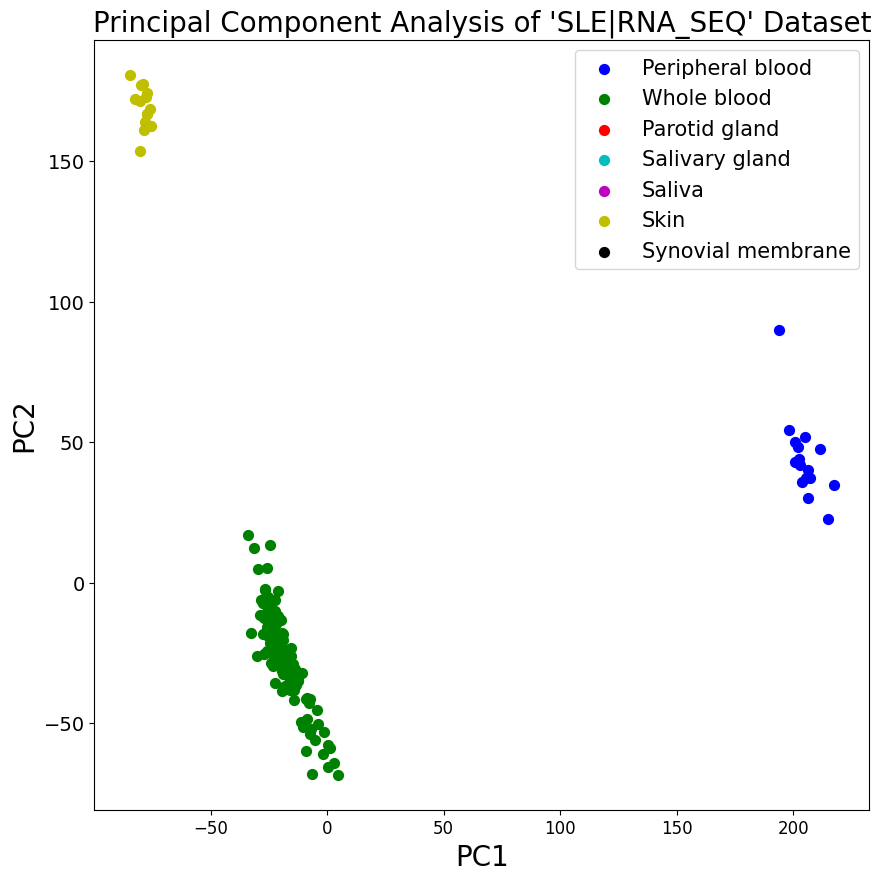

In [19]:
for sequencing_technique in SequencingTechnique:
    for condition in Condition:
        pca = PcaHelper(ConditionSequencingDataLoader(condition, sequencing_technique), files_path, metadata_path, datasets_info_path)
        pca.draw(
            column_that_defines_colors="Condition",
            target_colors=[
                ("Healthy", "g"),
                (condition.name, "r")
            ]
        )
    
        pca.draw(
            column_that_defines_colors="Tissue",
            target_colors=TISSUE_COLORS
        )

# PCA per Condition, Sequencing Technique, and Tissue

INFO : --- Running PCA for 'RA|MICROARRAYS|PERIPHERAL_BLOOD'---
INFO : Loaded dataset for PCA with shape: Samples(302), Genes(9677)
INFO : Dataset normalised | Mean: '8.250463050343778e-19' Standard Deviation:'1.0000000000000002'
INFO : Explained variation per principal component: [0.31531245 0.22344761]
INFO : ----------------------------------------------
INFO : --- Running PCA for 'RA|MICROARRAYS|WHOLE_BLOOD'---
INFO : Loaded dataset for PCA with shape: Samples(513), Genes(13784)
INFO : Dataset normalised | Mean: '2.981430164410273e-17' Standard Deviation:'1.0000000000000007'
INFO : Explained variation per principal component: [0.1748401  0.10488159]
INFO : ----------------------------------------------
INFO : --- Not running PCA for data_loader 'ConditionSequencingTissueDataLoader(condition=<Condition.RA: 'Rheumatoid Arthritis'>, sequencing_technique=<SequencingTechnique.MICROARRAYS: 'Expression profiling by array'>, tissue=<TissueEnum.PAROTIC_GLAND: 'Parotid gland'>)' because ther

<Figure size 640x480 with 0 Axes>

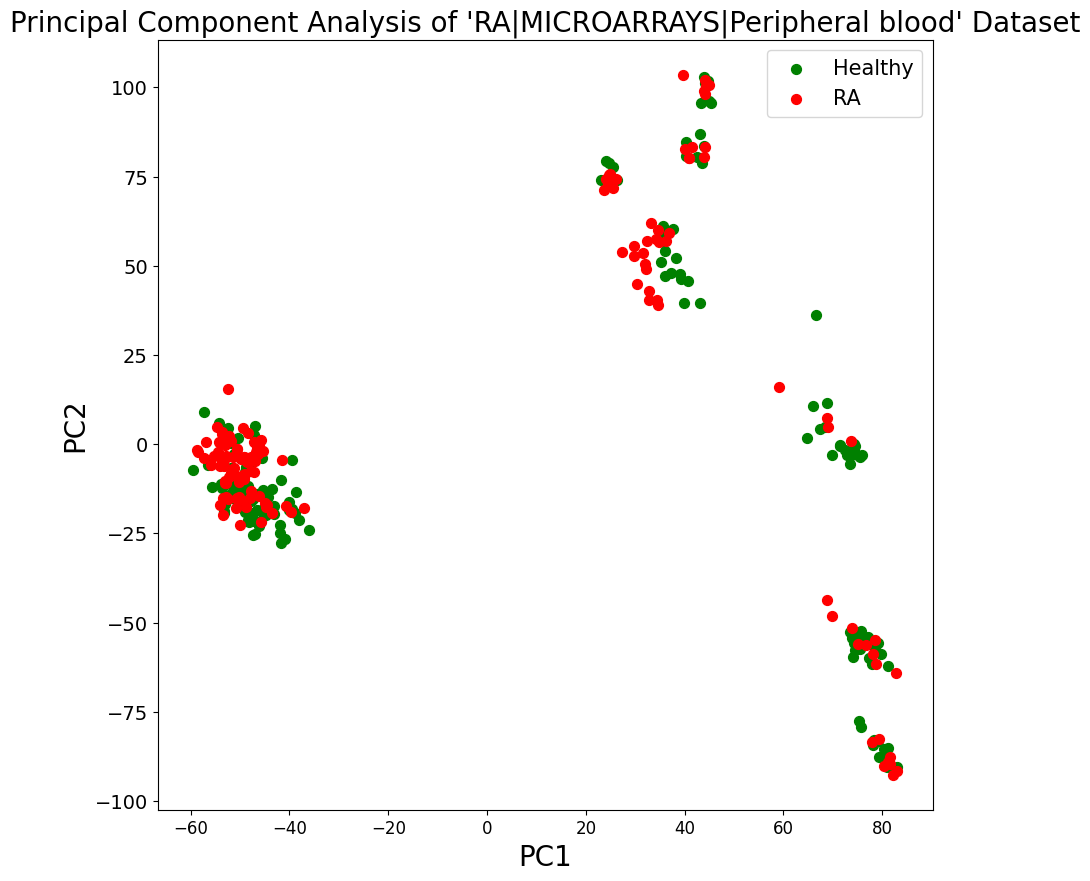

<Figure size 640x480 with 0 Axes>

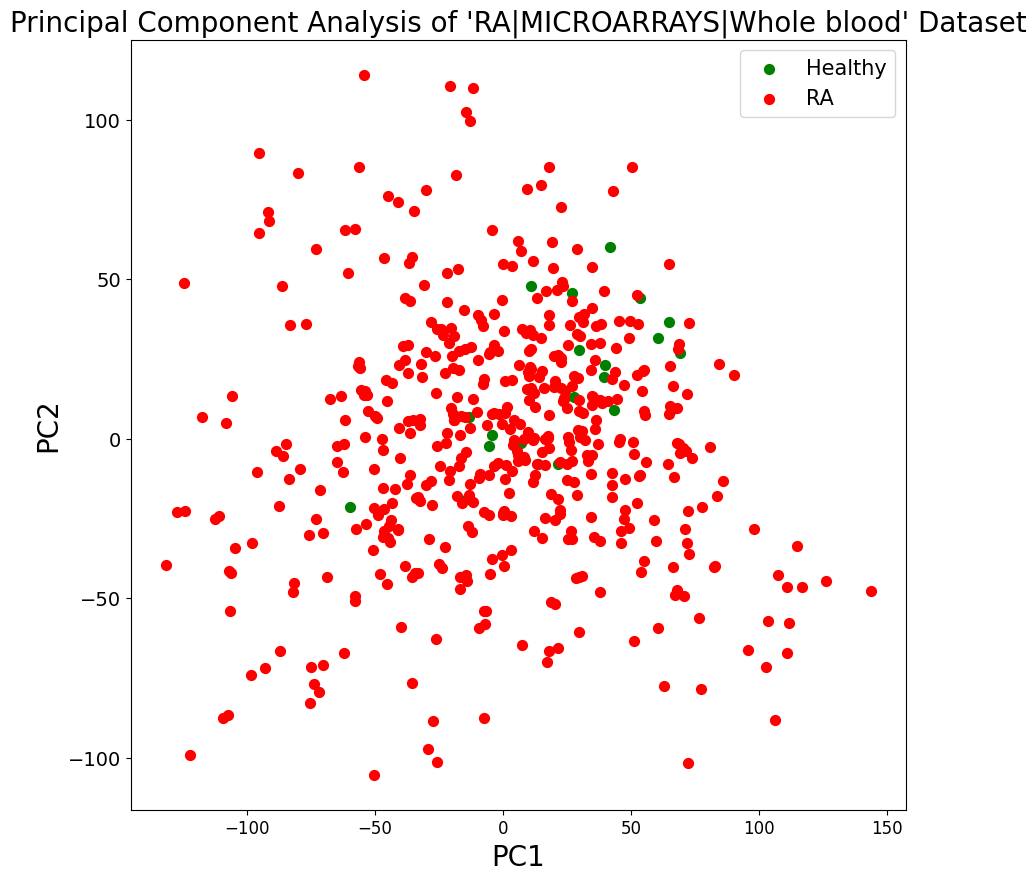

<Figure size 640x480 with 0 Axes>

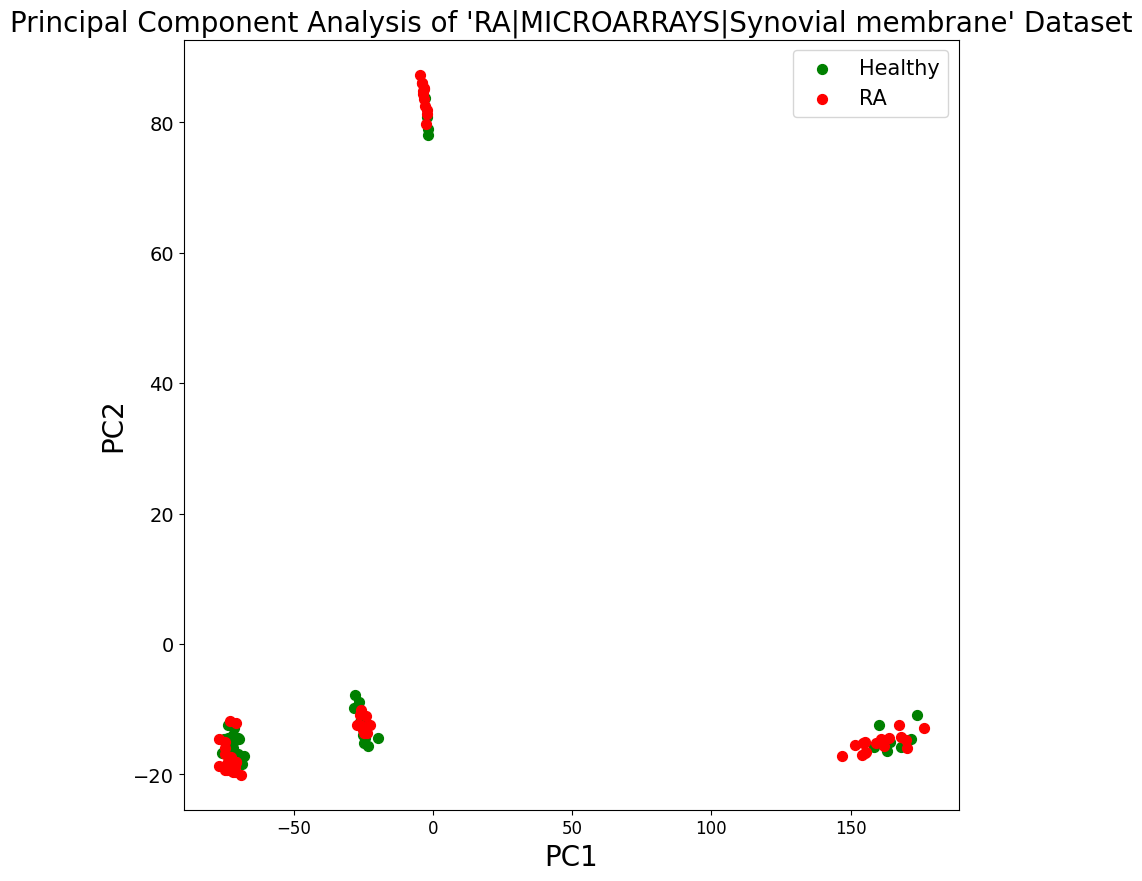

<Figure size 640x480 with 0 Axes>

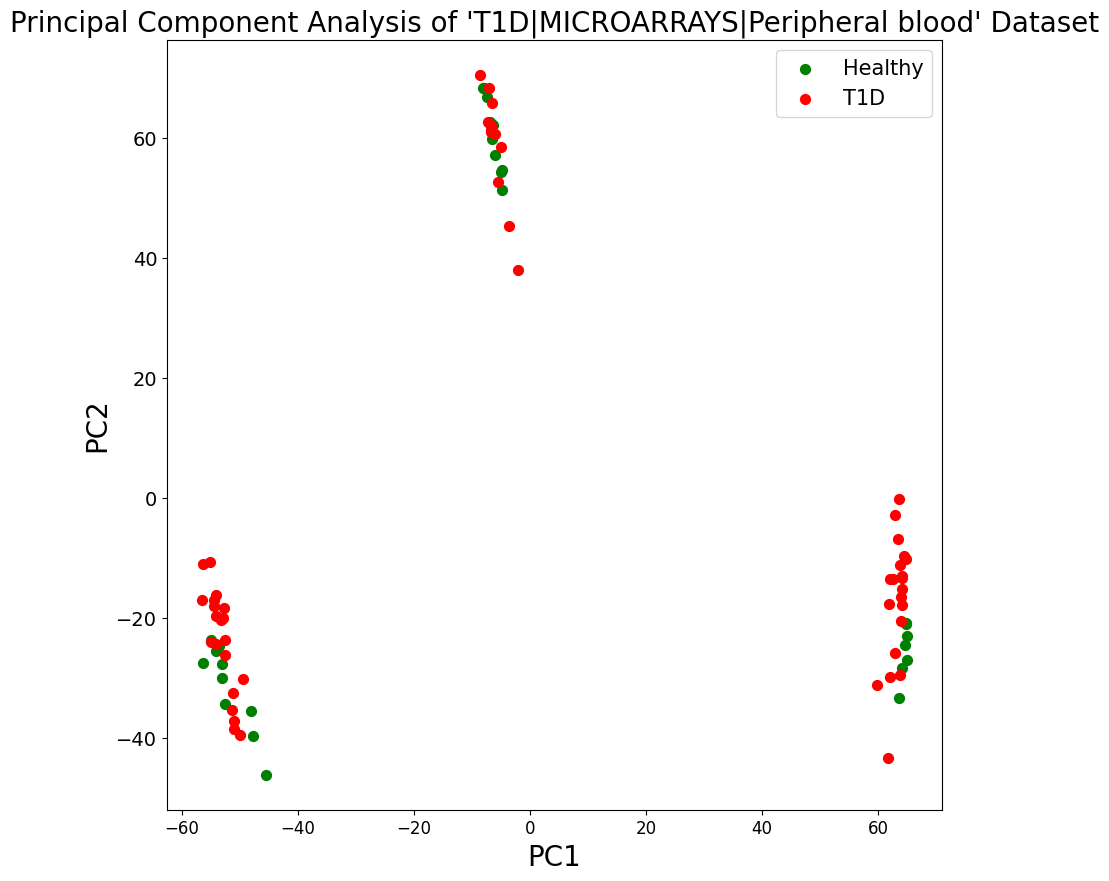

<Figure size 640x480 with 0 Axes>

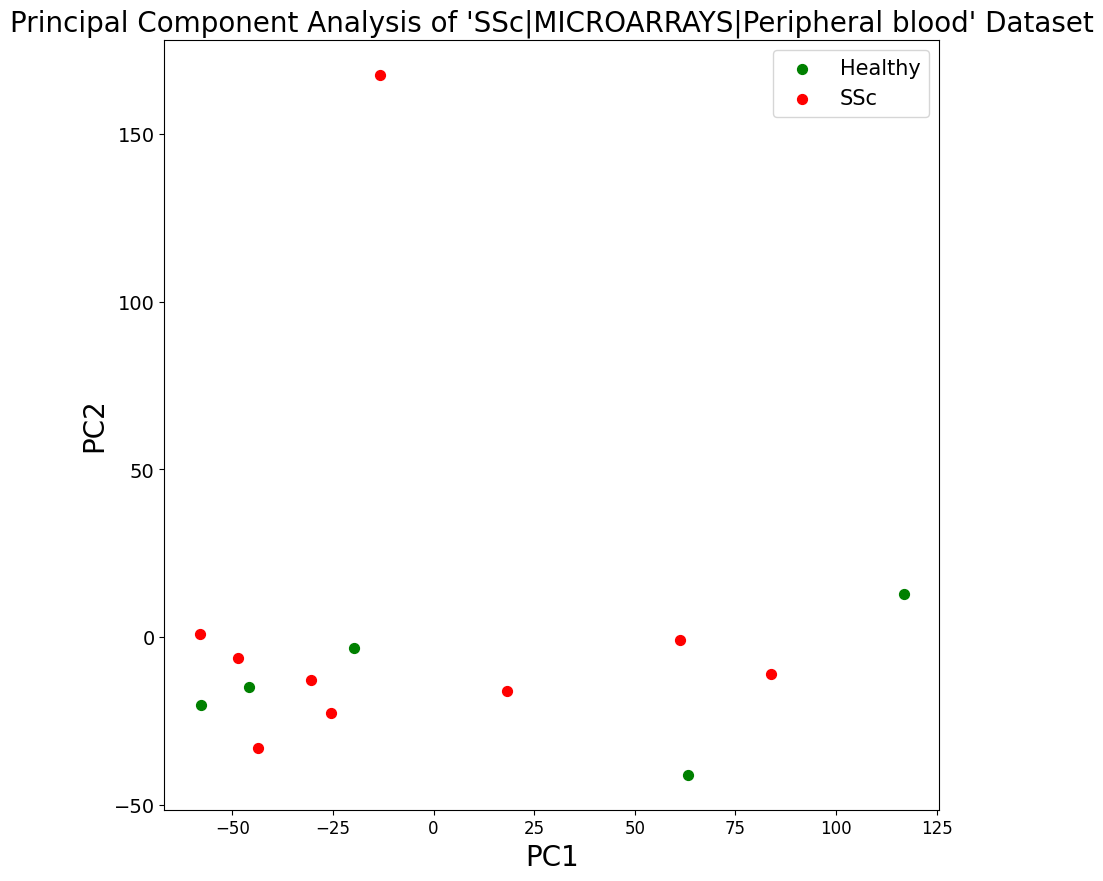

<Figure size 640x480 with 0 Axes>

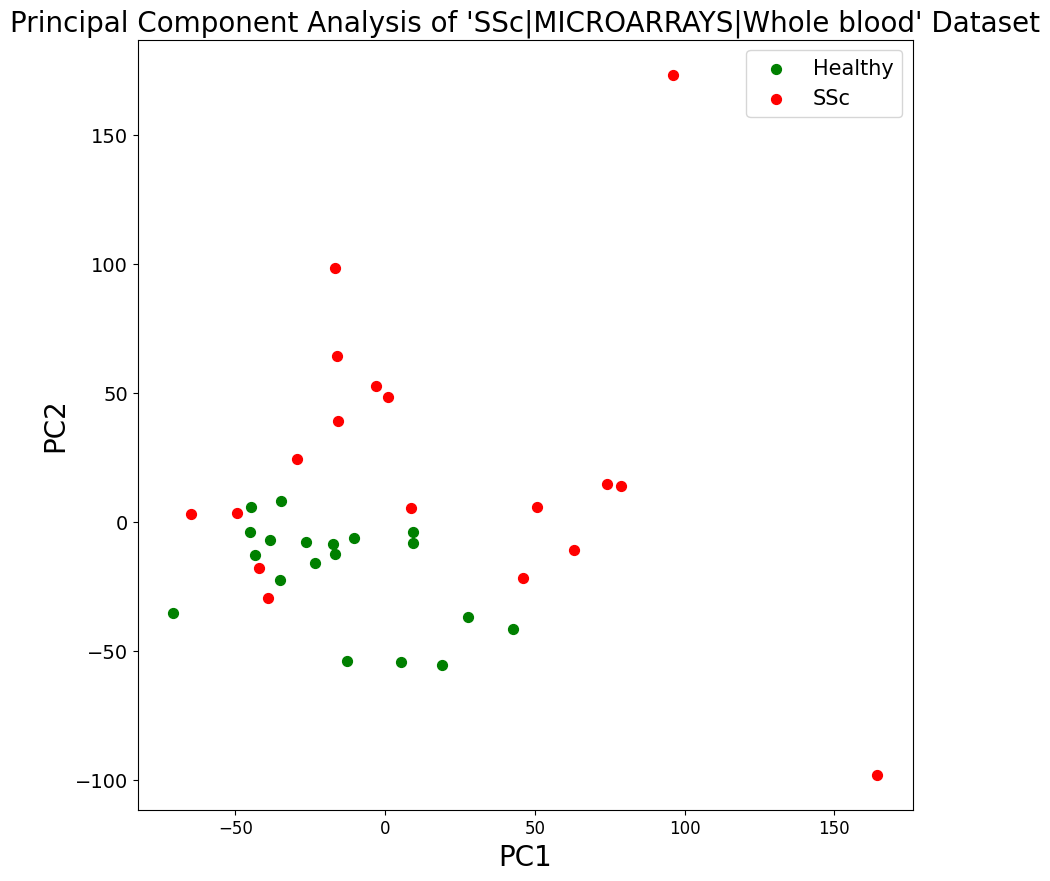

<Figure size 640x480 with 0 Axes>

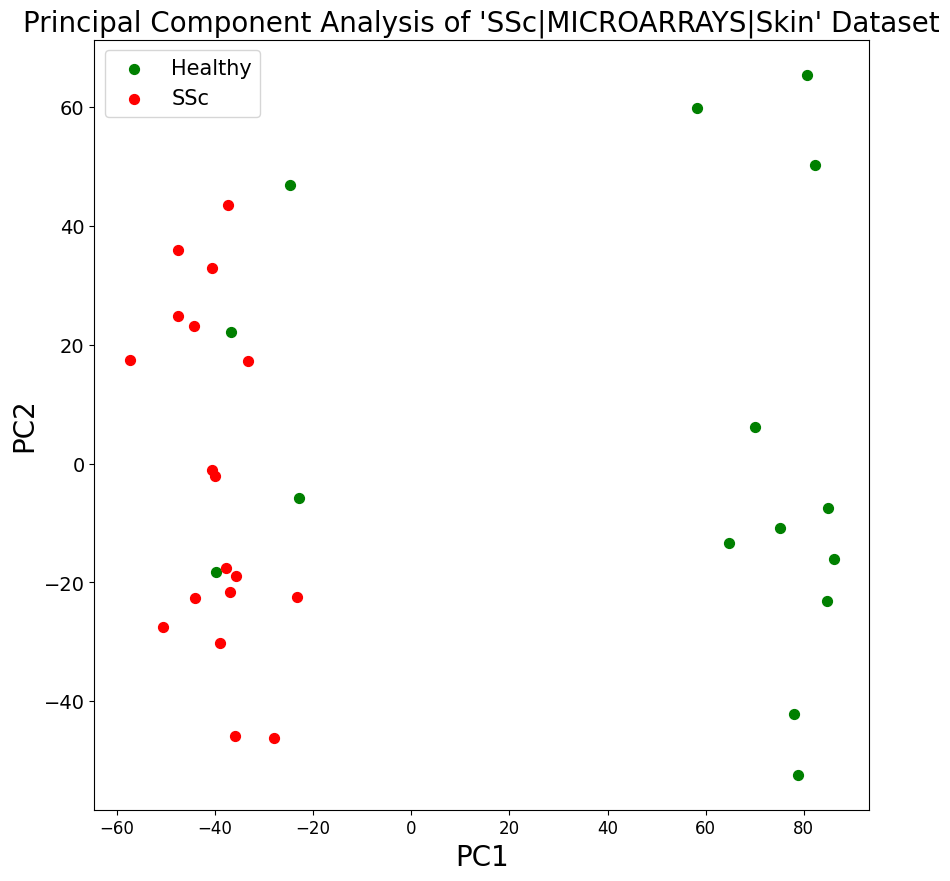

<Figure size 640x480 with 0 Axes>

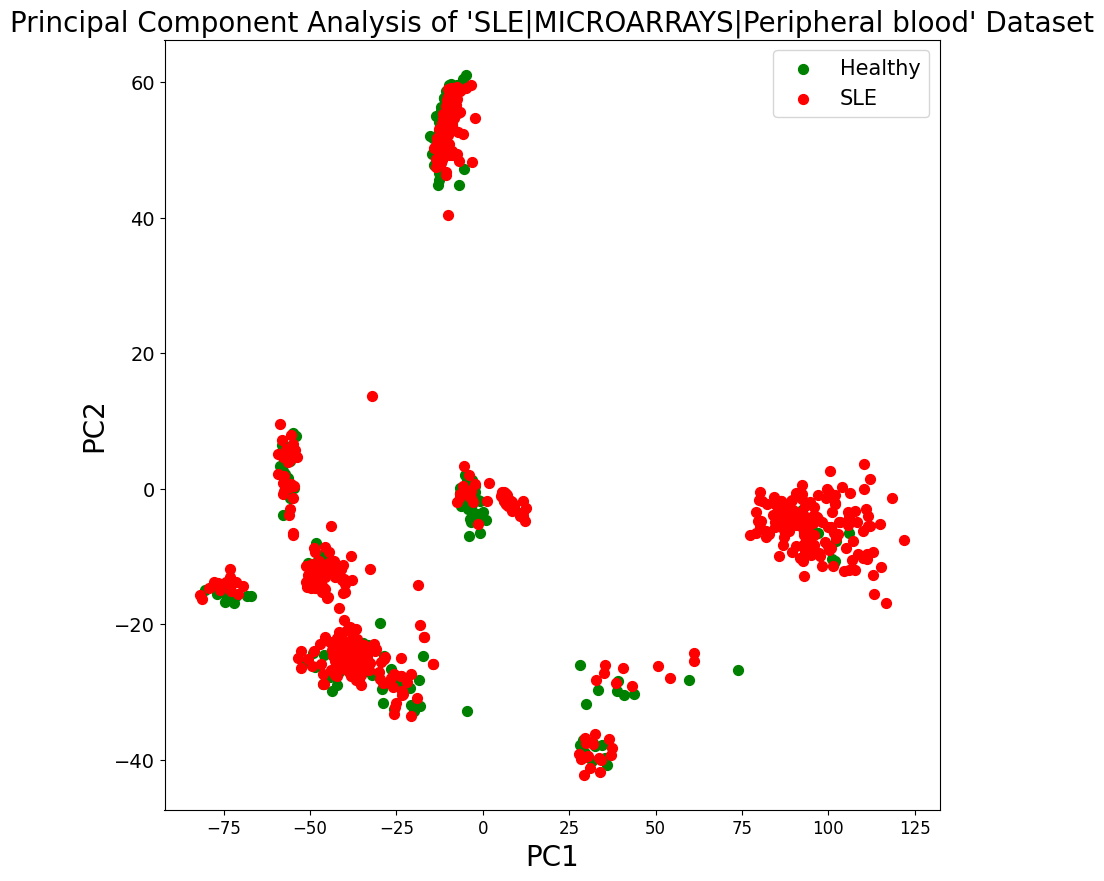

<Figure size 640x480 with 0 Axes>

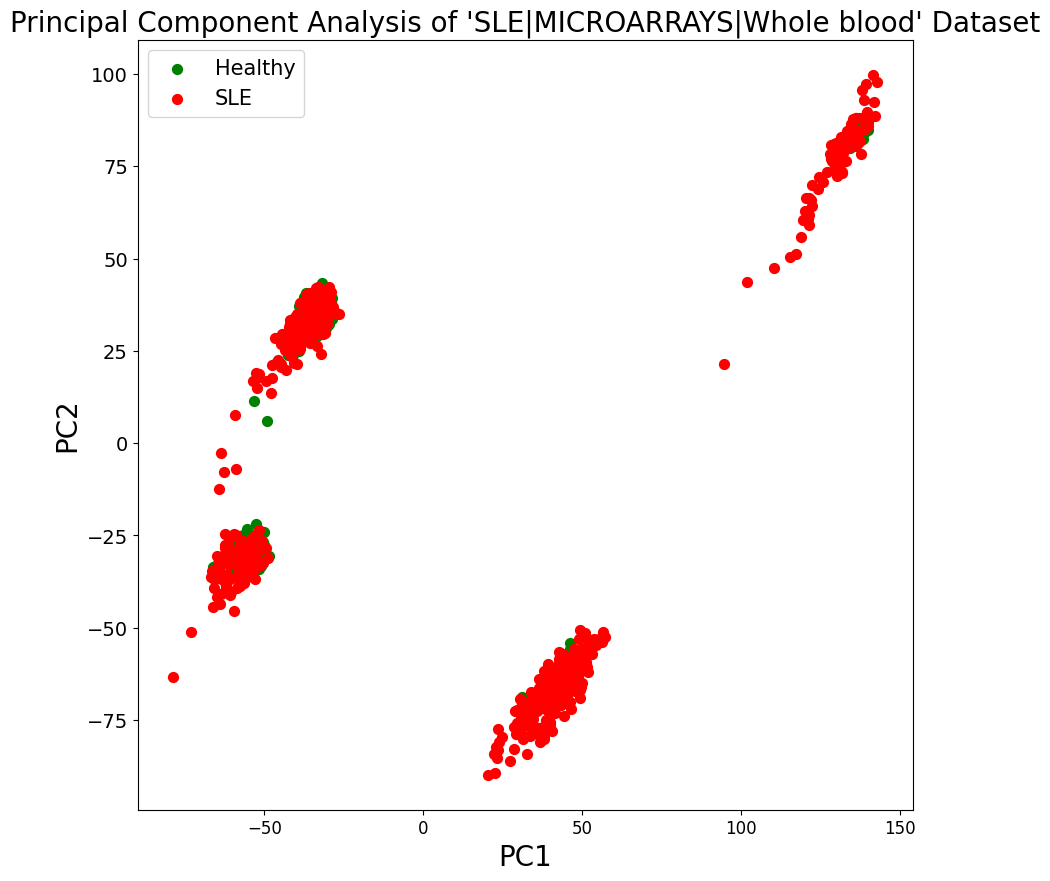

<Figure size 640x480 with 0 Axes>

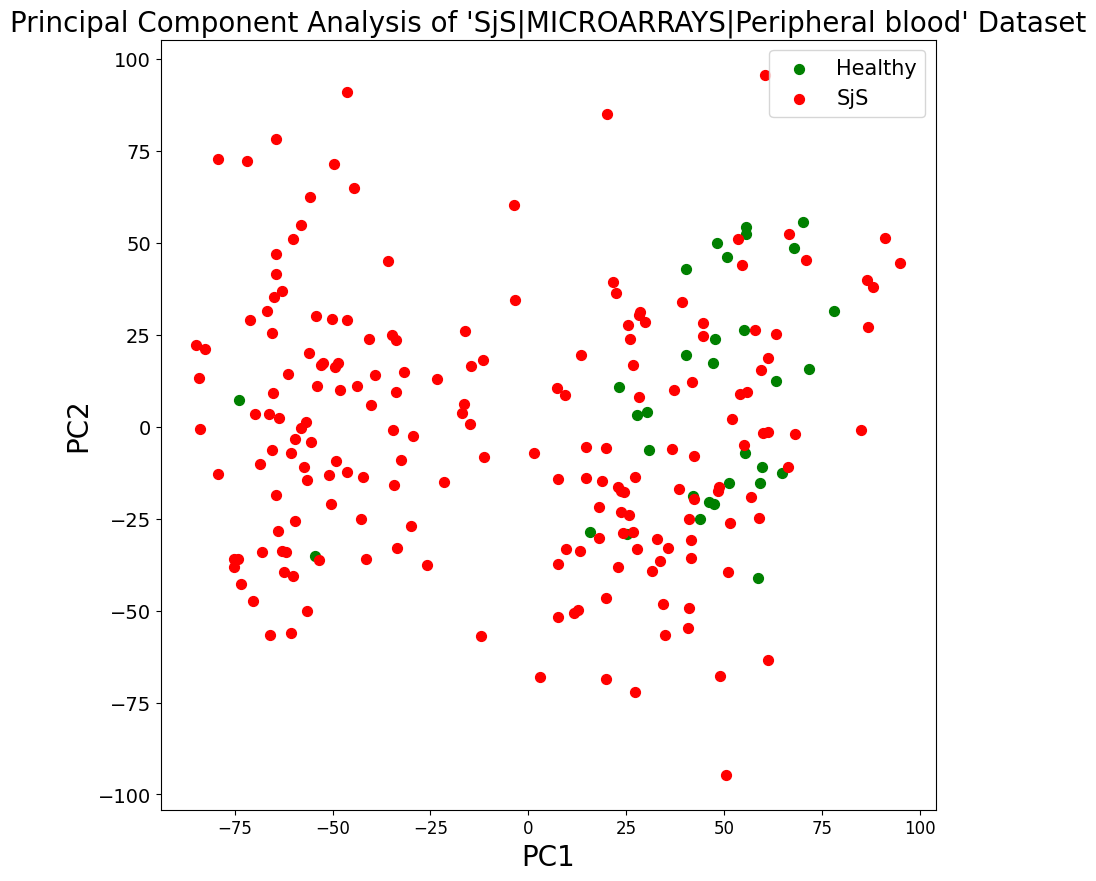

<Figure size 640x480 with 0 Axes>

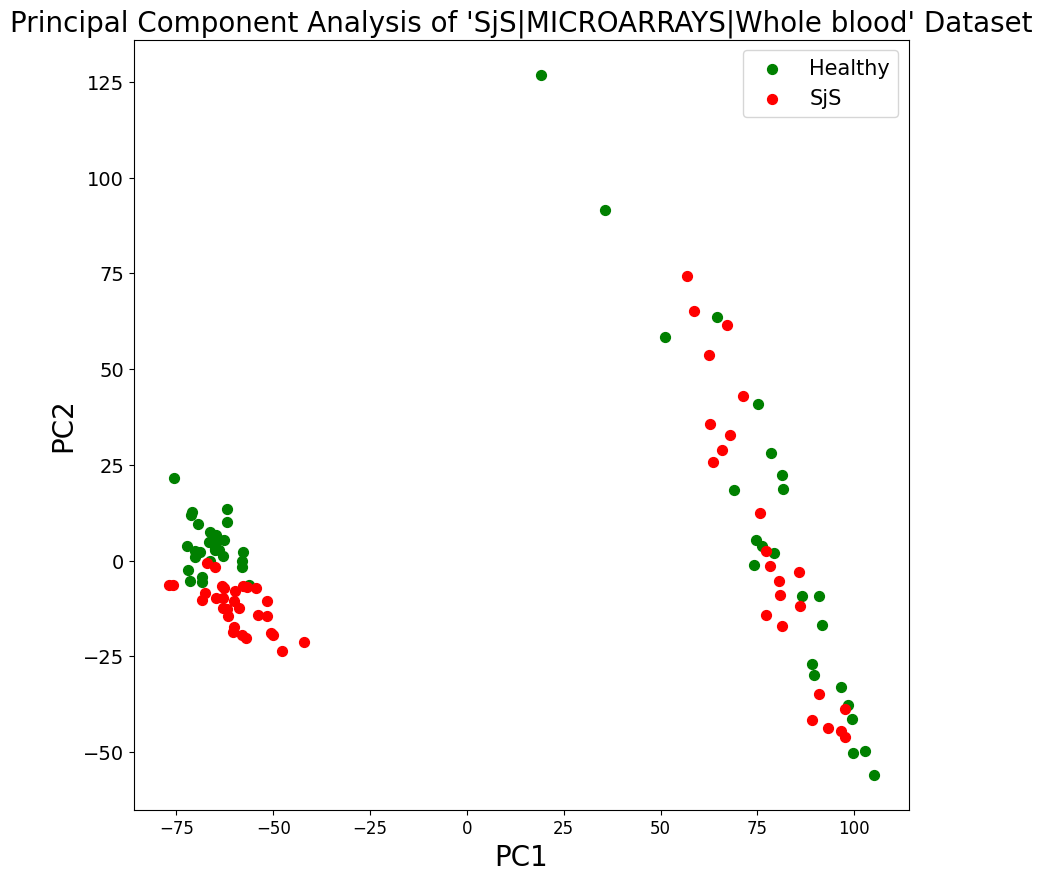

<Figure size 640x480 with 0 Axes>

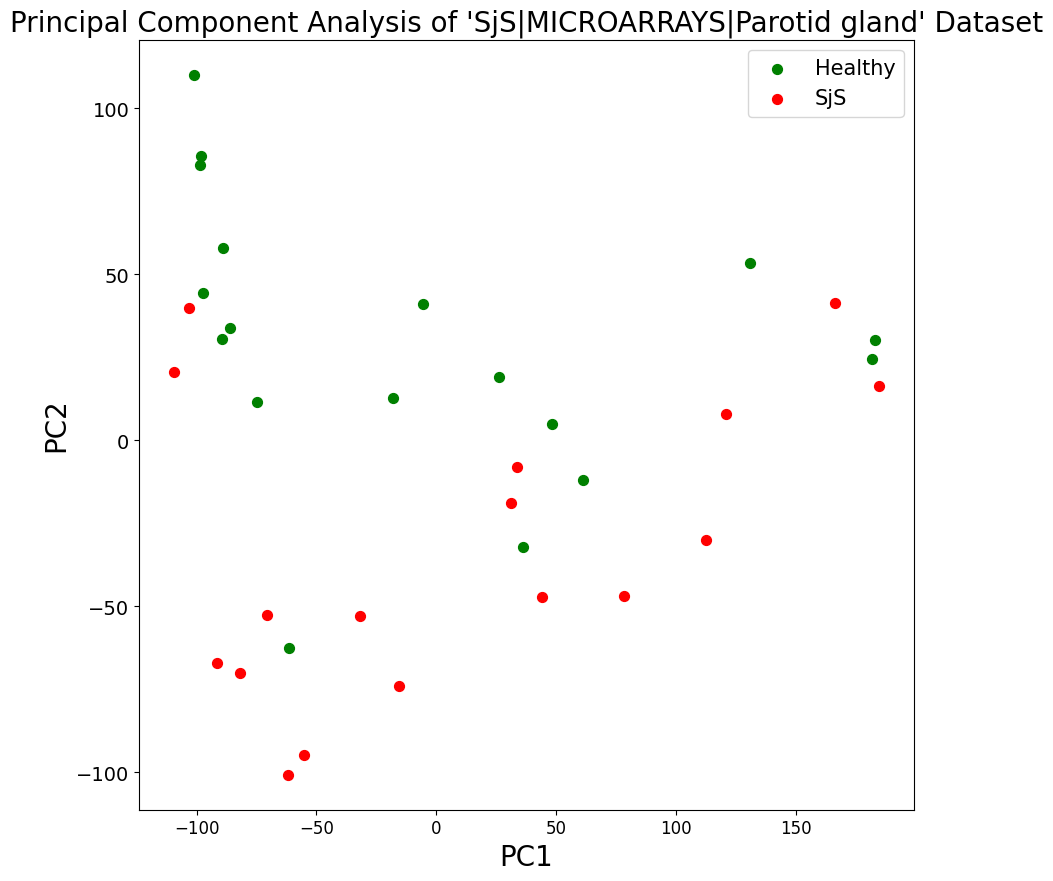

<Figure size 640x480 with 0 Axes>

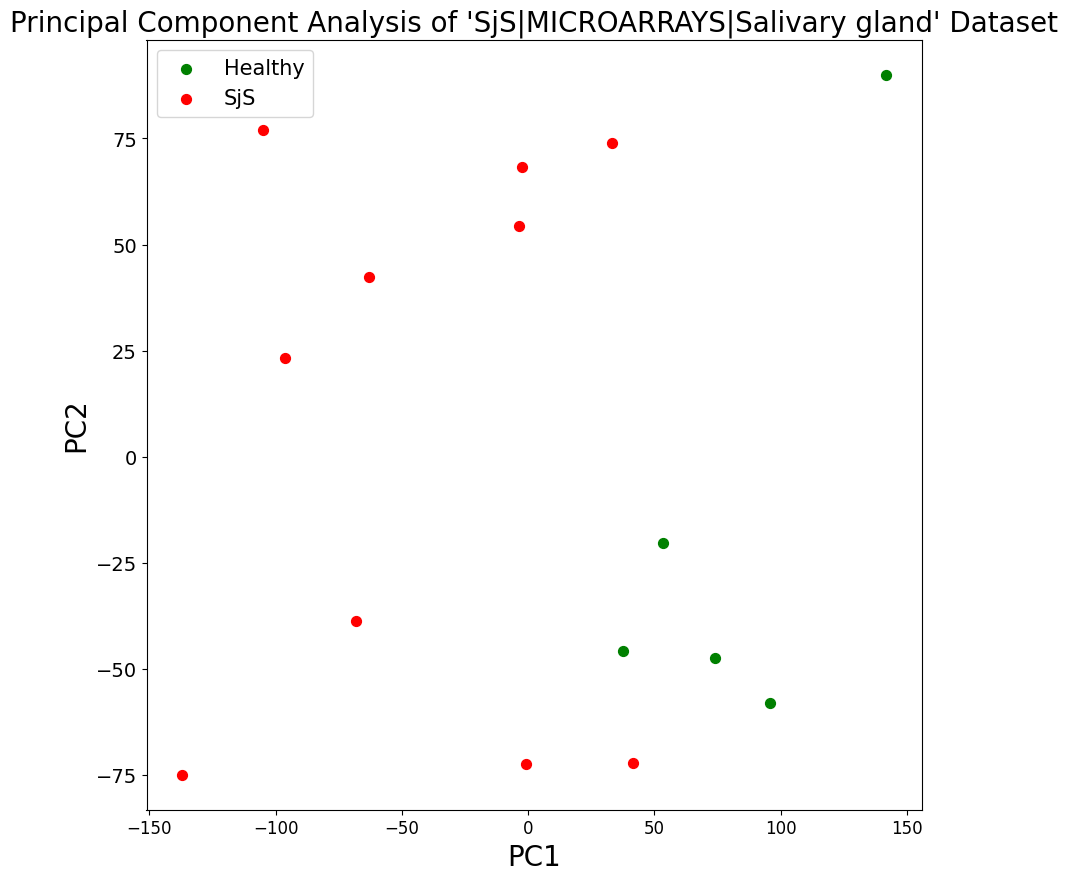

<Figure size 640x480 with 0 Axes>

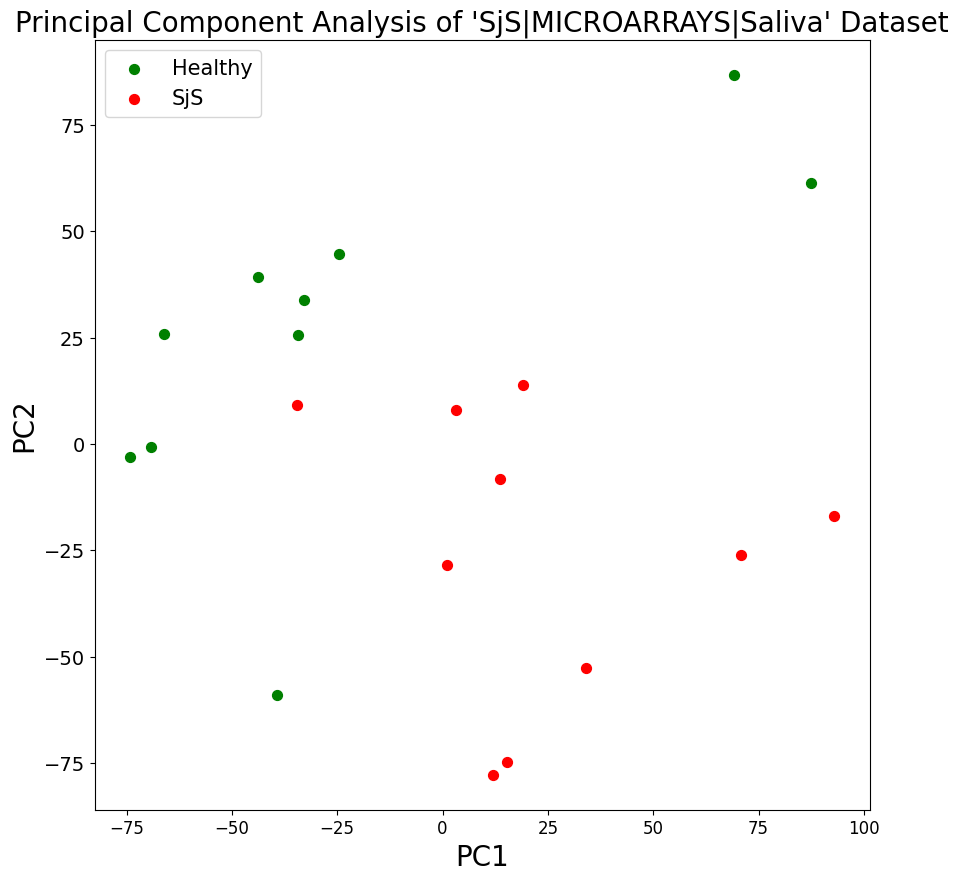

<Figure size 640x480 with 0 Axes>

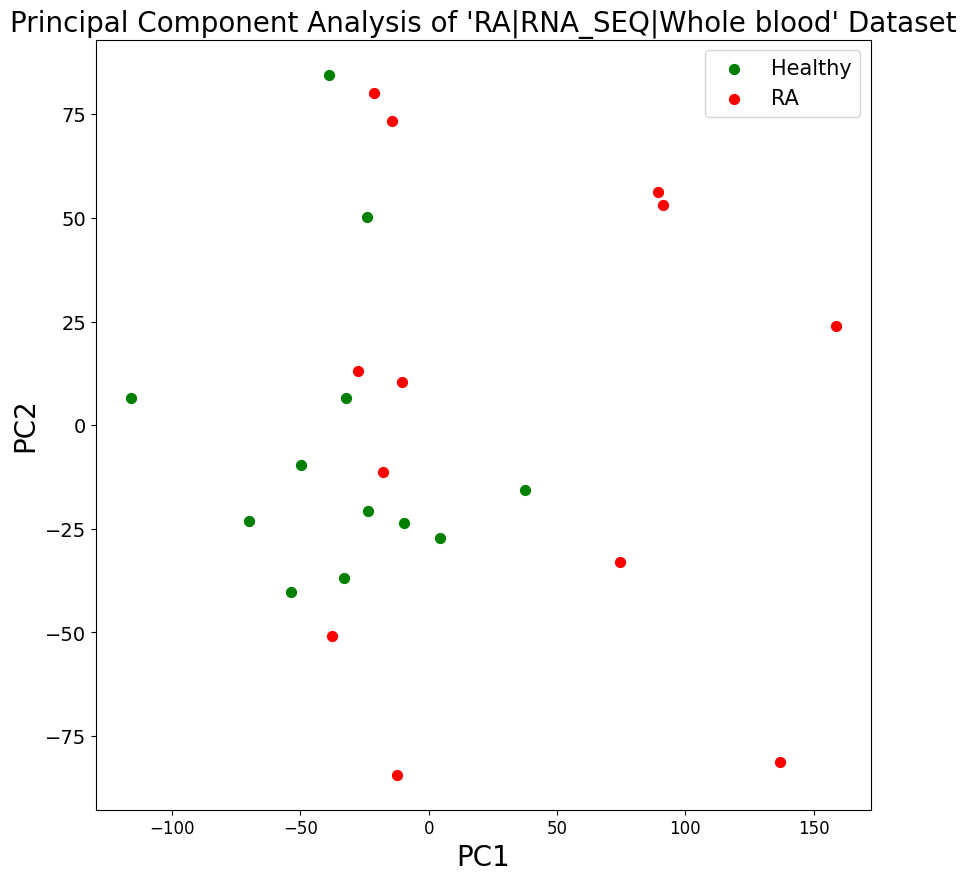

<Figure size 640x480 with 0 Axes>

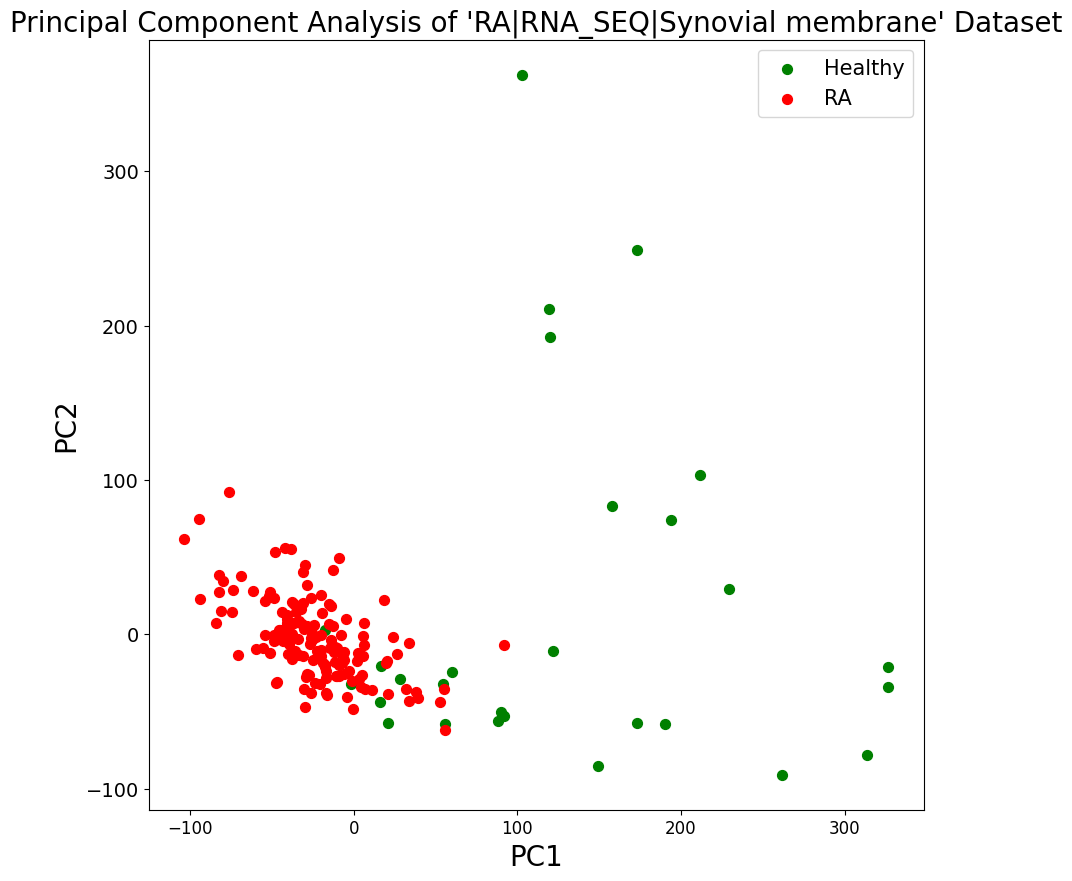

<Figure size 640x480 with 0 Axes>

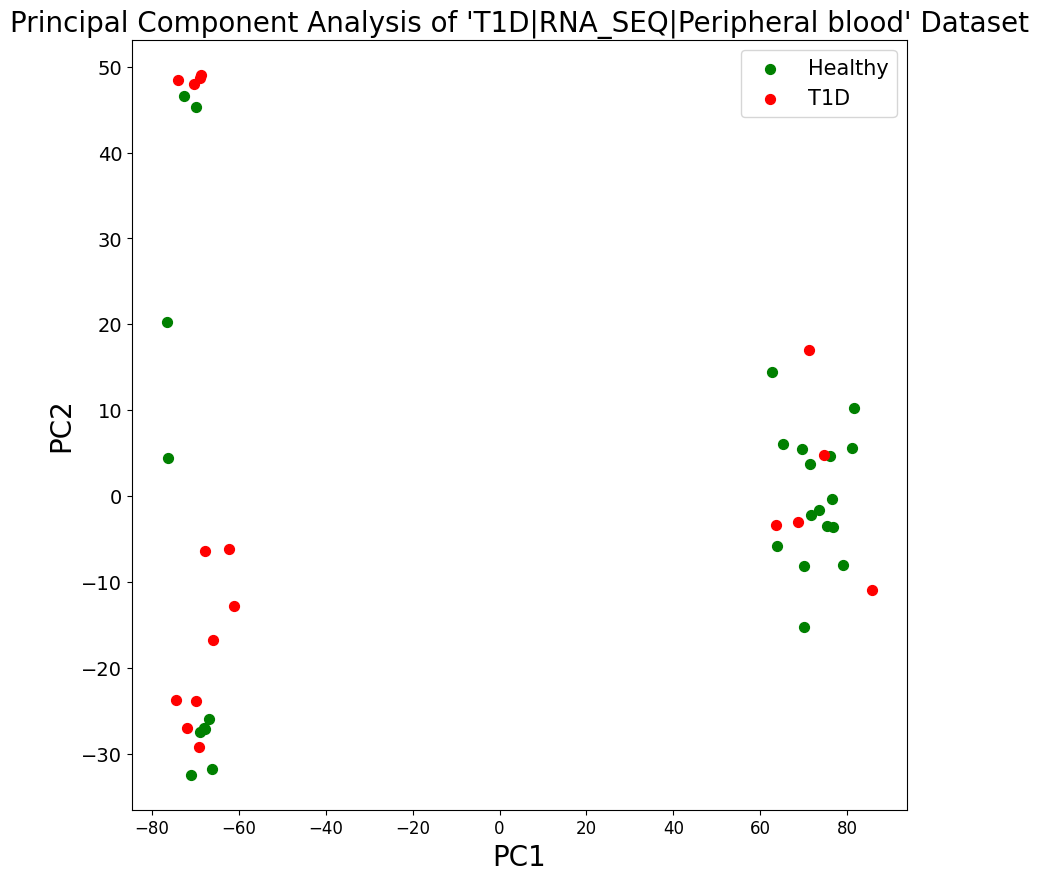

<Figure size 640x480 with 0 Axes>

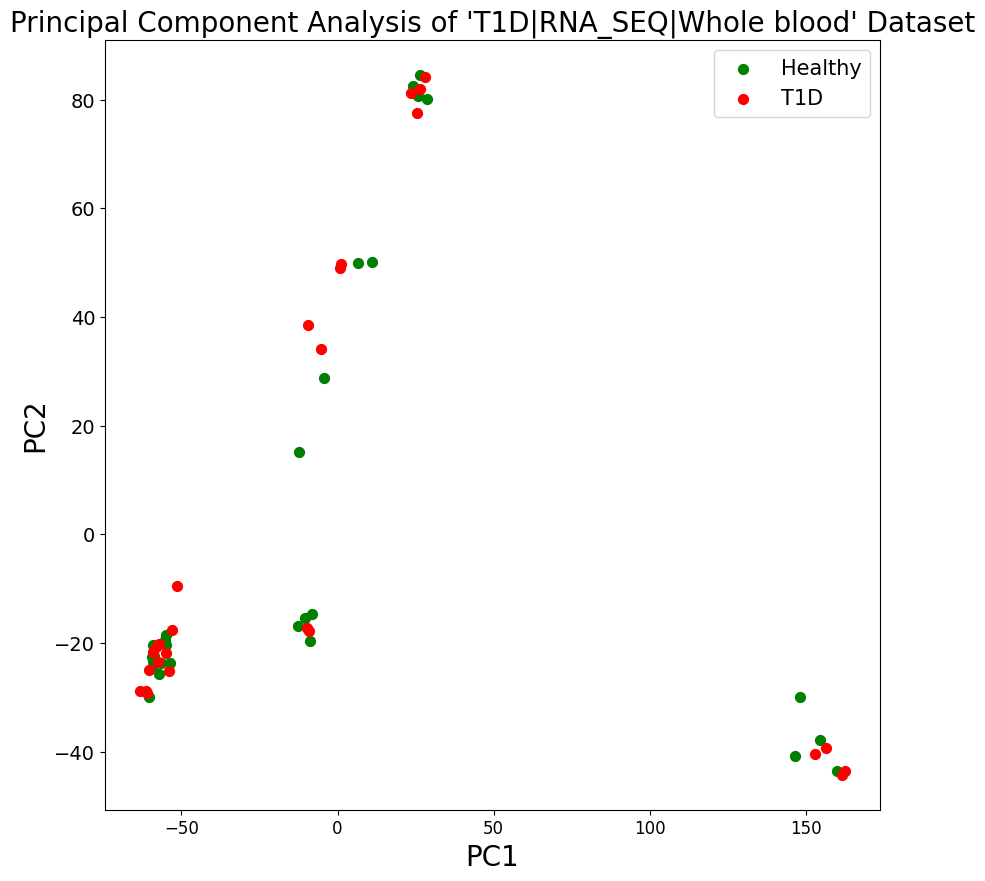

<Figure size 640x480 with 0 Axes>

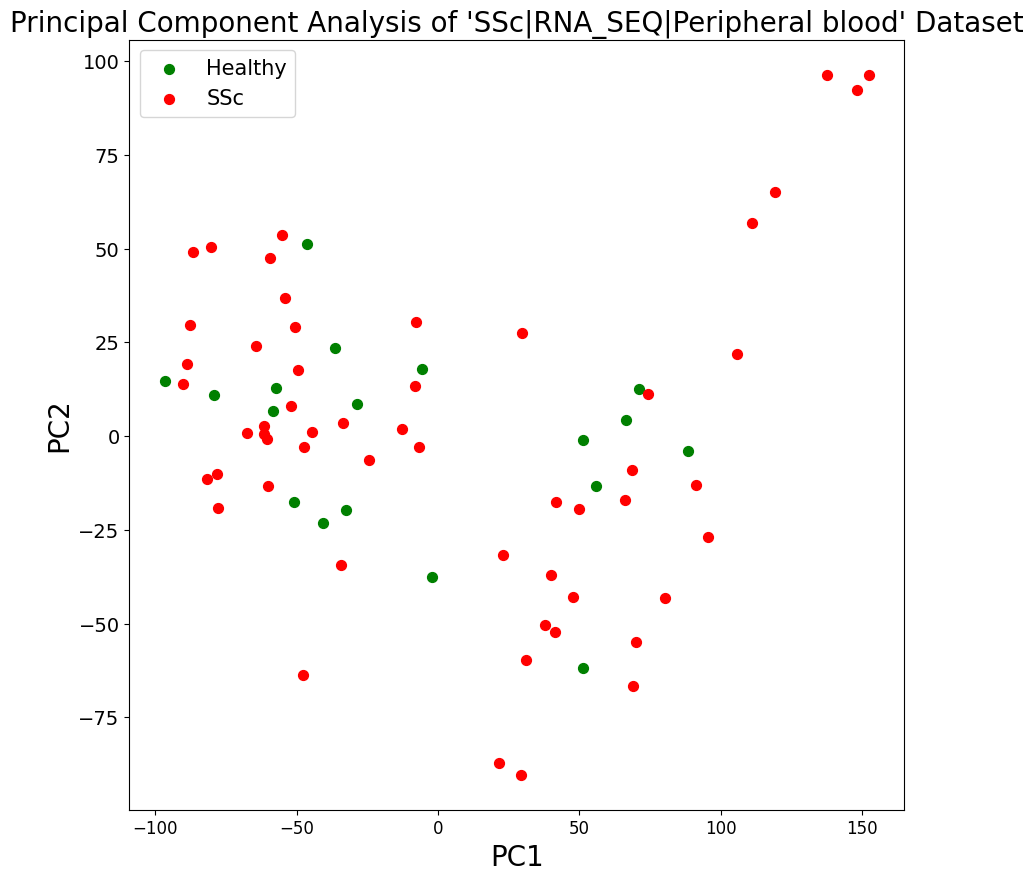

<Figure size 640x480 with 0 Axes>

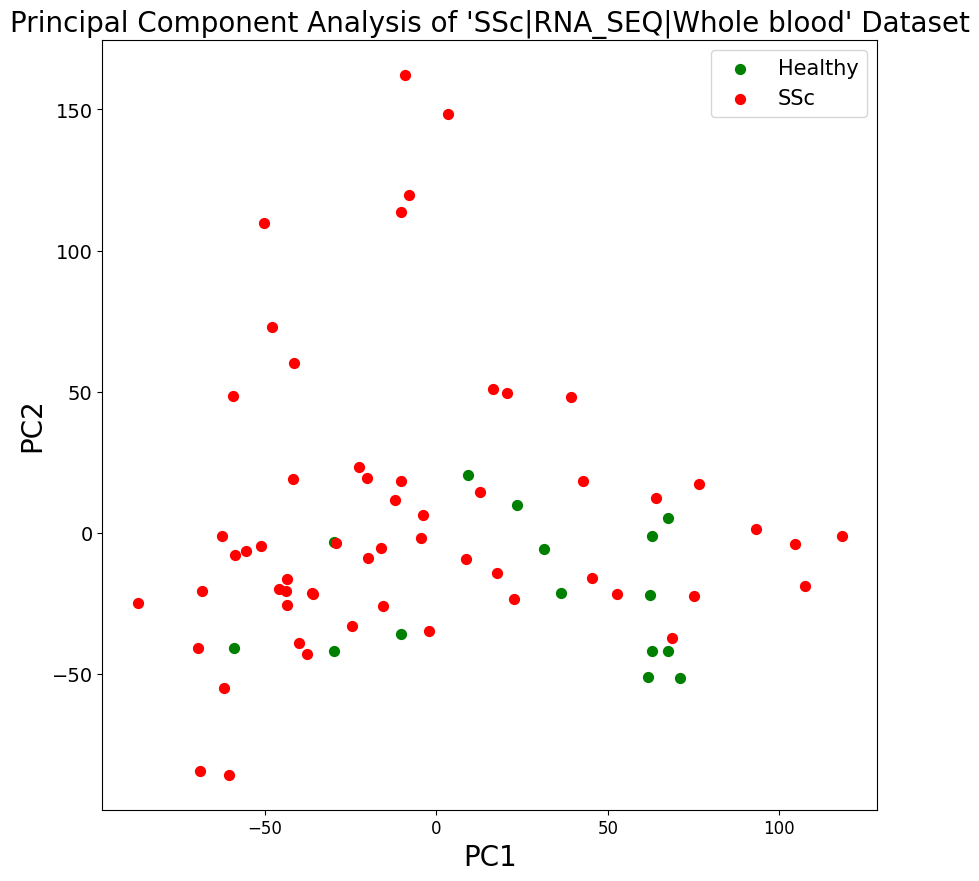

<Figure size 640x480 with 0 Axes>

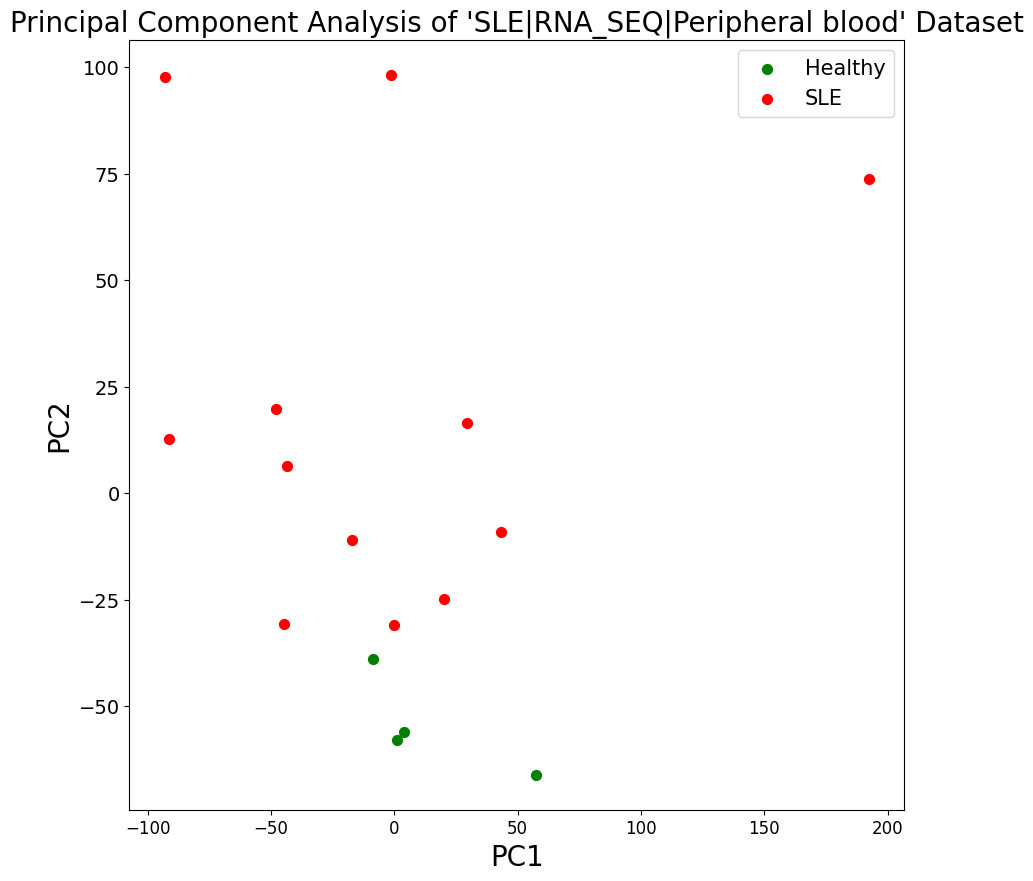

<Figure size 640x480 with 0 Axes>

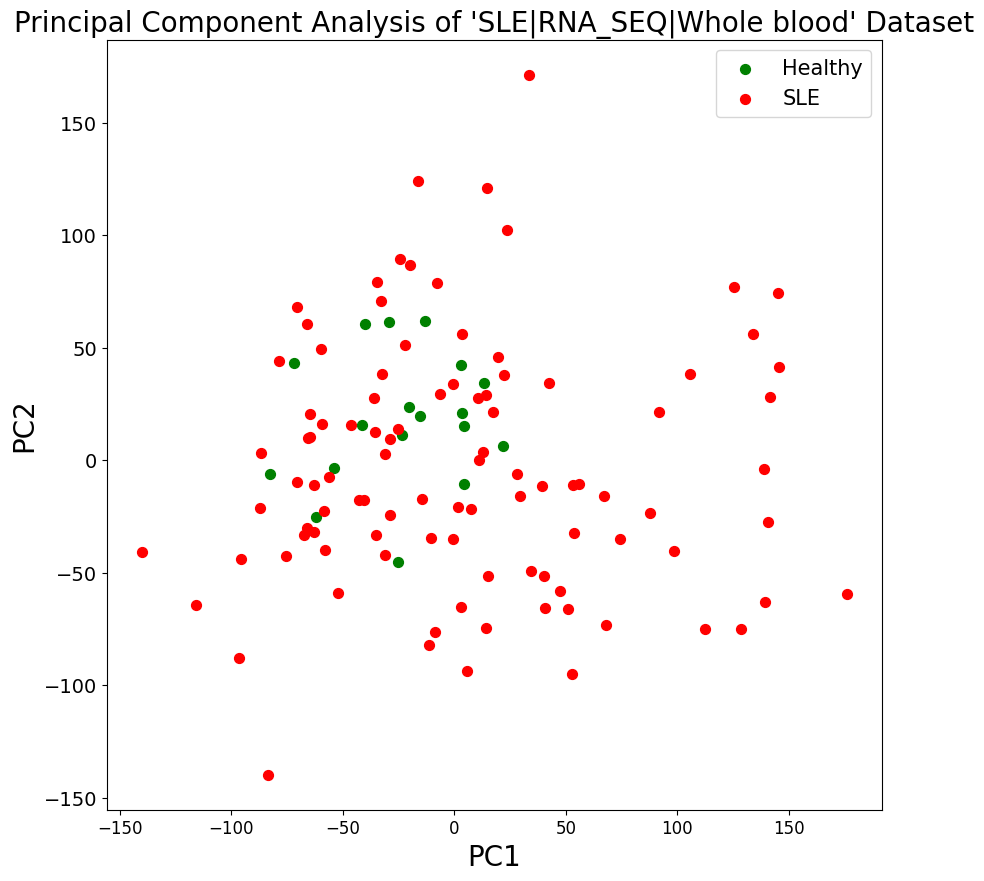

<Figure size 640x480 with 0 Axes>

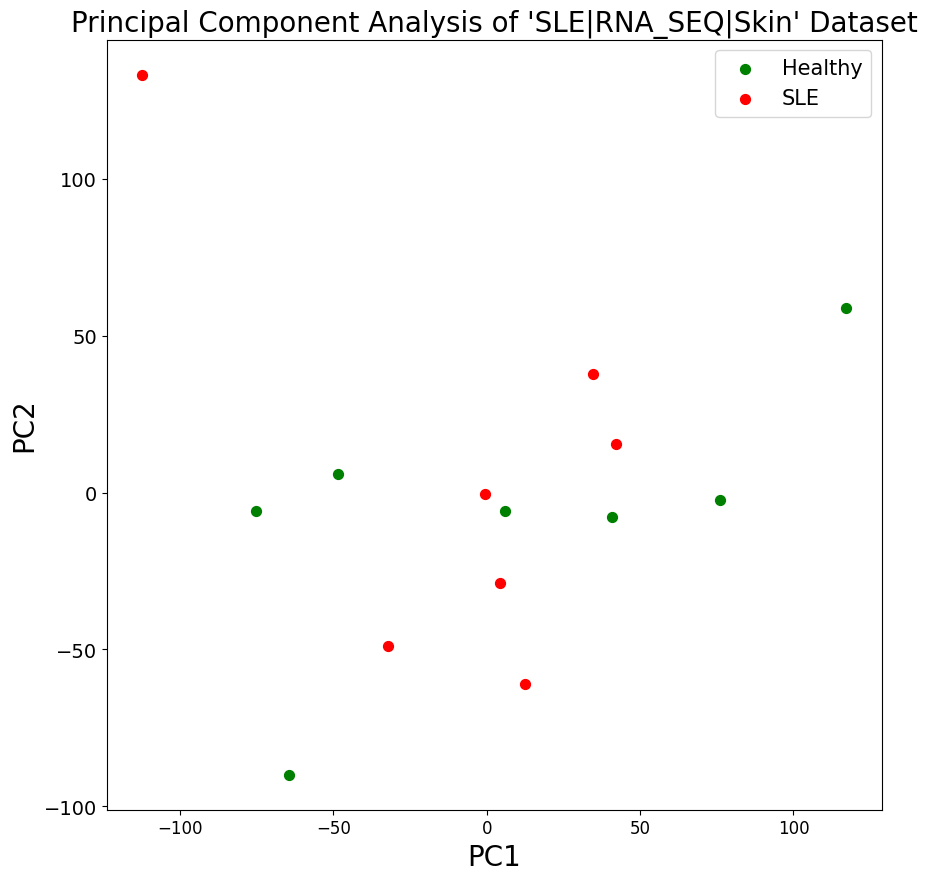

In [20]:
for sequencing_technique in SequencingTechnique:
    for condition in Condition:
        for tissue in TissueEnum:
            pca = PcaHelper(ConditionSequencingTissueDataLoader(condition, sequencing_technique, tissue), files_path, metadata_path, datasets_info_path)
            pca.draw(
                column_that_defines_colors="Condition",
                target_colors=[
                    ("Healthy", "g"),
                    (condition.name, "r")
                ]
            )

# PCA per file (exhaustive)

INFO : Processing file: GSE90081.tsv.parquet
INFO : --- Running PCA for 'RA|GSE90081.tsv.parquet'---
INFO : Loaded dataset for PCA with shape: Samples(24), Genes(13647)
INFO : Dataset normalised | Mean: '4.7904746081491294e-18' Standard Deviation:'1.0'
INFO : Explained variation per principal component: [0.30326326 0.15732321]
INFO : ----------------------------------------------
INFO : Processing file: GSE38351_RA_GPL96.tsv.parquet
INFO : --- Running PCA for 'RA|GSE38351_RA_GPL96.tsv.parquet'---
INFO : Loaded dataset for PCA with shape: Samples(20), Genes(13906)
INFO : Dataset normalised | Mean: '1.8263108829407794e-16' Standard Deviation:'0.9999999999999999'
INFO : Explained variation per principal component: [0.29969746 0.10061219]
INFO : ----------------------------------------------
INFO : Processing file: GSE65010_Naive_effector_T_cells.tsv.parquet
INFO : --- Running PCA for 'RA|GSE65010_Naive_effector_T_cells.tsv.parquet'---
INFO : Loaded dataset for PCA with shape: Samples(12),

<Figure size 640x480 with 0 Axes>

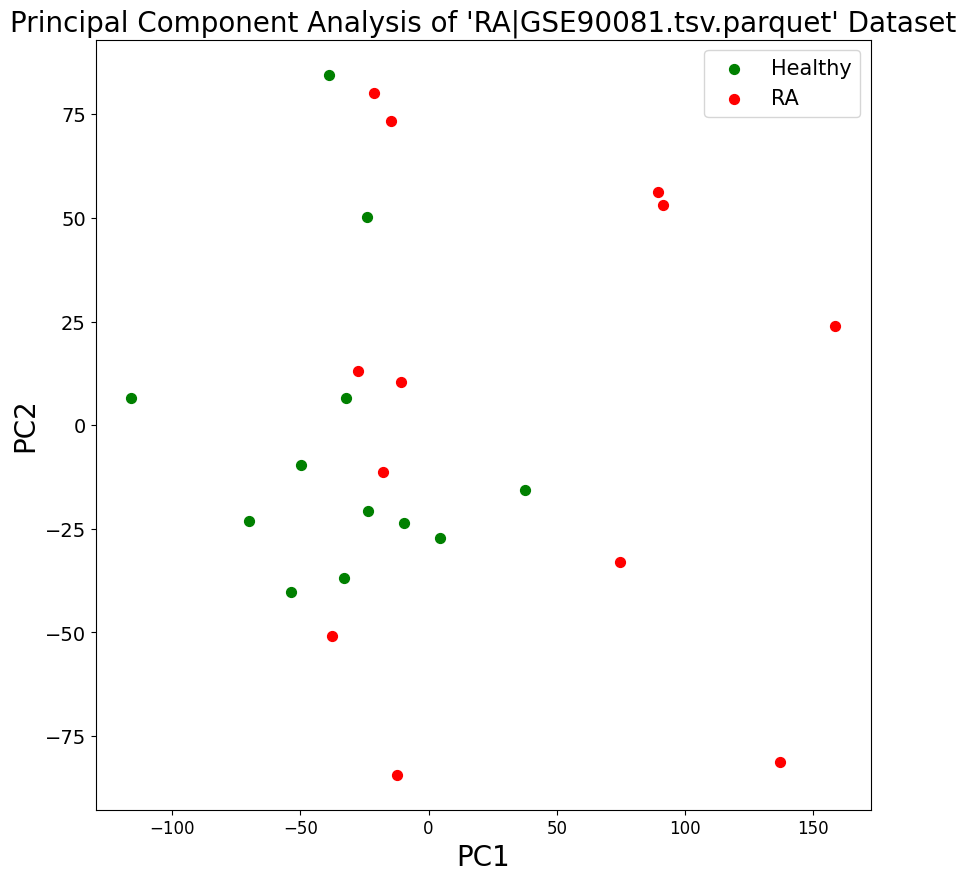

<Figure size 640x480 with 0 Axes>

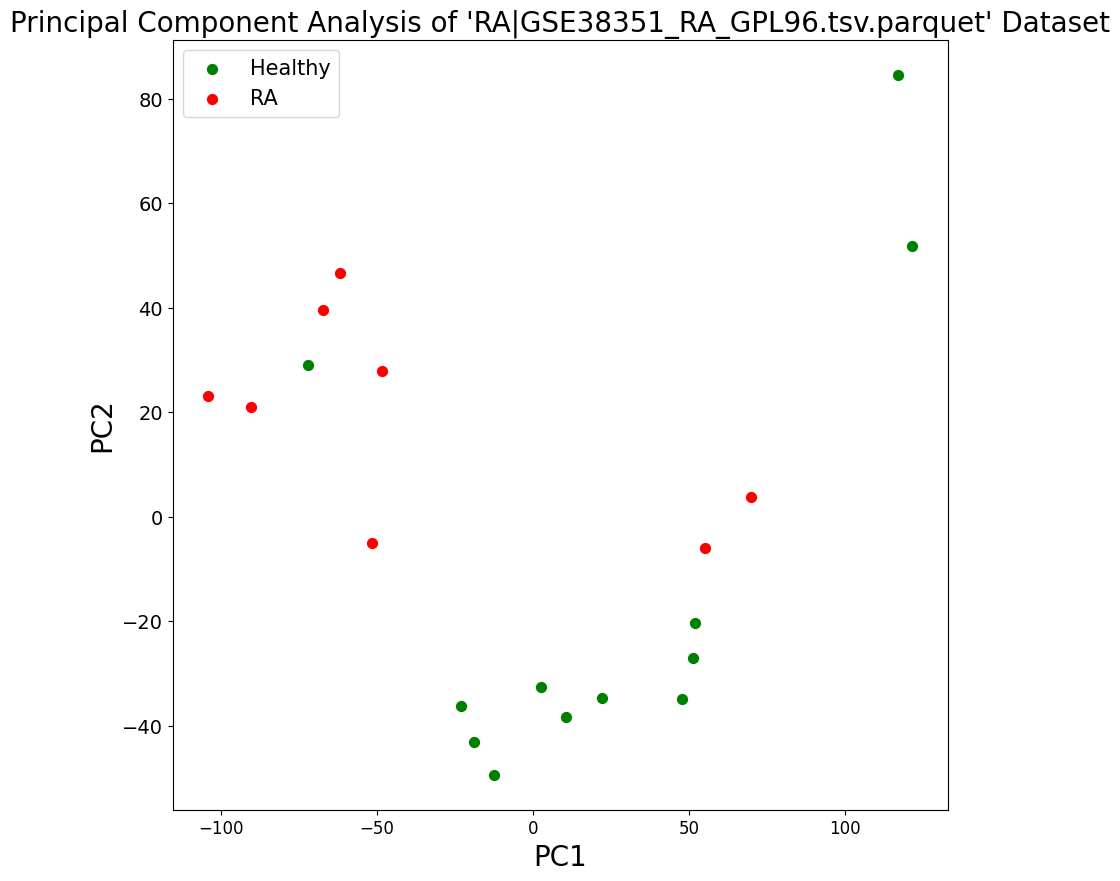

<Figure size 640x480 with 0 Axes>

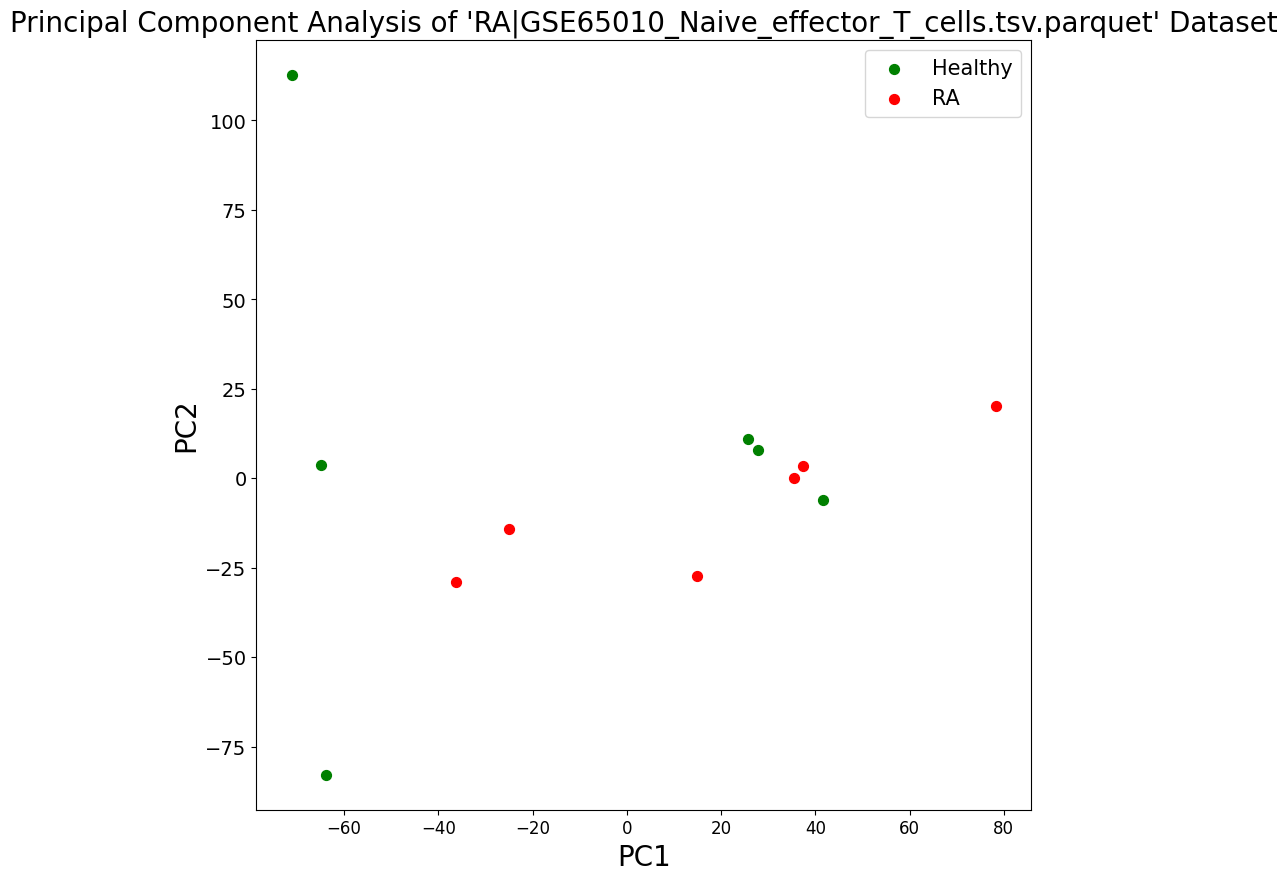

<Figure size 640x480 with 0 Axes>

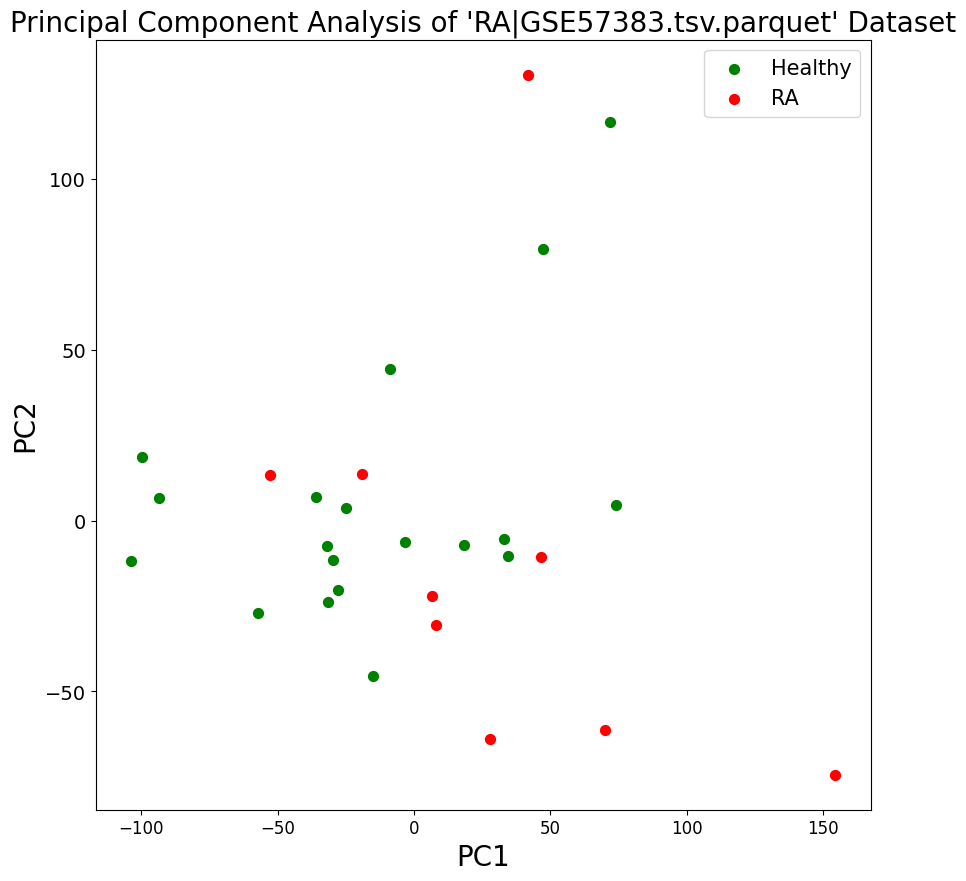

<Figure size 640x480 with 0 Axes>

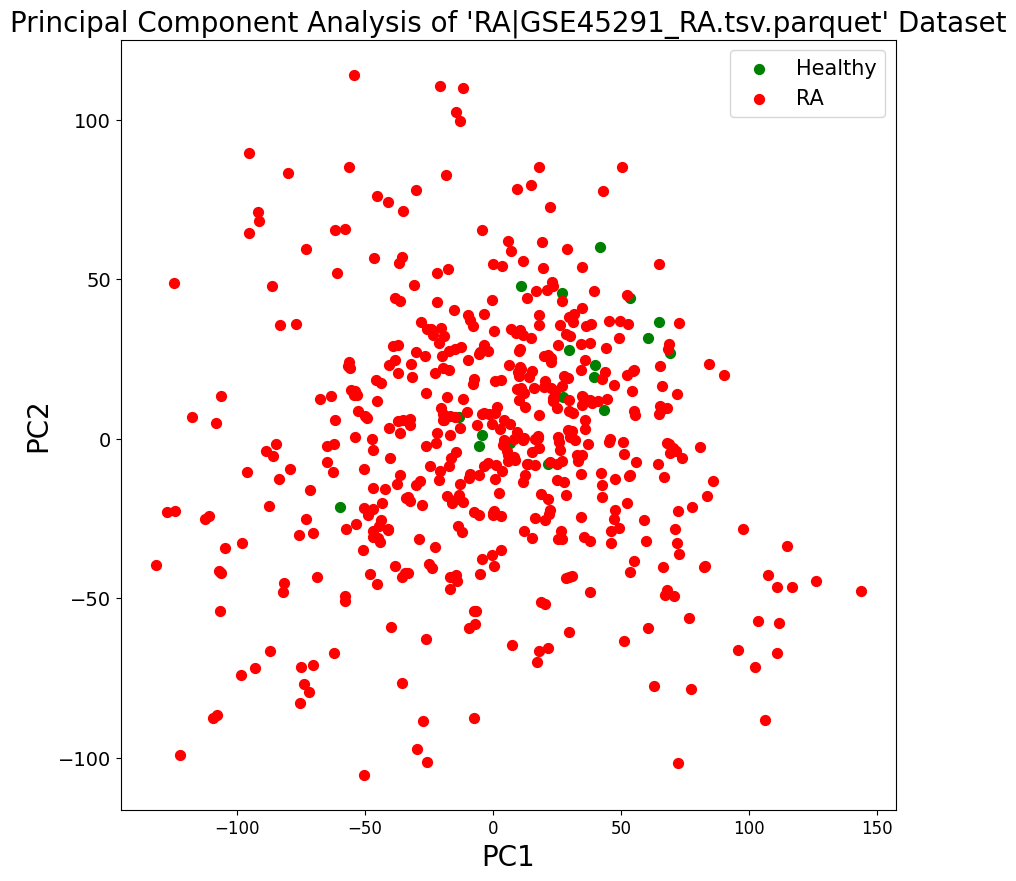

<Figure size 640x480 with 0 Axes>

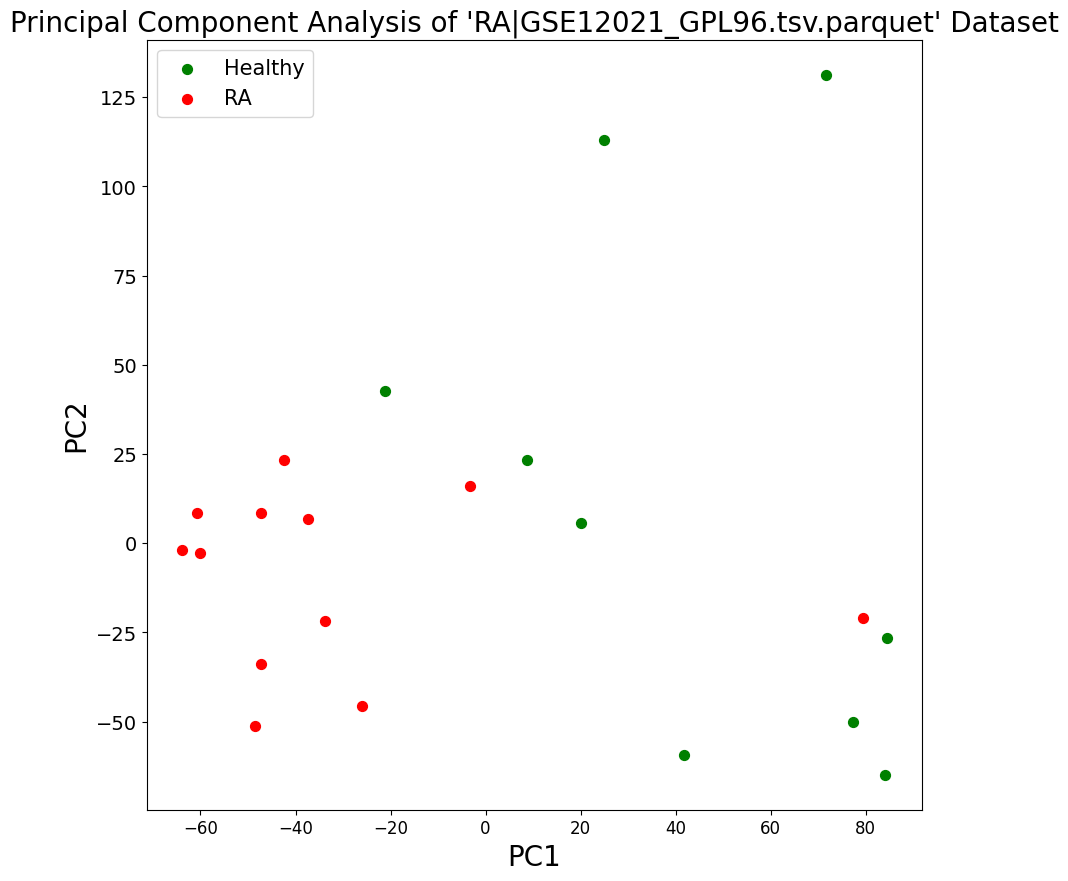

<Figure size 640x480 with 0 Axes>

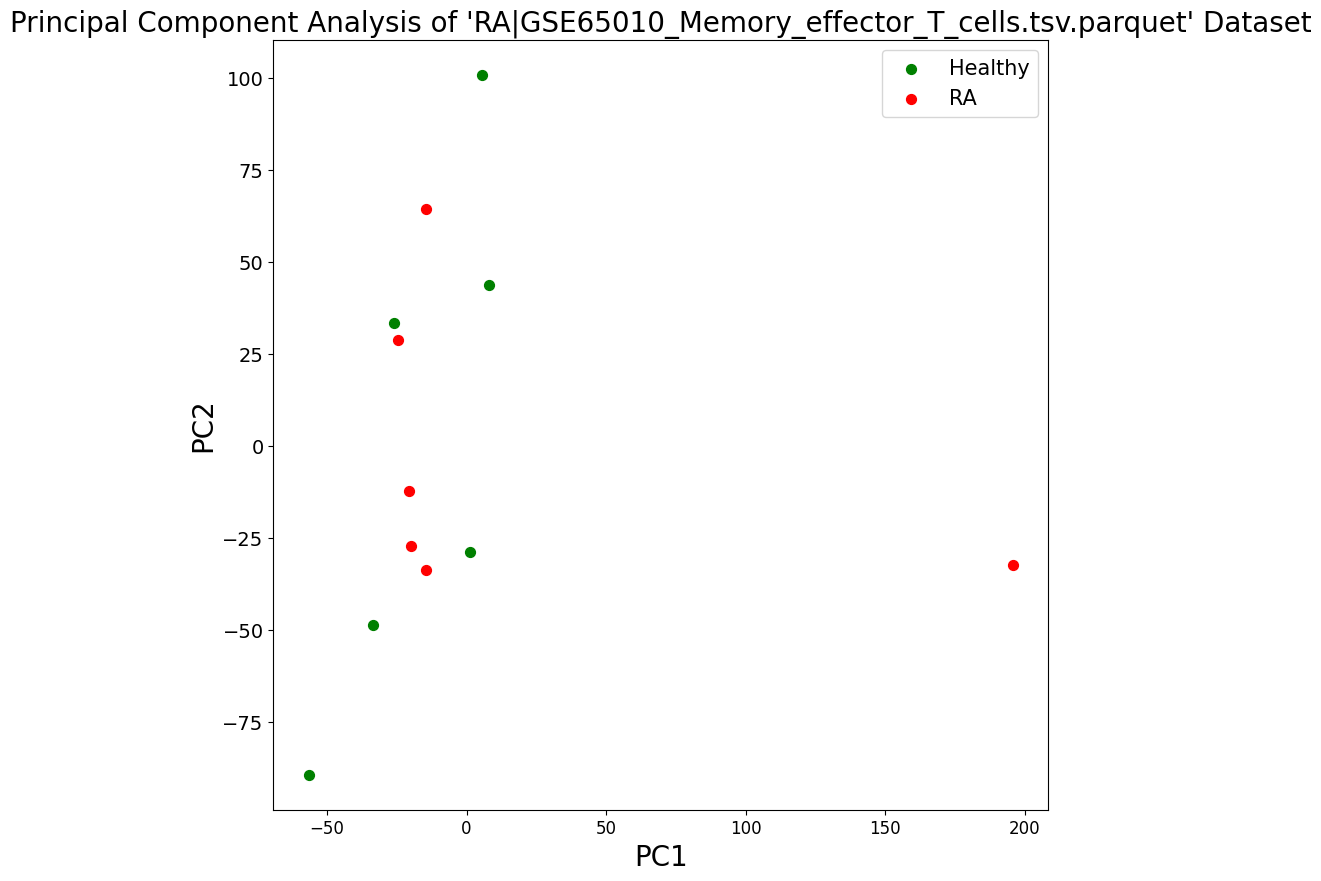

<Figure size 640x480 with 0 Axes>

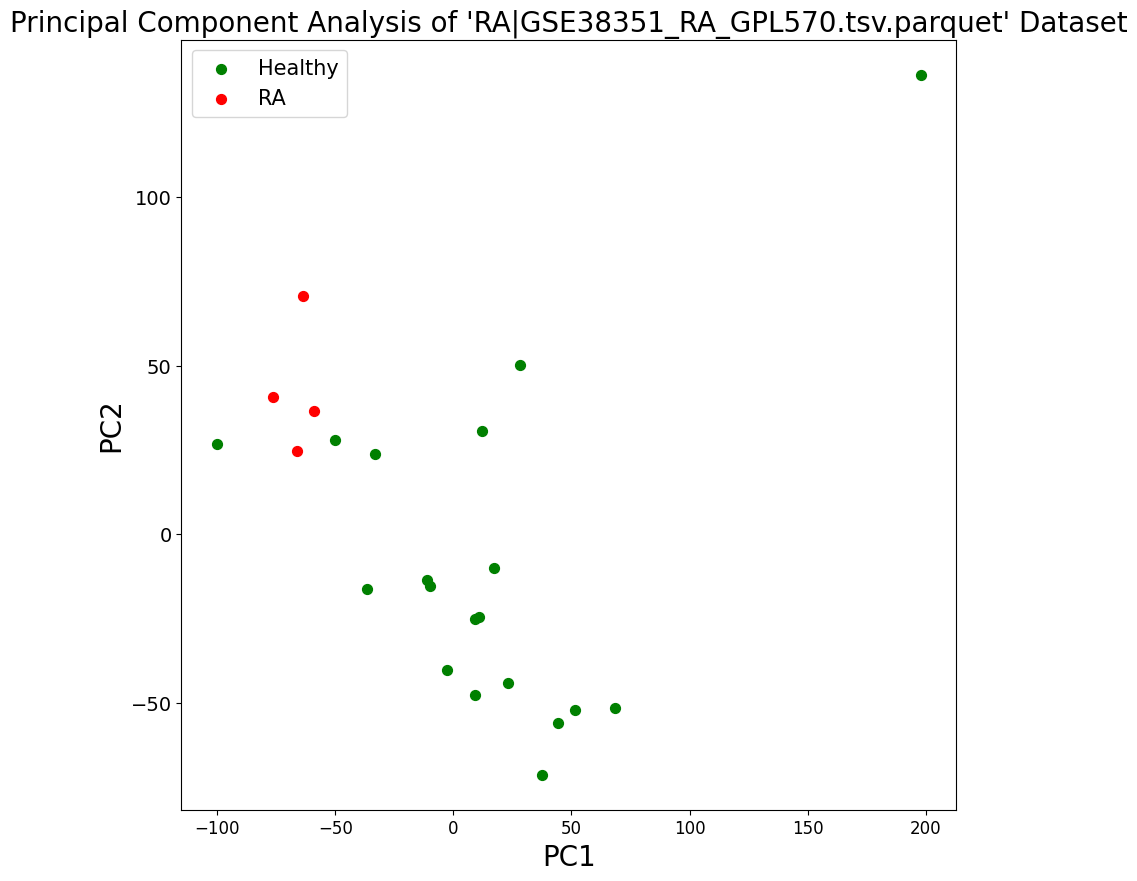

<Figure size 640x480 with 0 Axes>

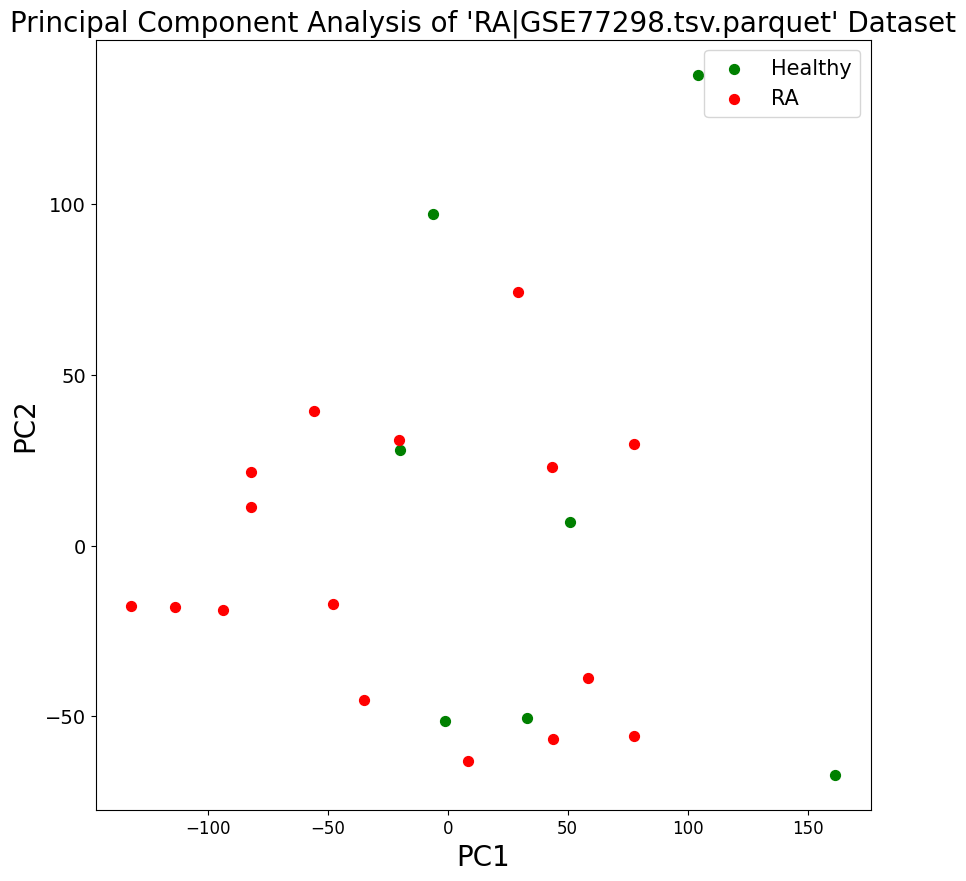

<Figure size 640x480 with 0 Axes>

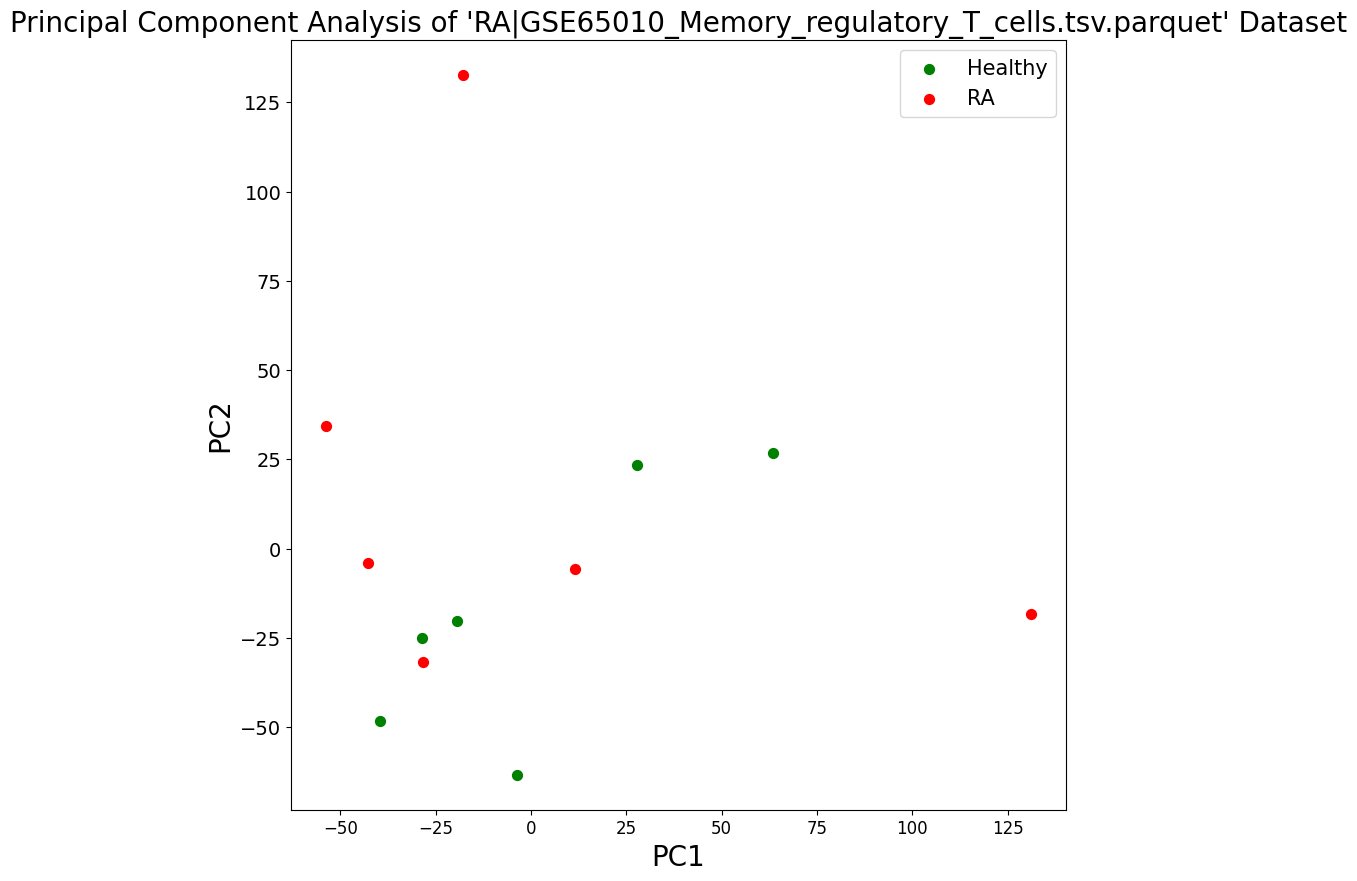

<Figure size 640x480 with 0 Axes>

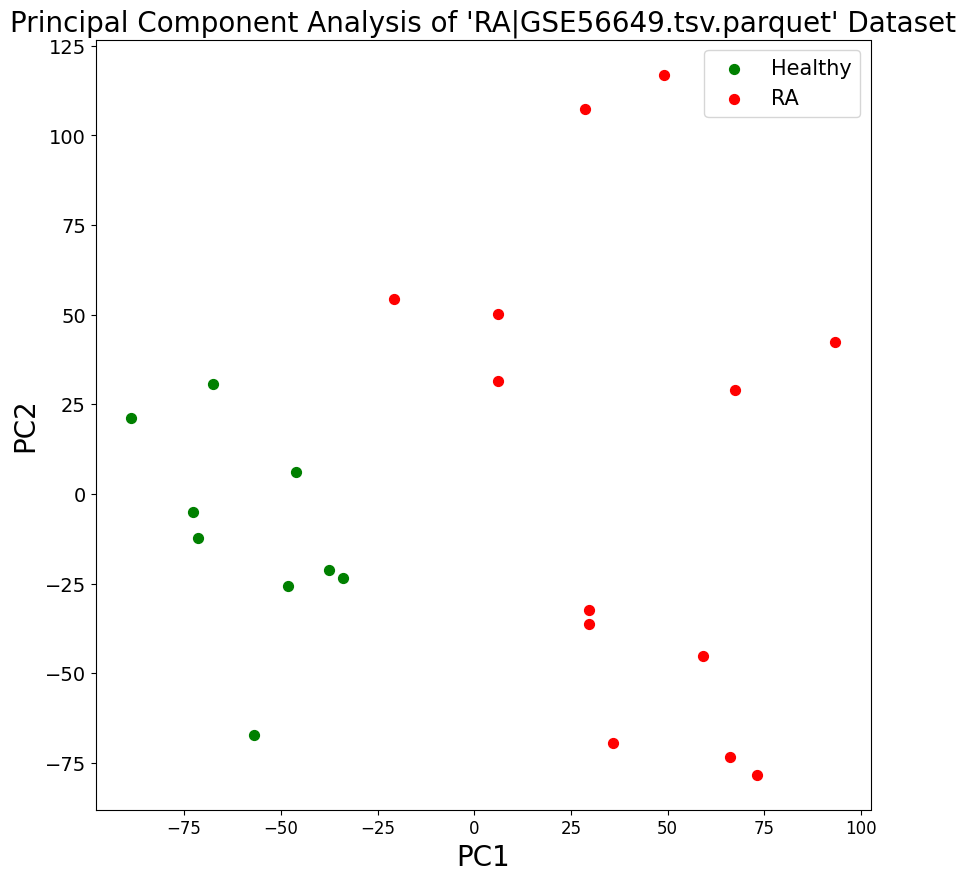

<Figure size 640x480 with 0 Axes>

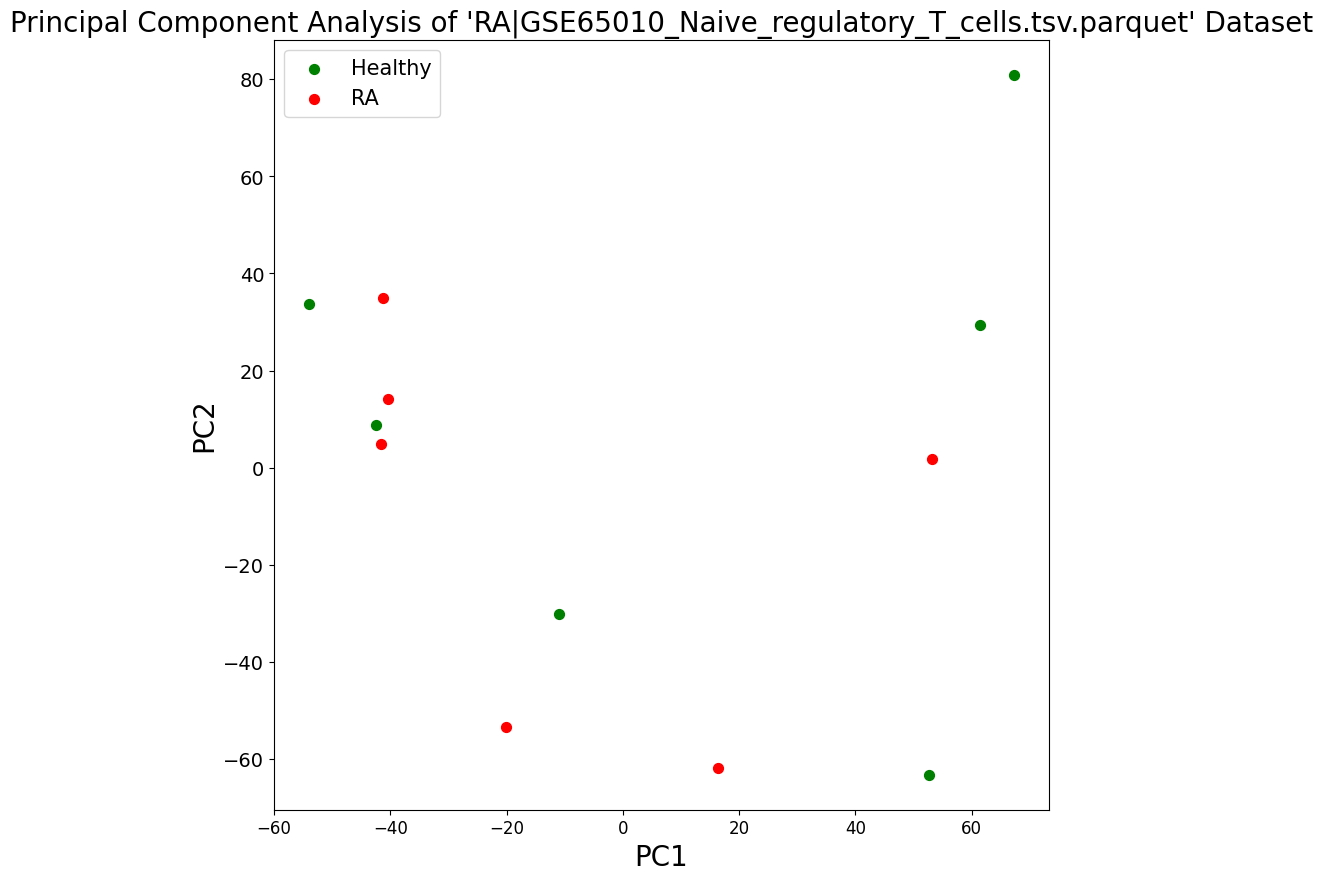

<Figure size 640x480 with 0 Axes>

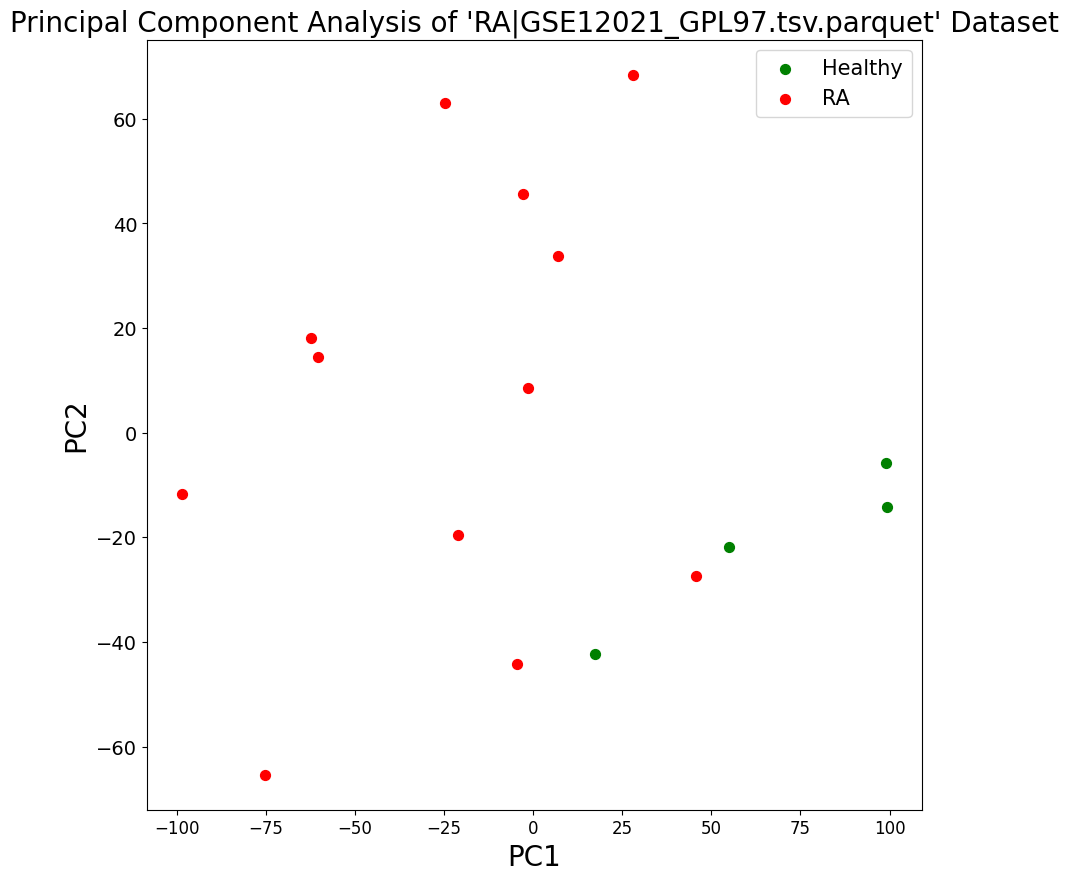

<Figure size 640x480 with 0 Axes>

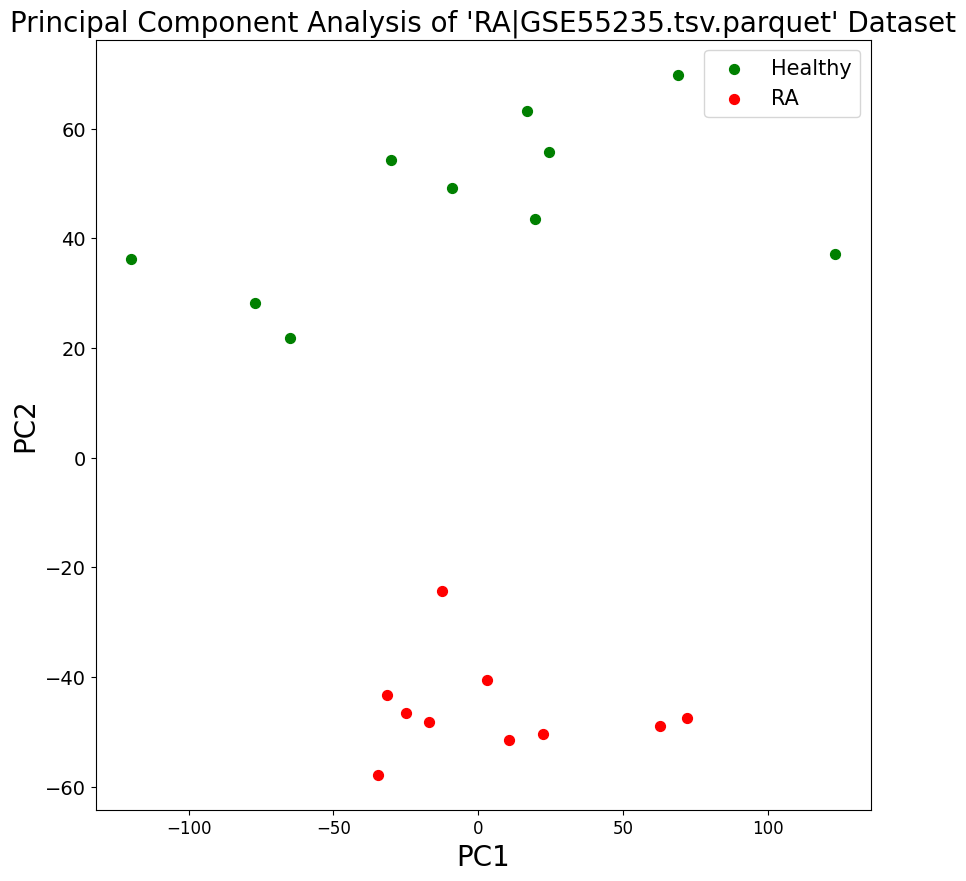

<Figure size 640x480 with 0 Axes>

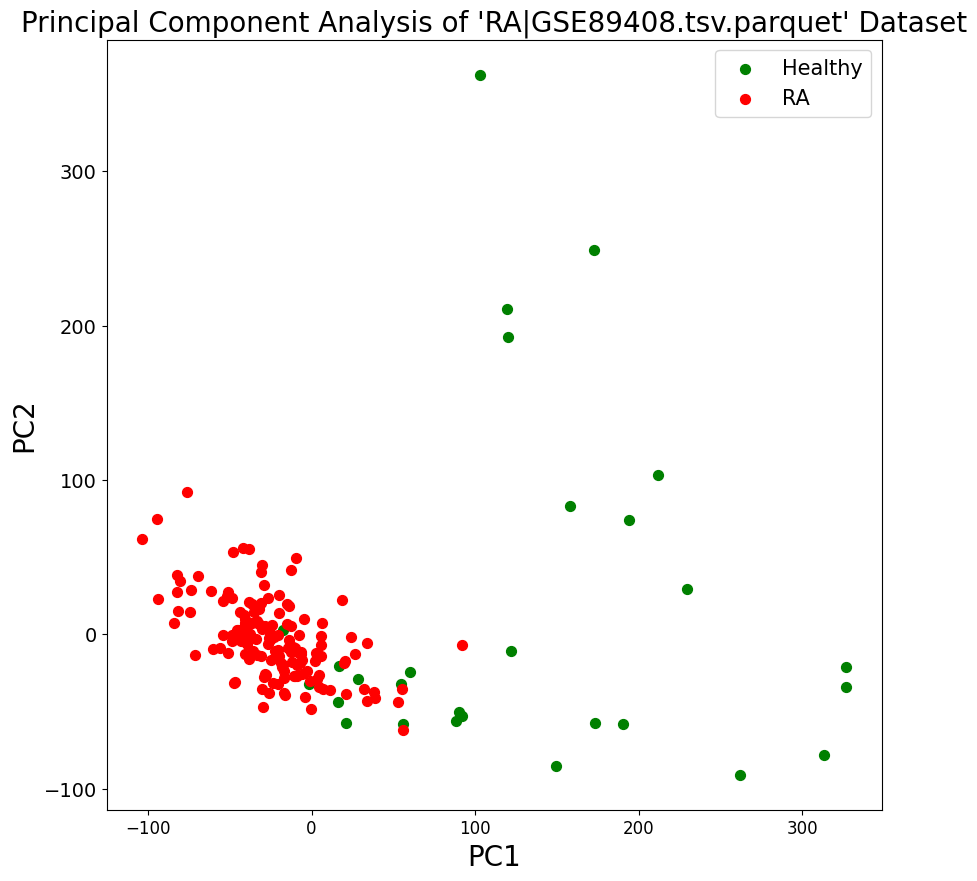

<Figure size 640x480 with 0 Axes>

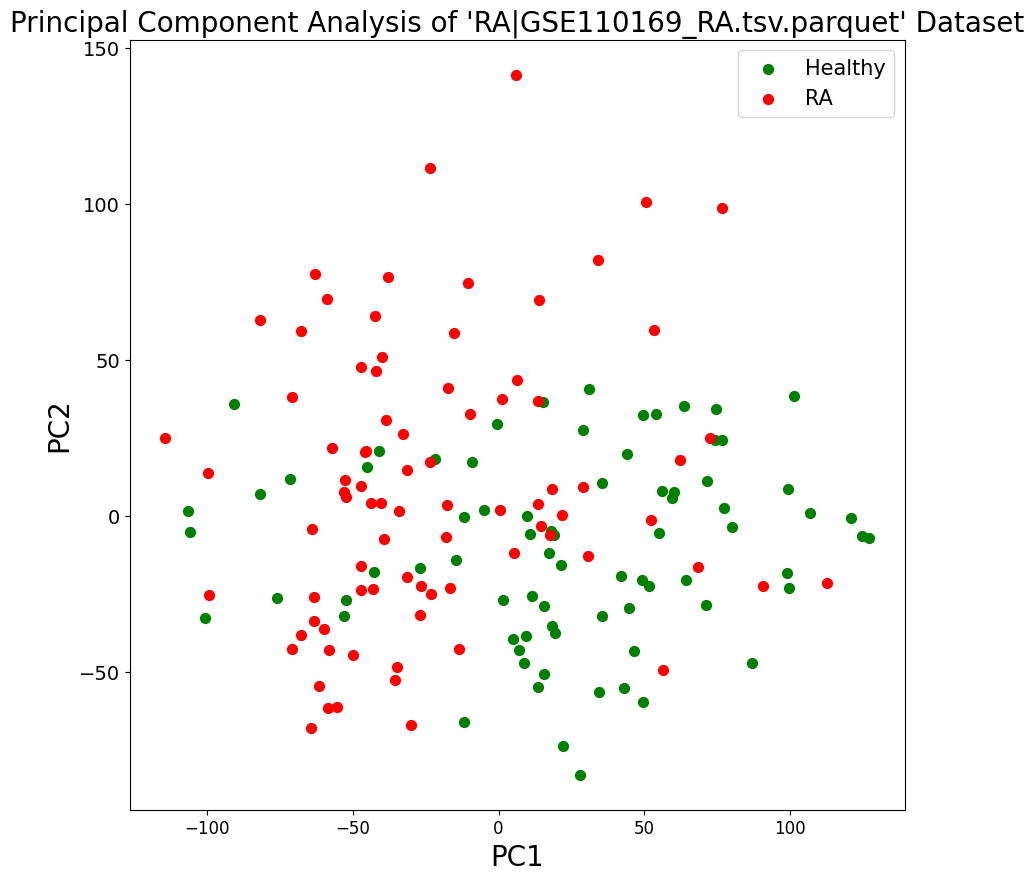

<Figure size 640x480 with 0 Axes>

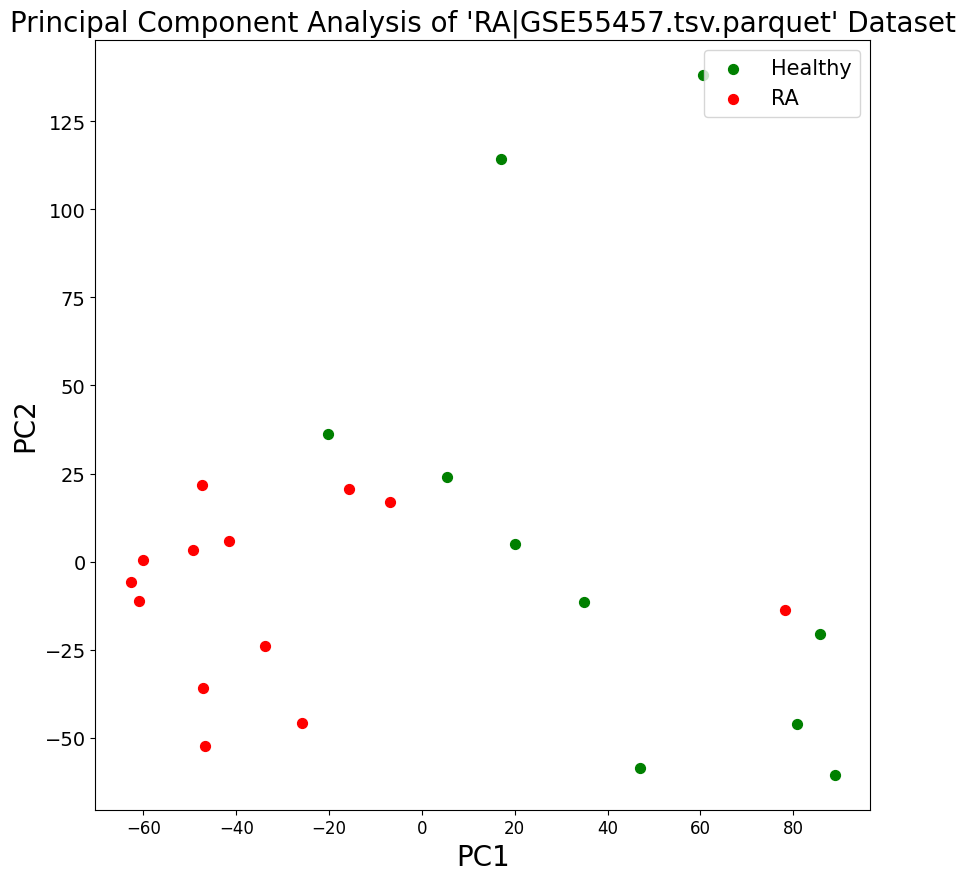

<Figure size 640x480 with 0 Axes>

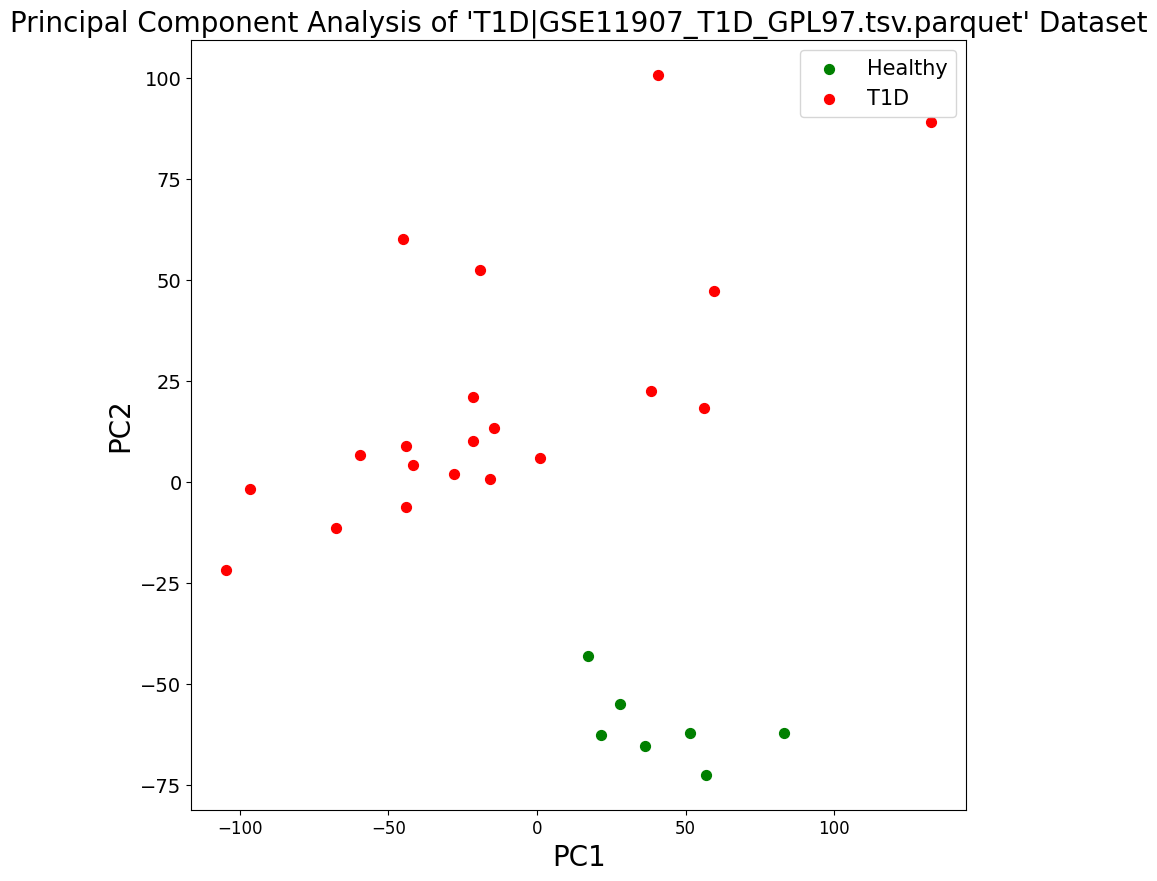

<Figure size 640x480 with 0 Axes>

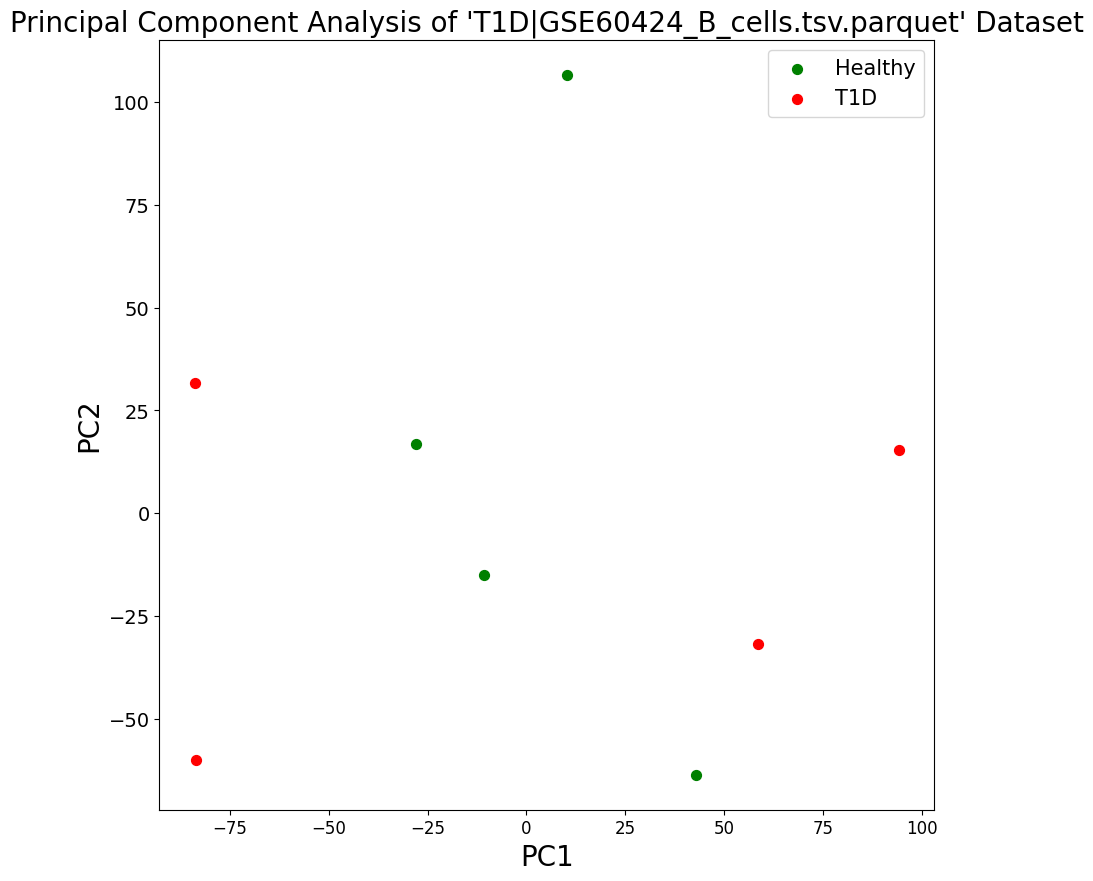

<Figure size 640x480 with 0 Axes>

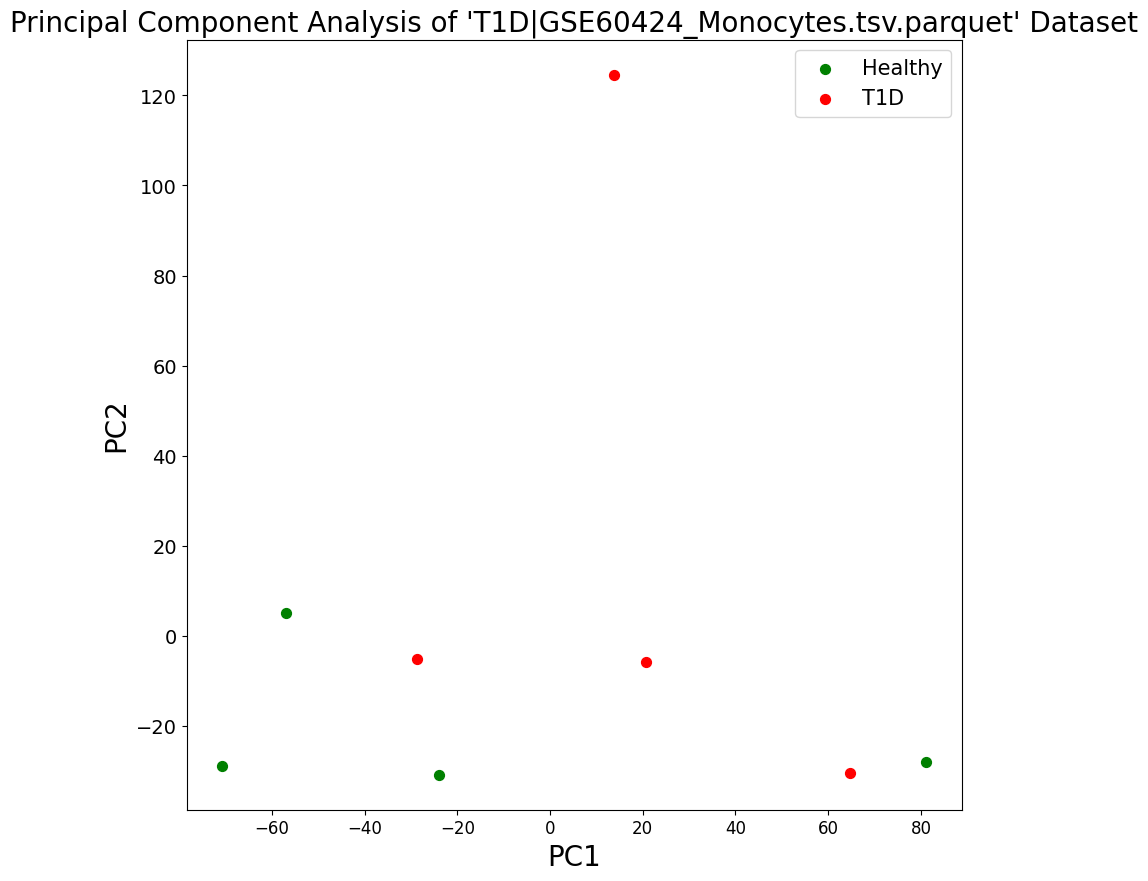

<Figure size 640x480 with 0 Axes>

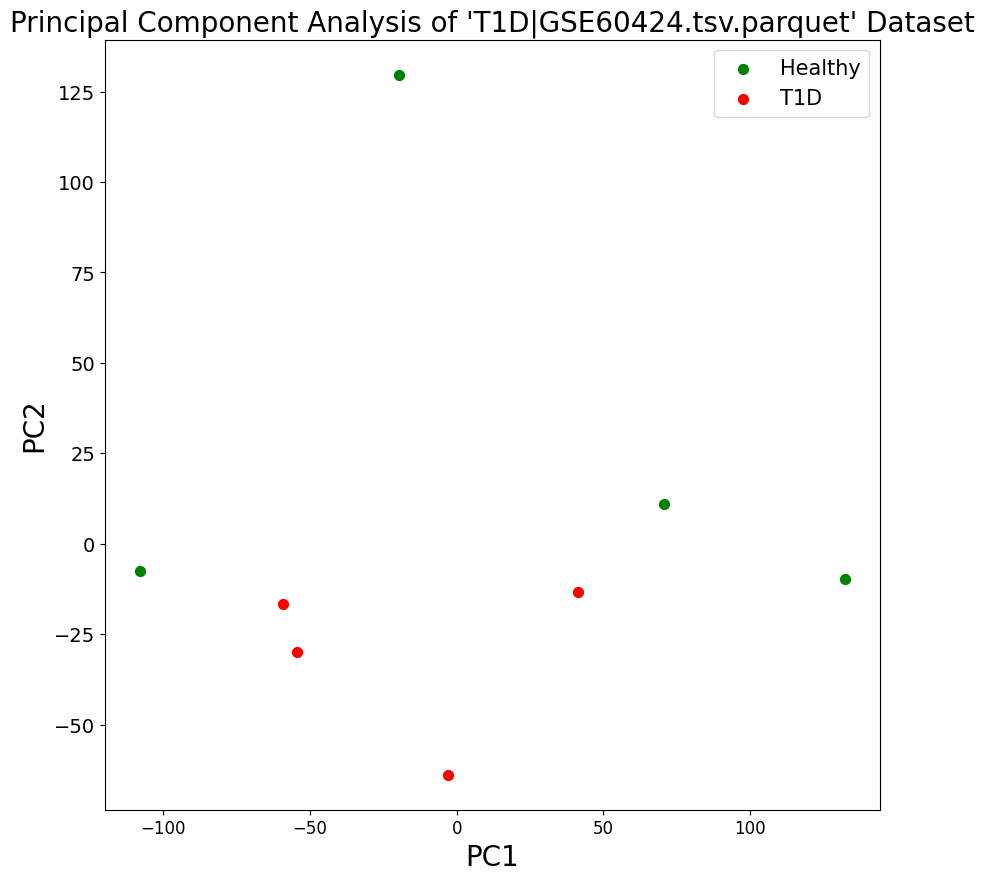

<Figure size 640x480 with 0 Axes>

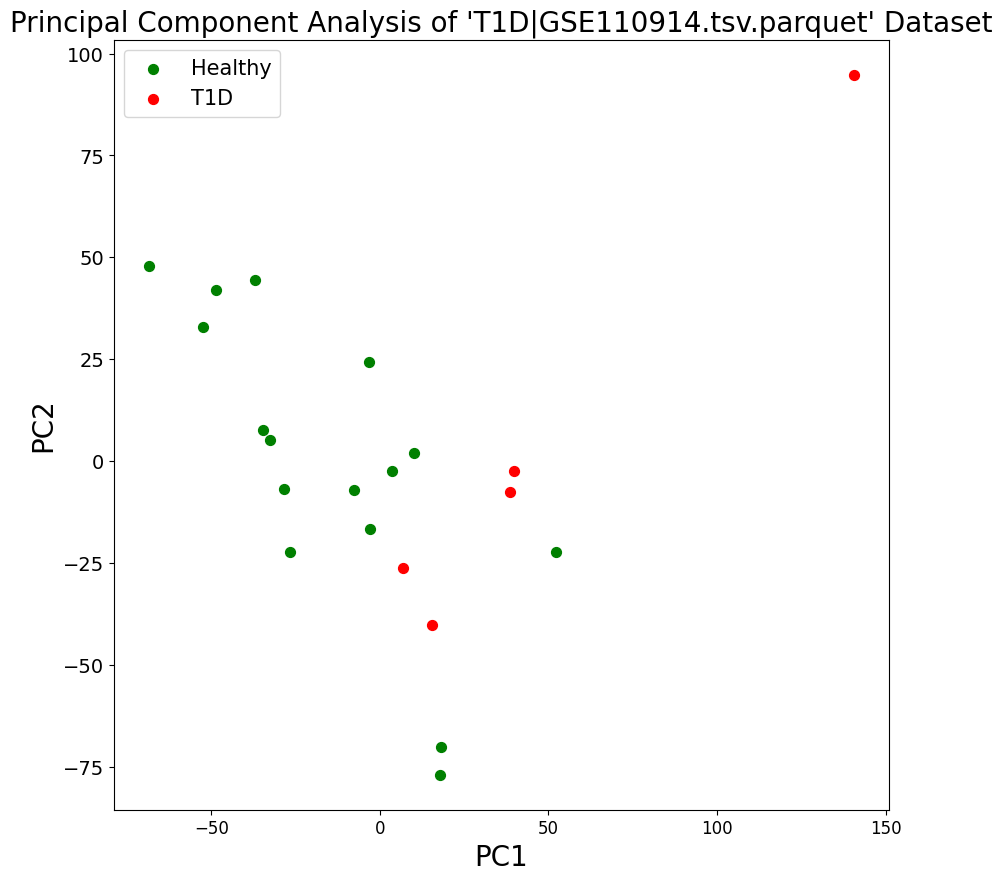

<Figure size 640x480 with 0 Axes>

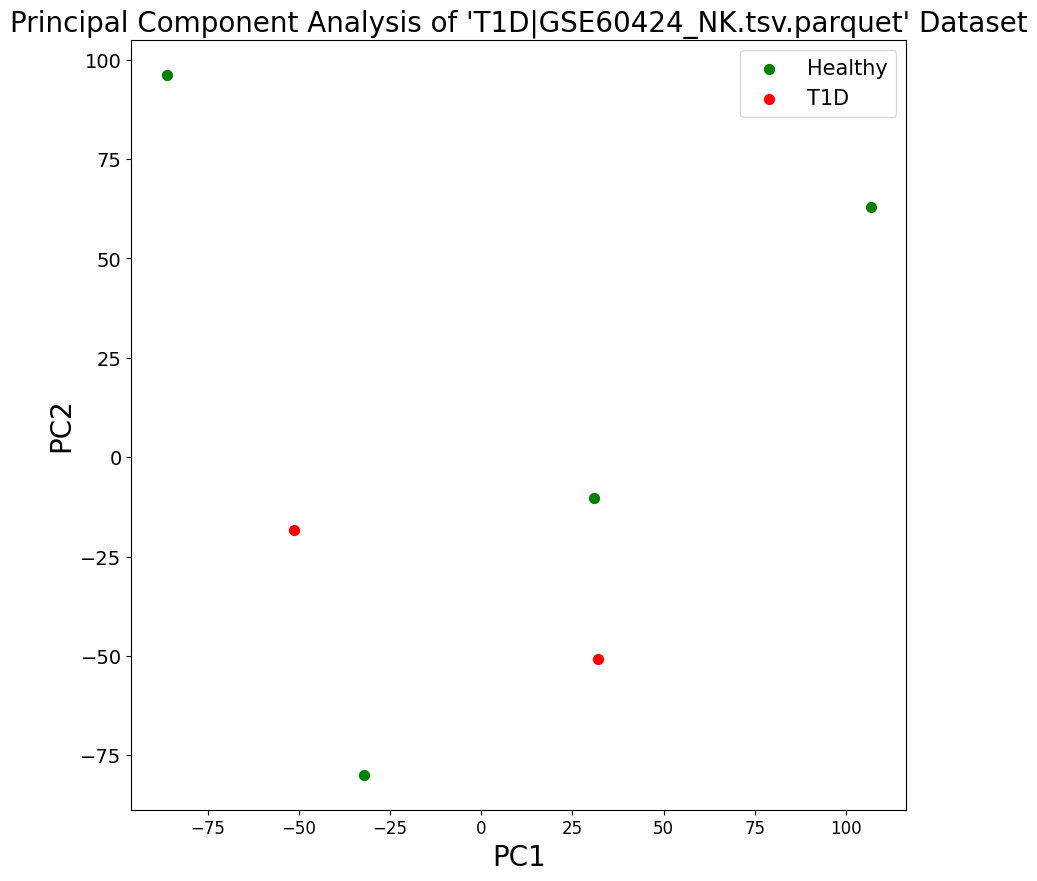

<Figure size 640x480 with 0 Axes>

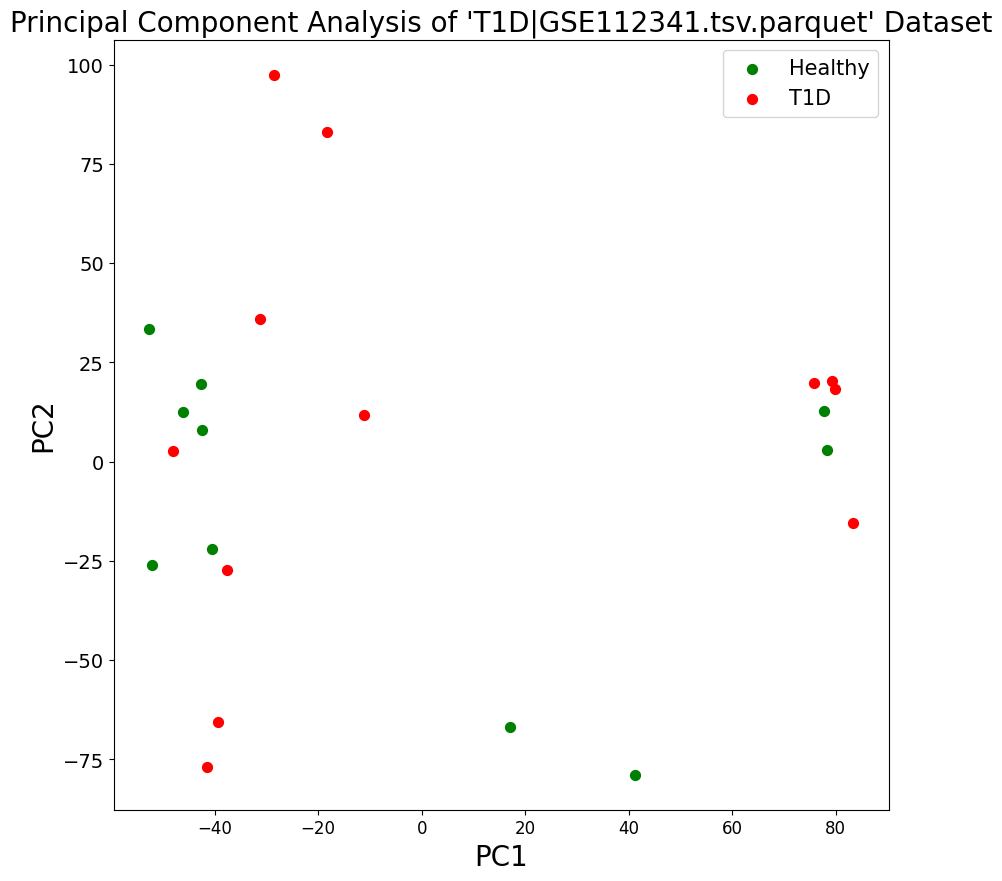

<Figure size 640x480 with 0 Axes>

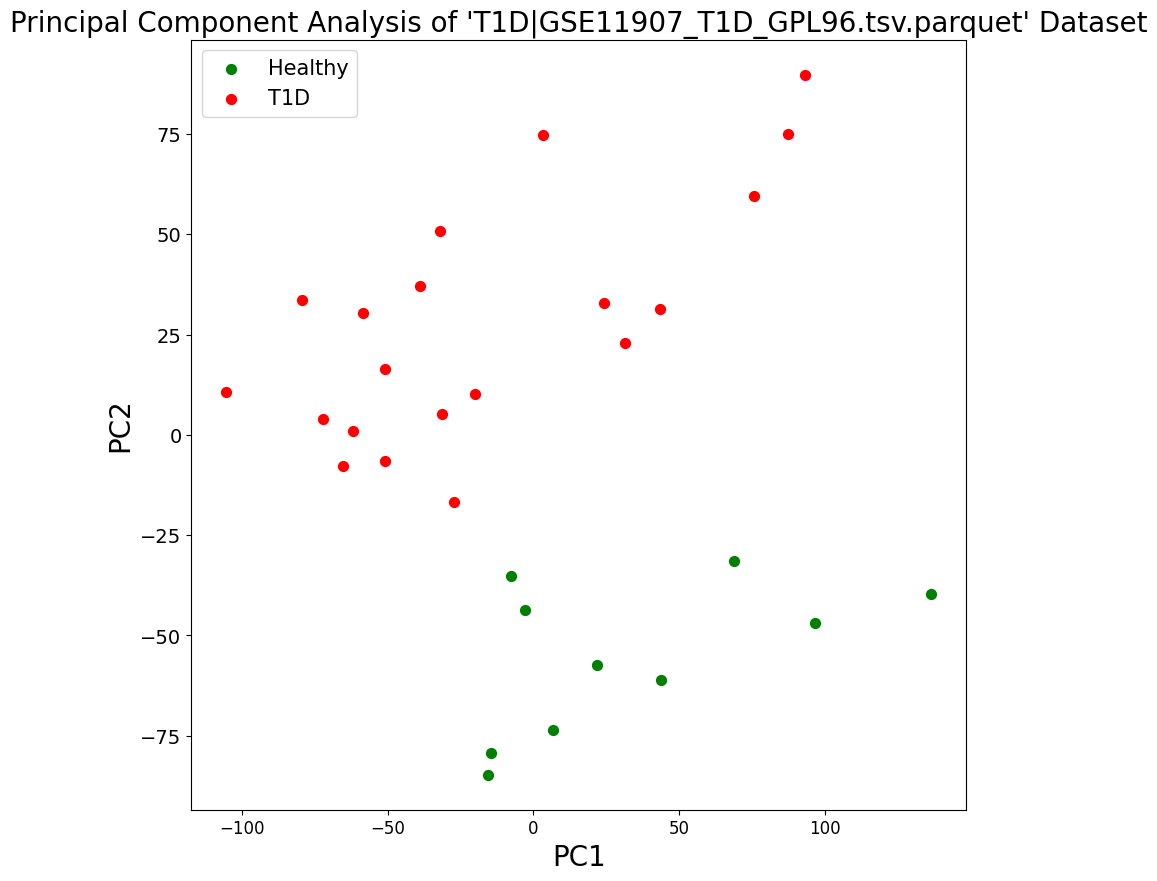

<Figure size 640x480 with 0 Axes>

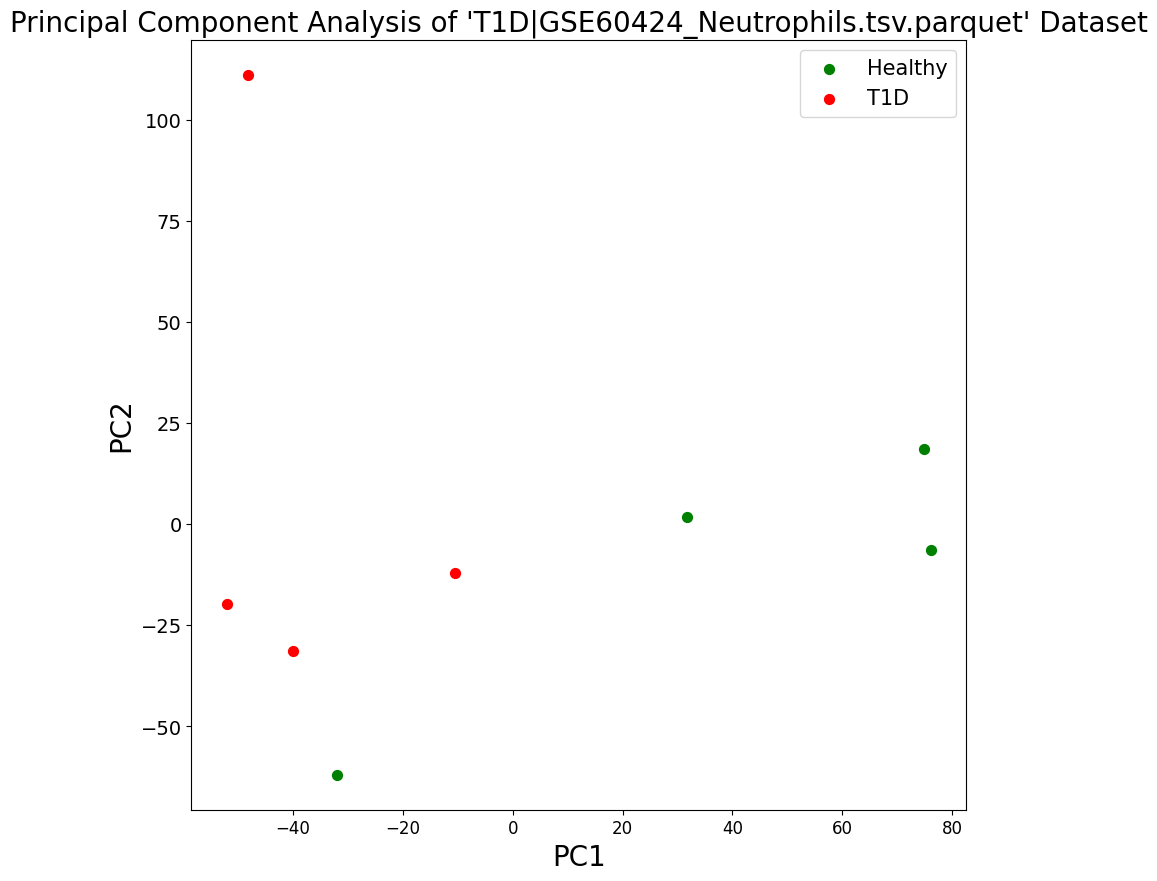

<Figure size 640x480 with 0 Axes>

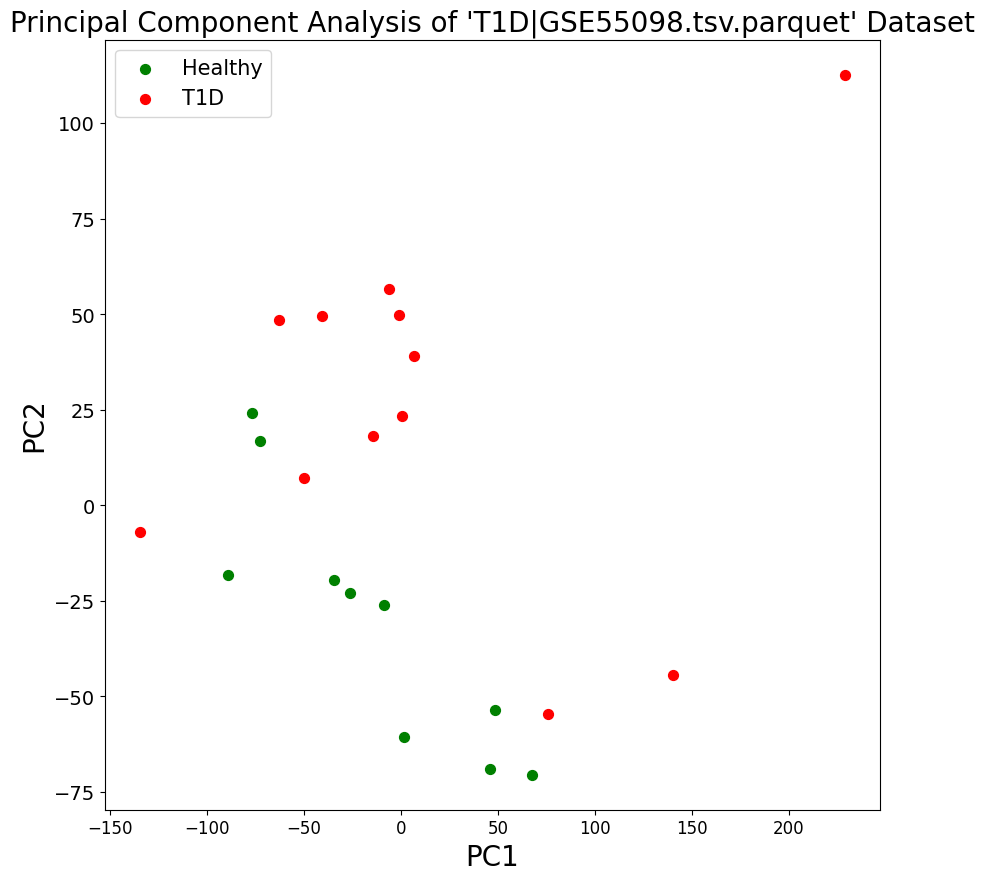

<Figure size 640x480 with 0 Axes>

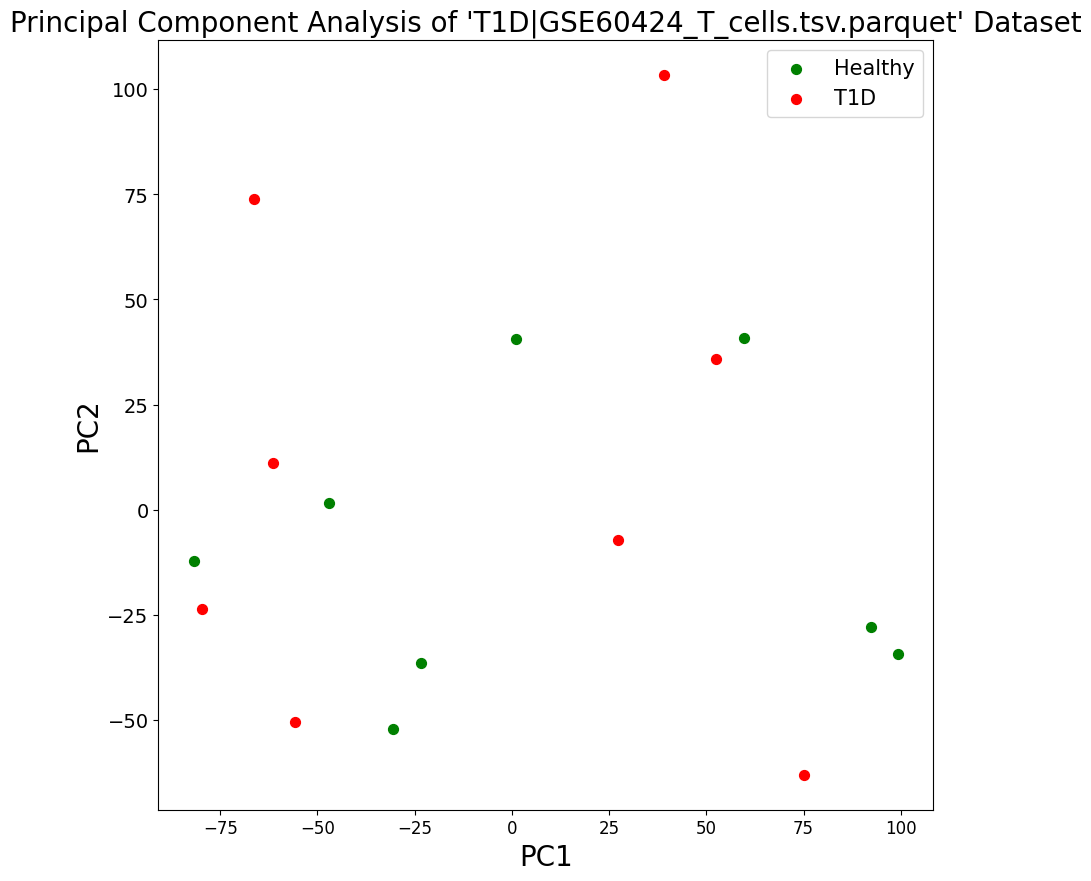

<Figure size 640x480 with 0 Axes>

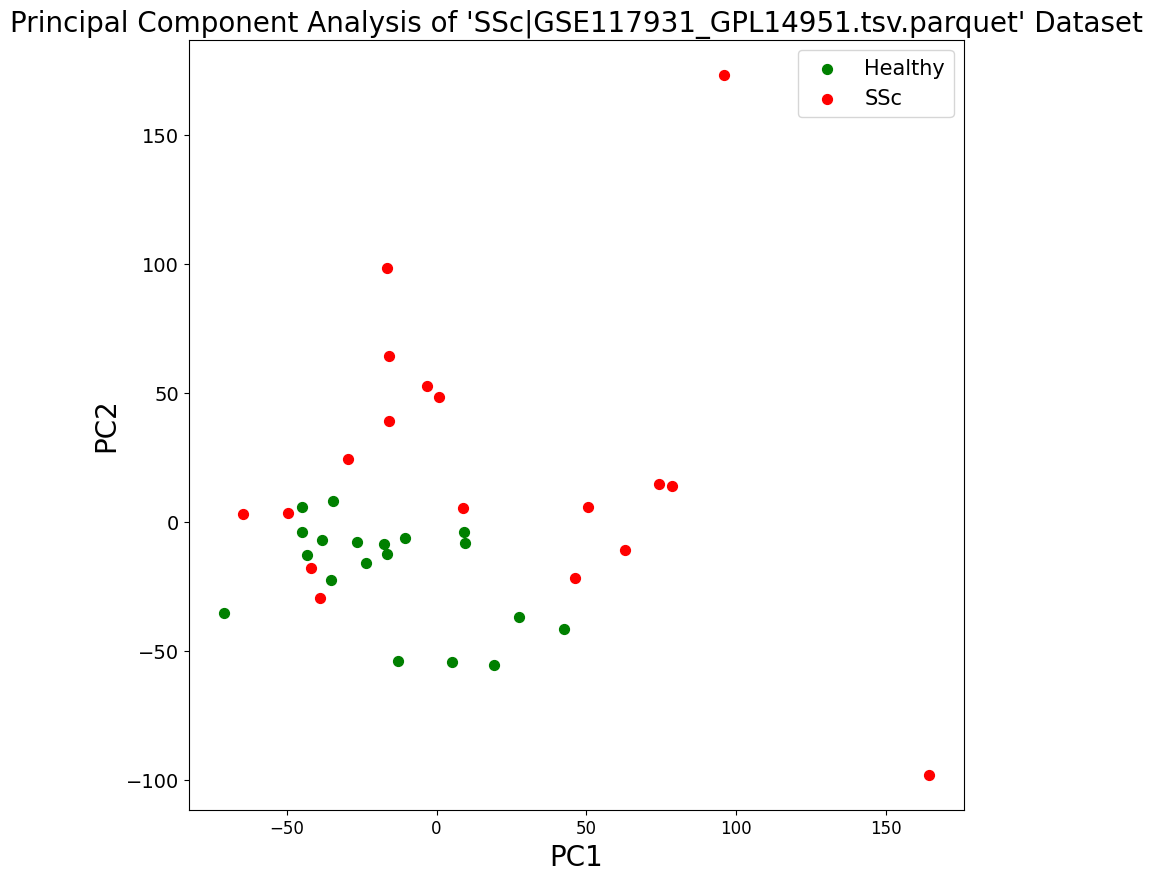

<Figure size 640x480 with 0 Axes>

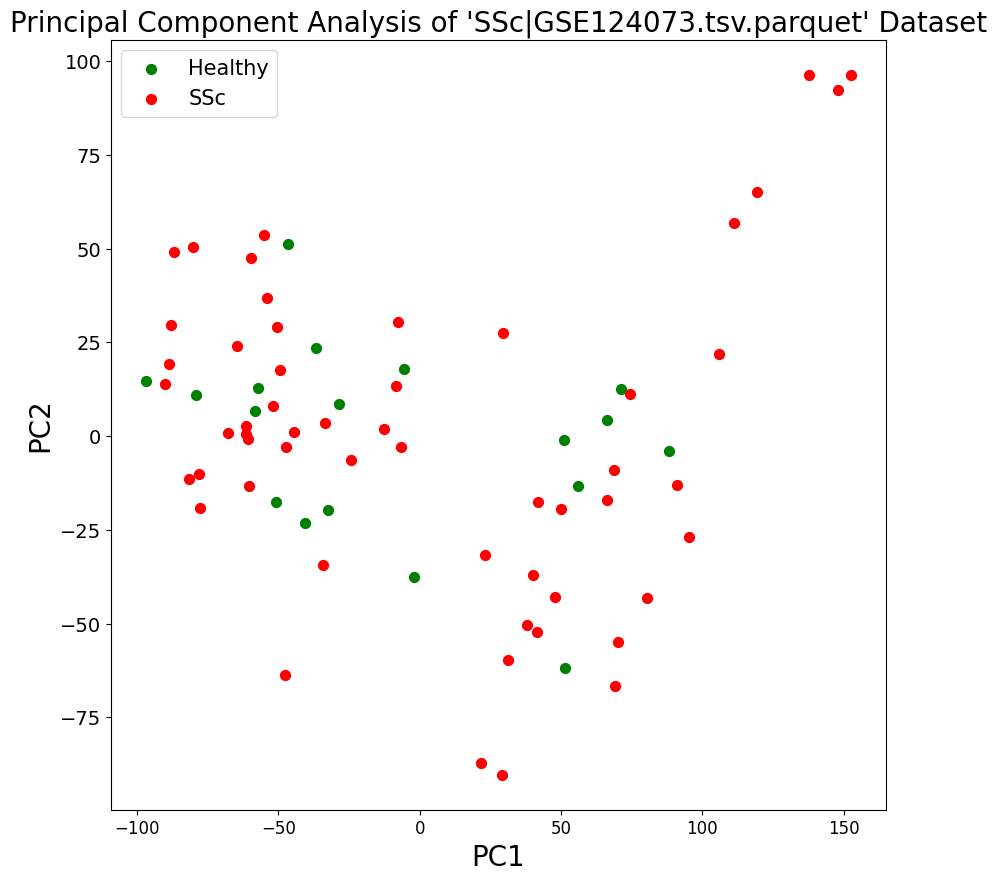

<Figure size 640x480 with 0 Axes>

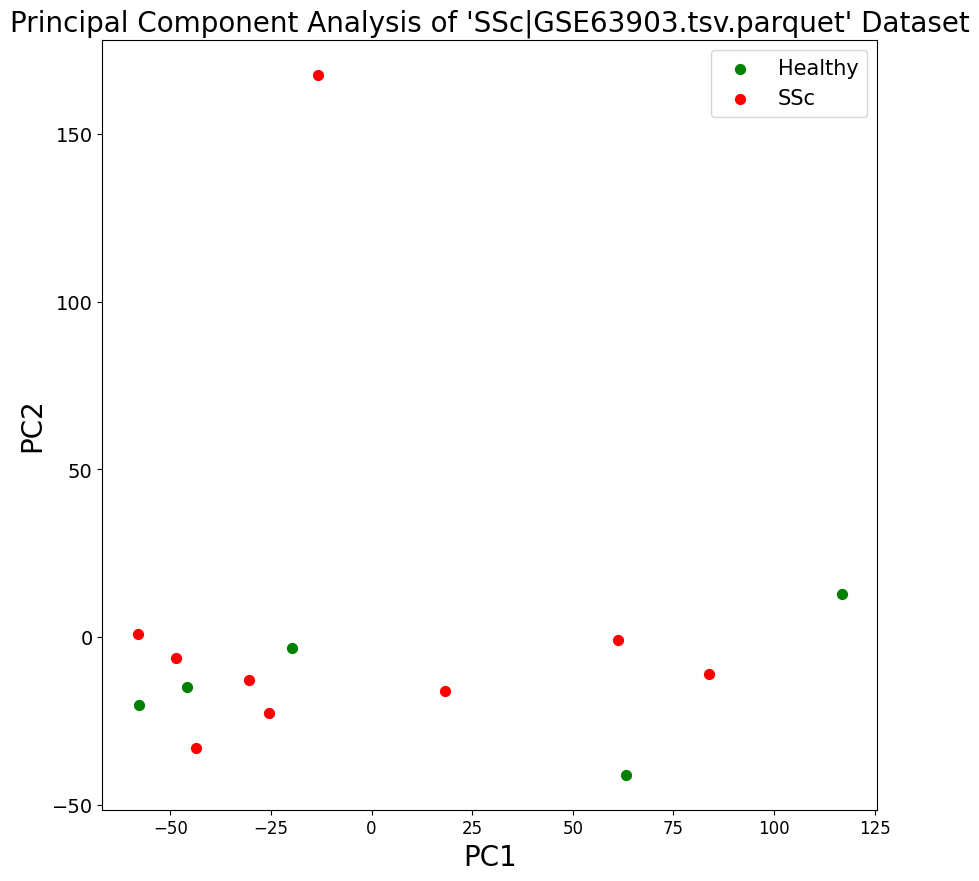

<Figure size 640x480 with 0 Axes>

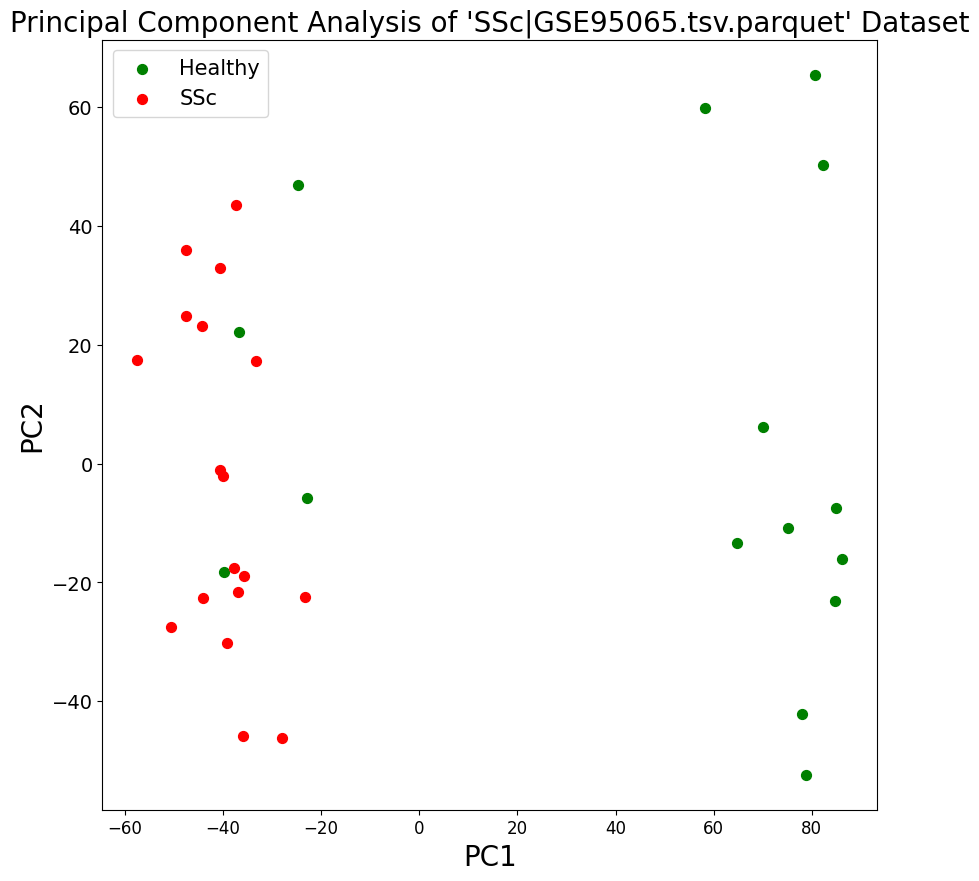

<Figure size 640x480 with 0 Axes>

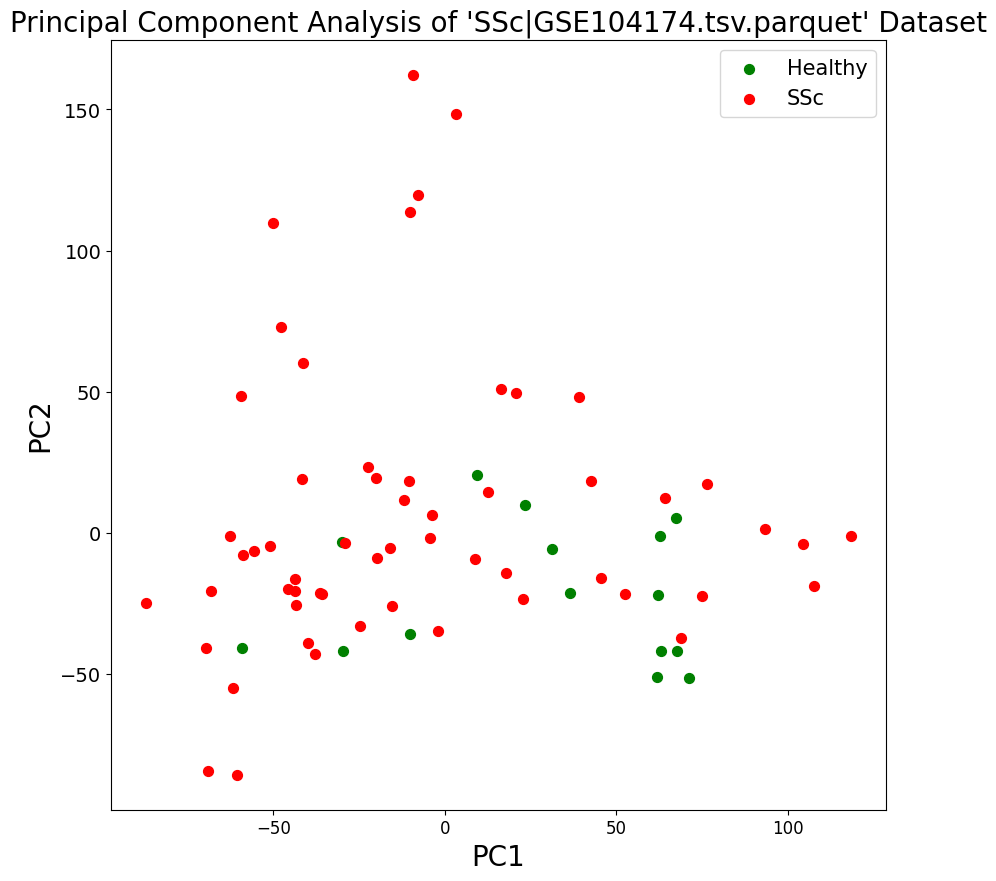

<Figure size 640x480 with 0 Axes>

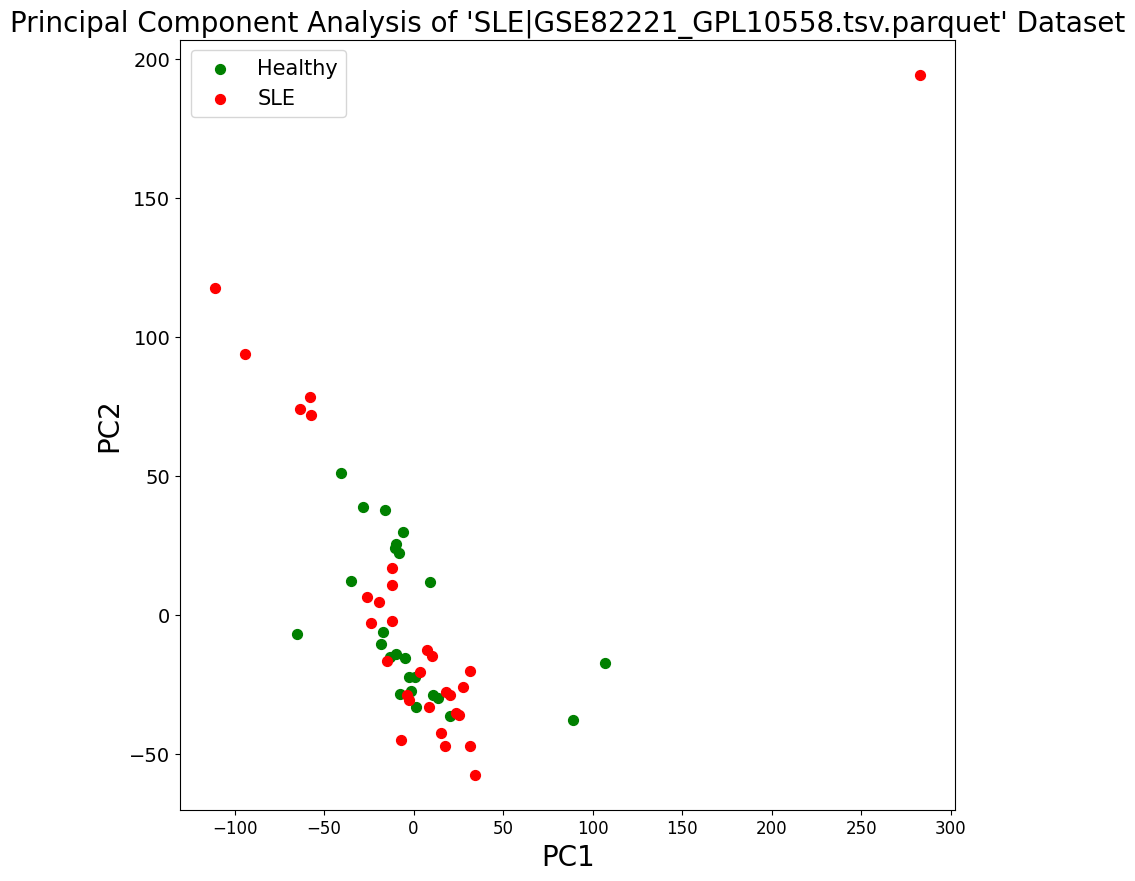

<Figure size 640x480 with 0 Axes>

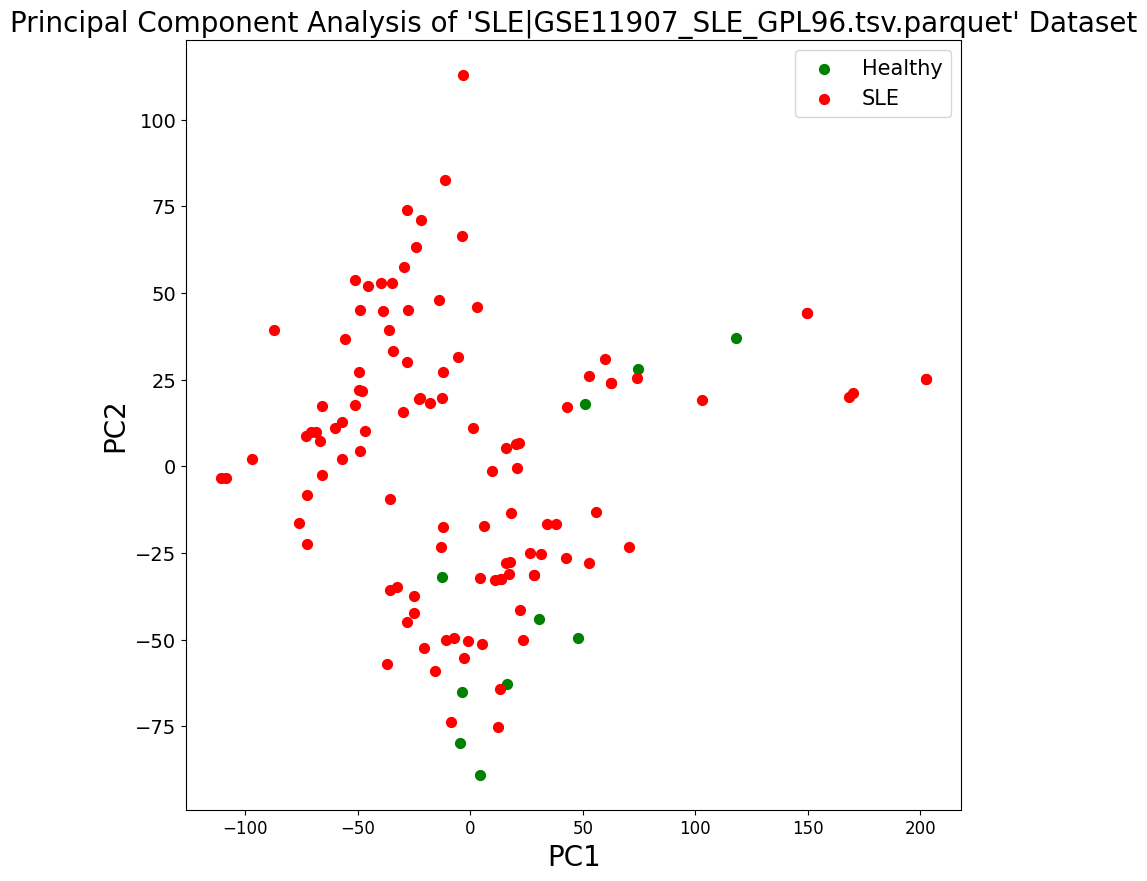

<Figure size 640x480 with 0 Axes>

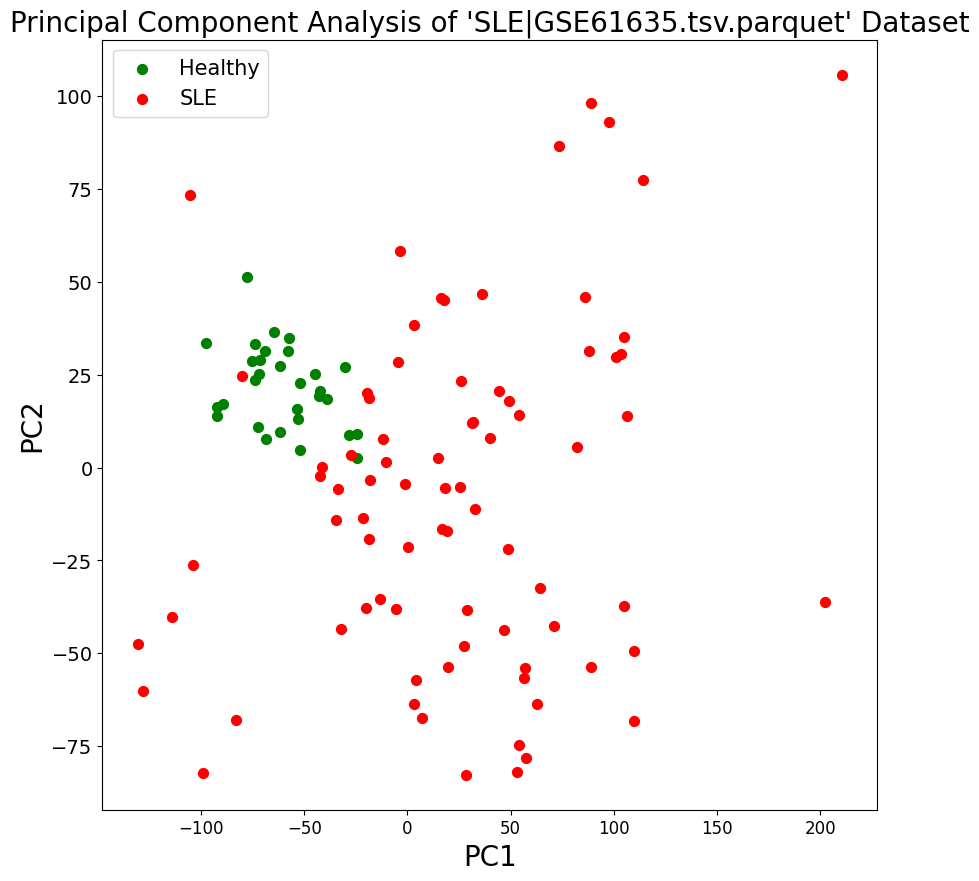

<Figure size 640x480 with 0 Axes>

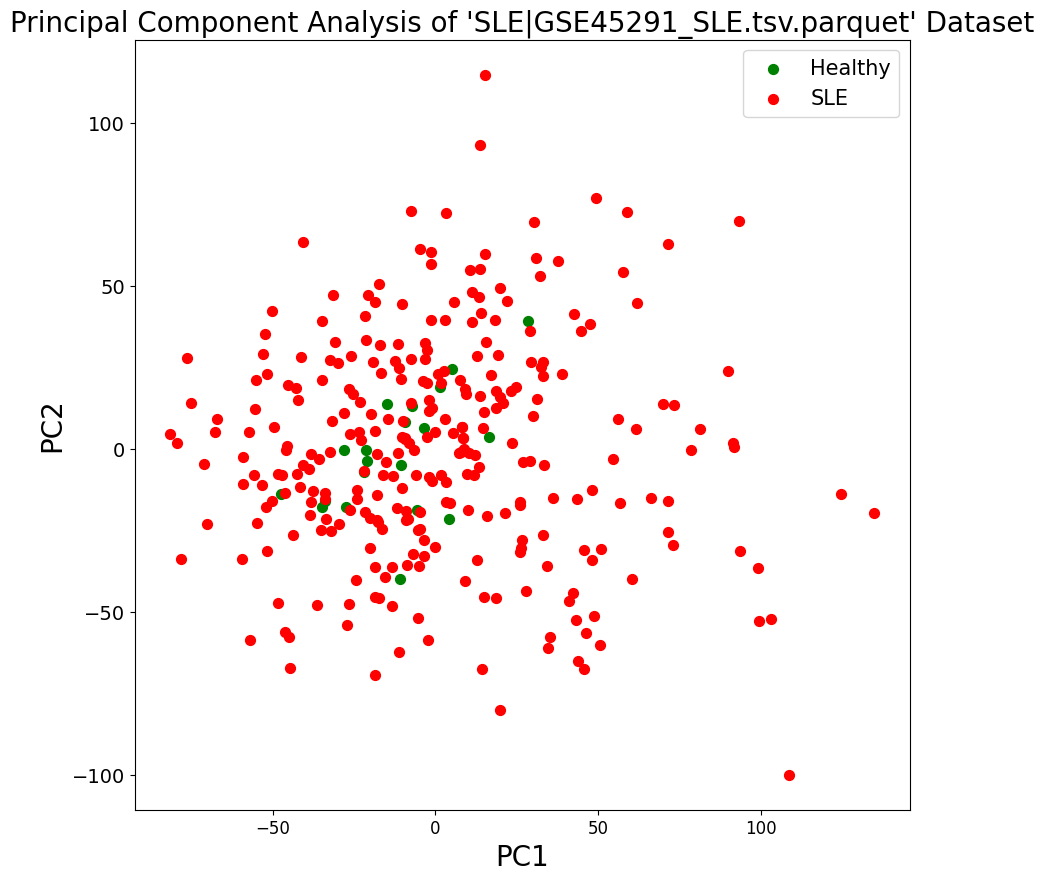

<Figure size 640x480 with 0 Axes>

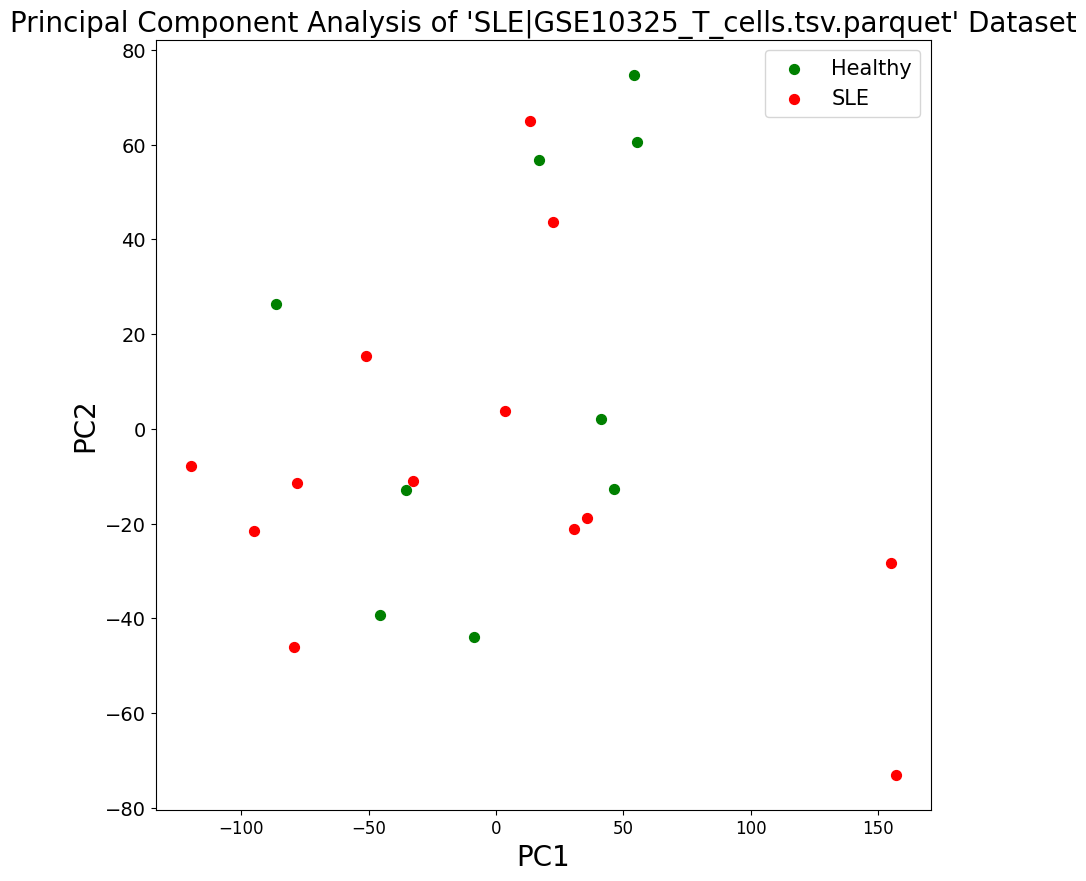

<Figure size 640x480 with 0 Axes>

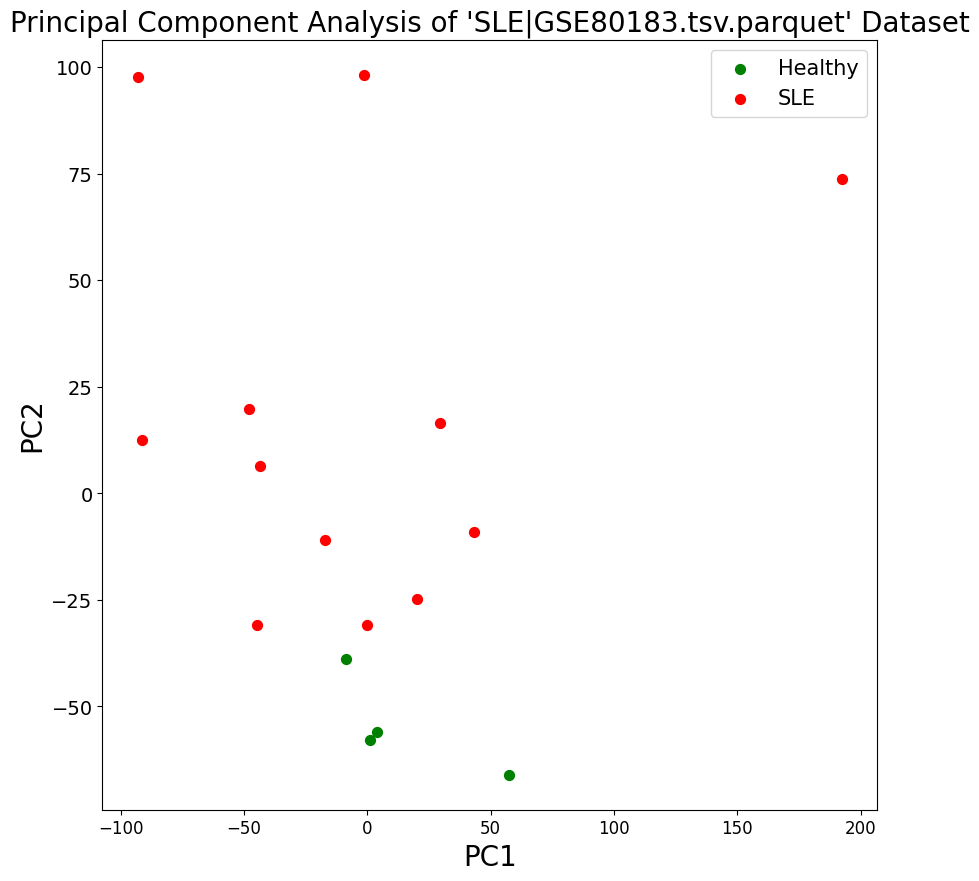

<Figure size 640x480 with 0 Axes>

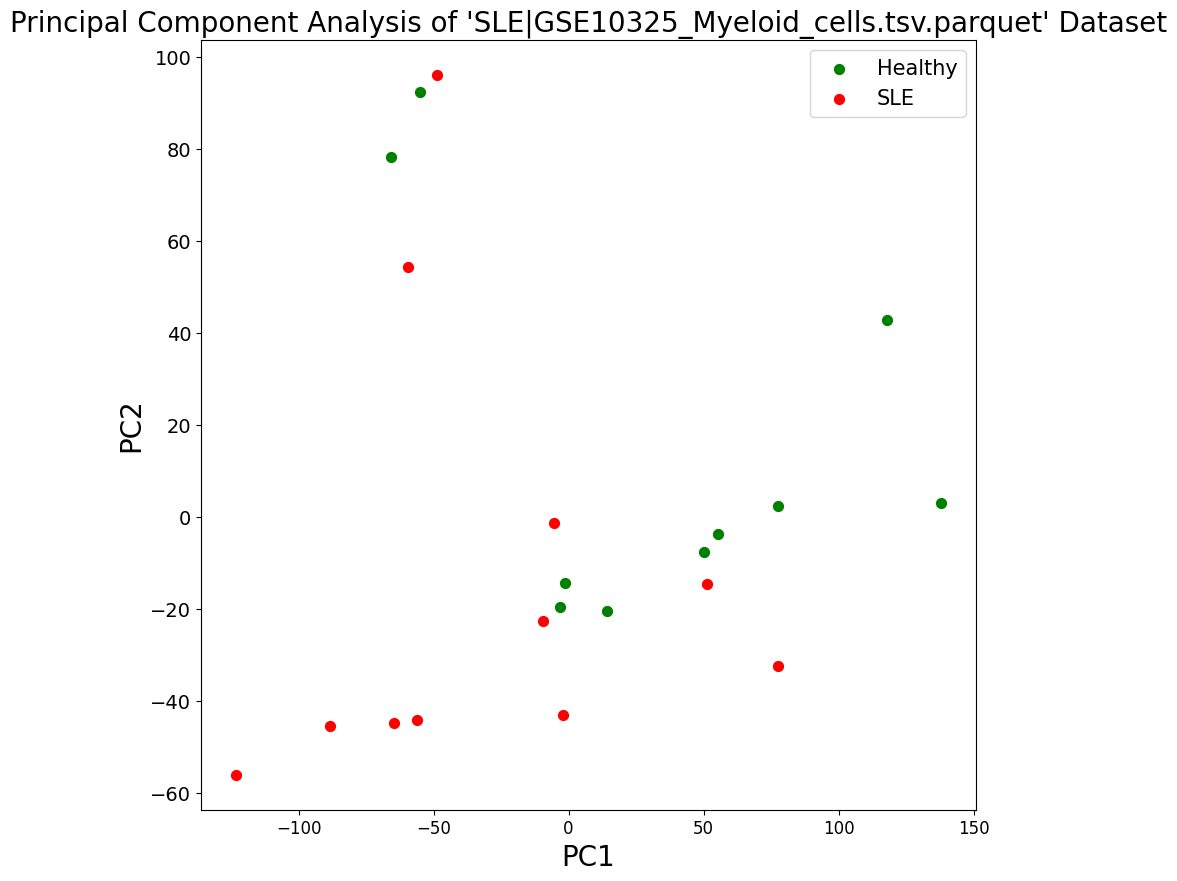

<Figure size 640x480 with 0 Axes>

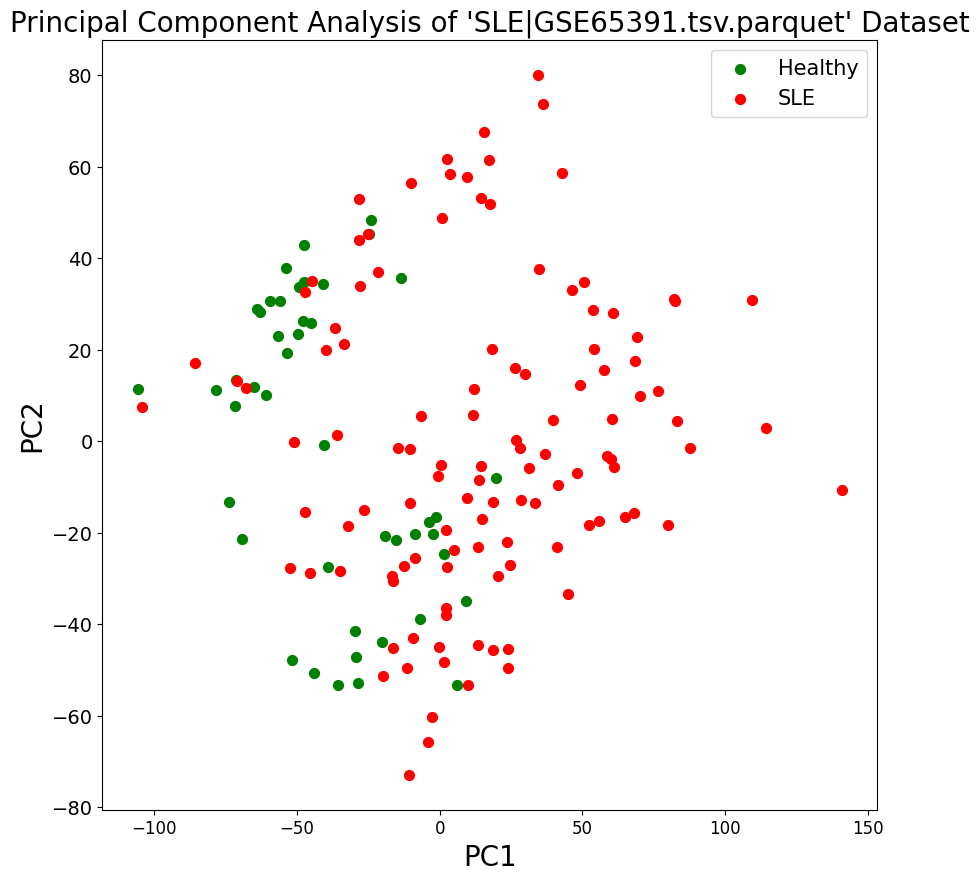

<Figure size 640x480 with 0 Axes>

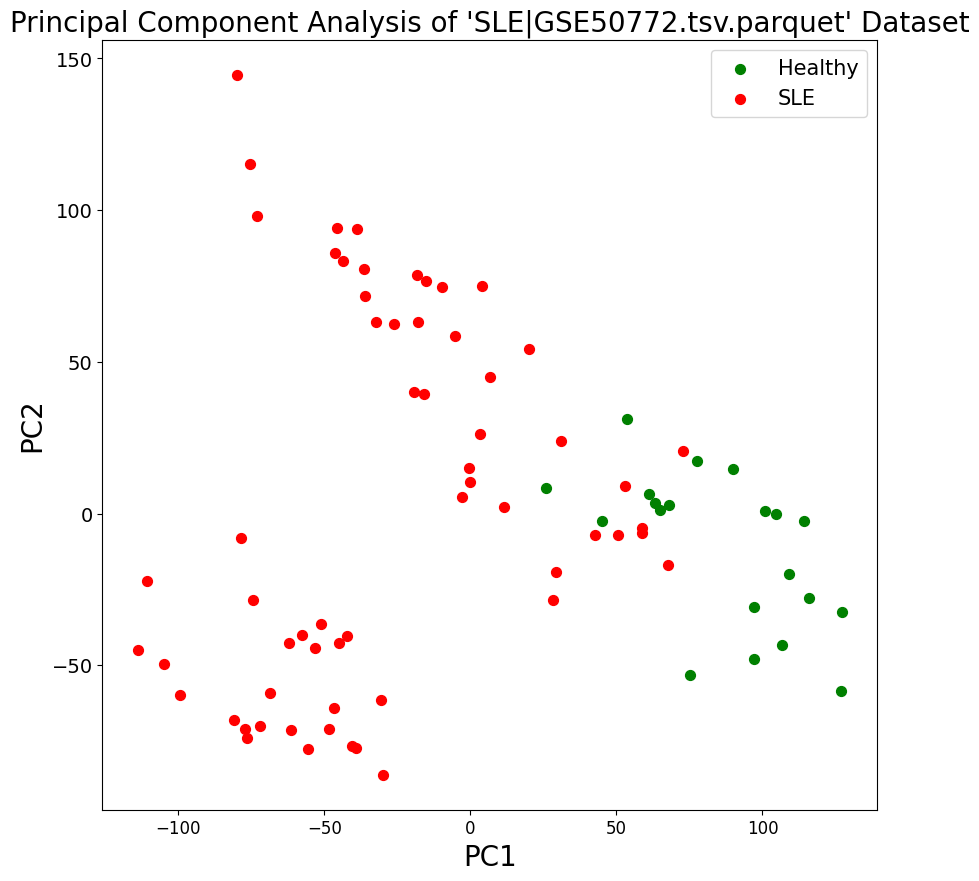

<Figure size 640x480 with 0 Axes>

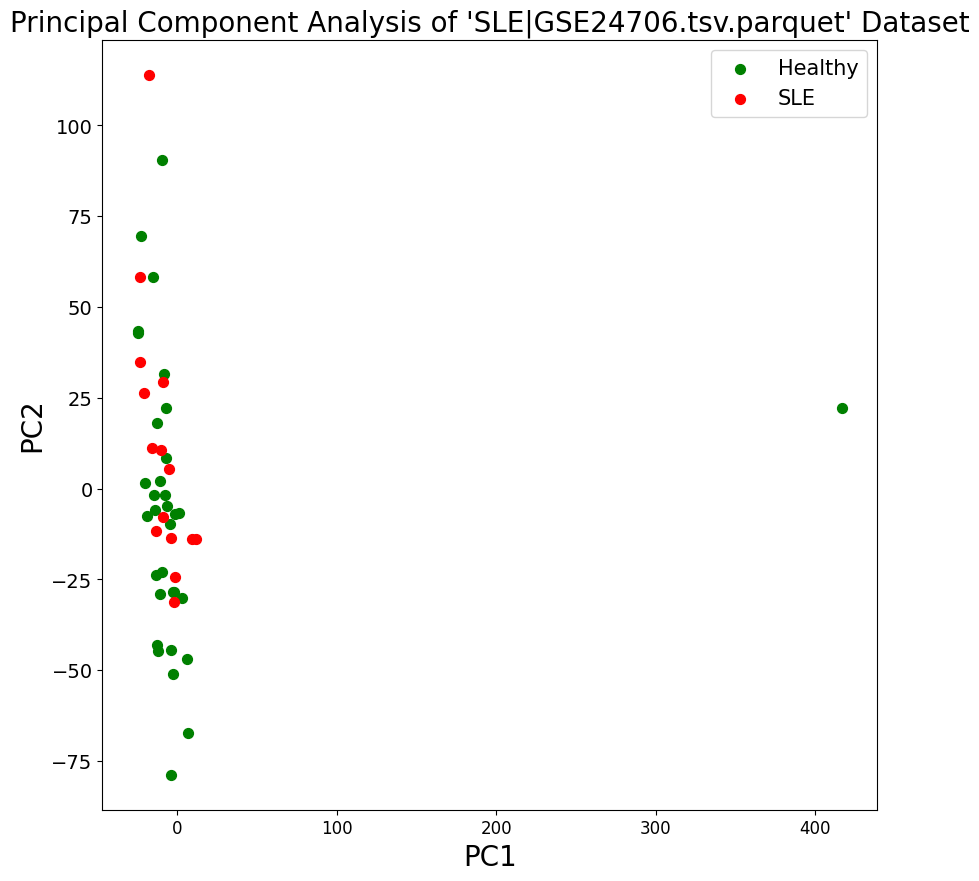

<Figure size 640x480 with 0 Axes>

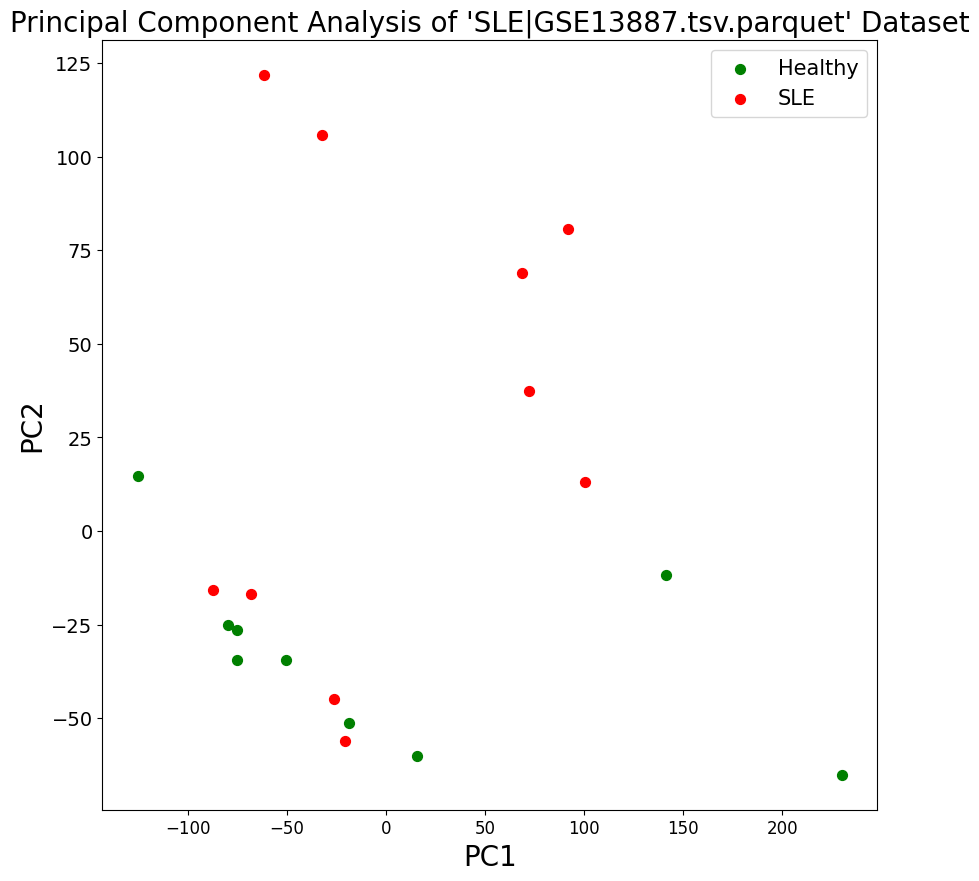

<Figure size 640x480 with 0 Axes>

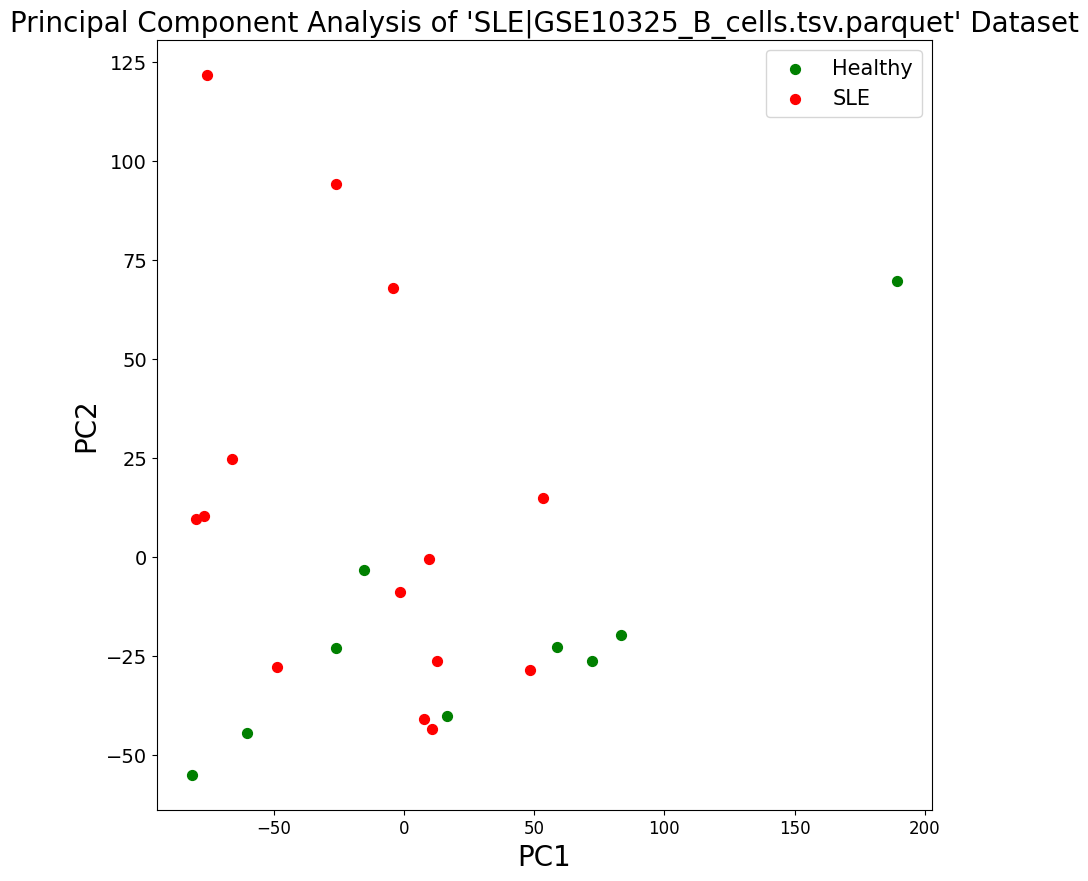

<Figure size 640x480 with 0 Axes>

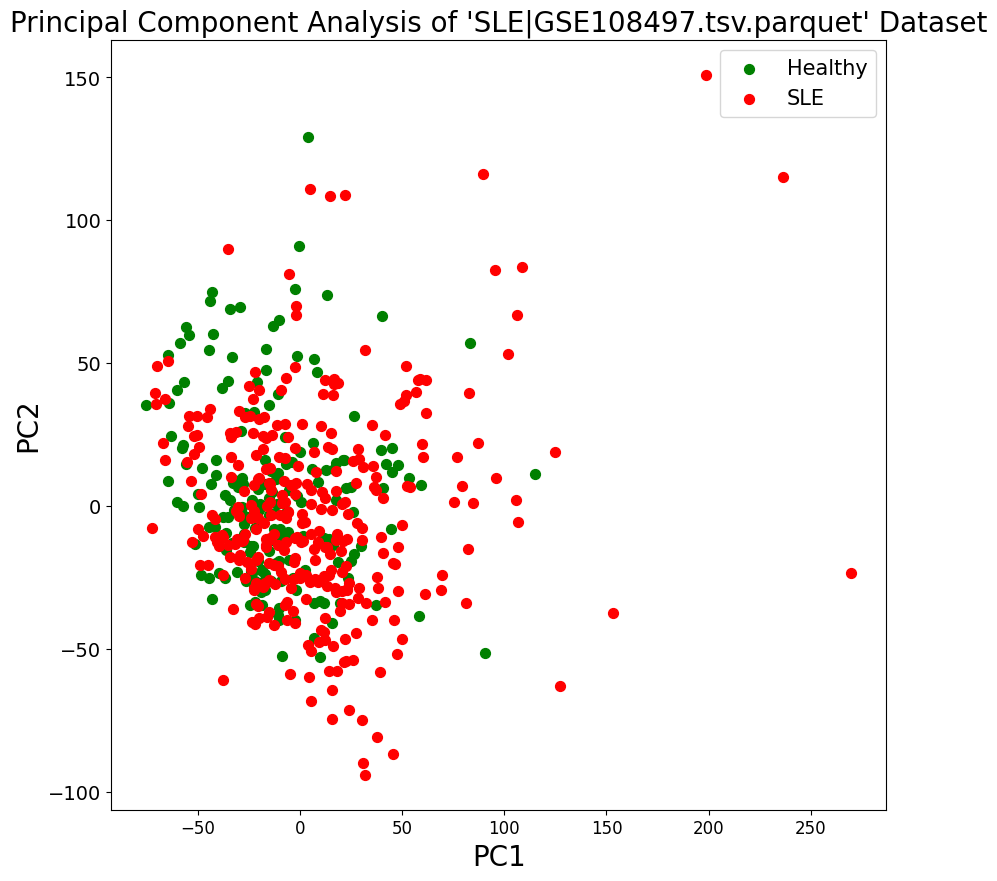

<Figure size 640x480 with 0 Axes>

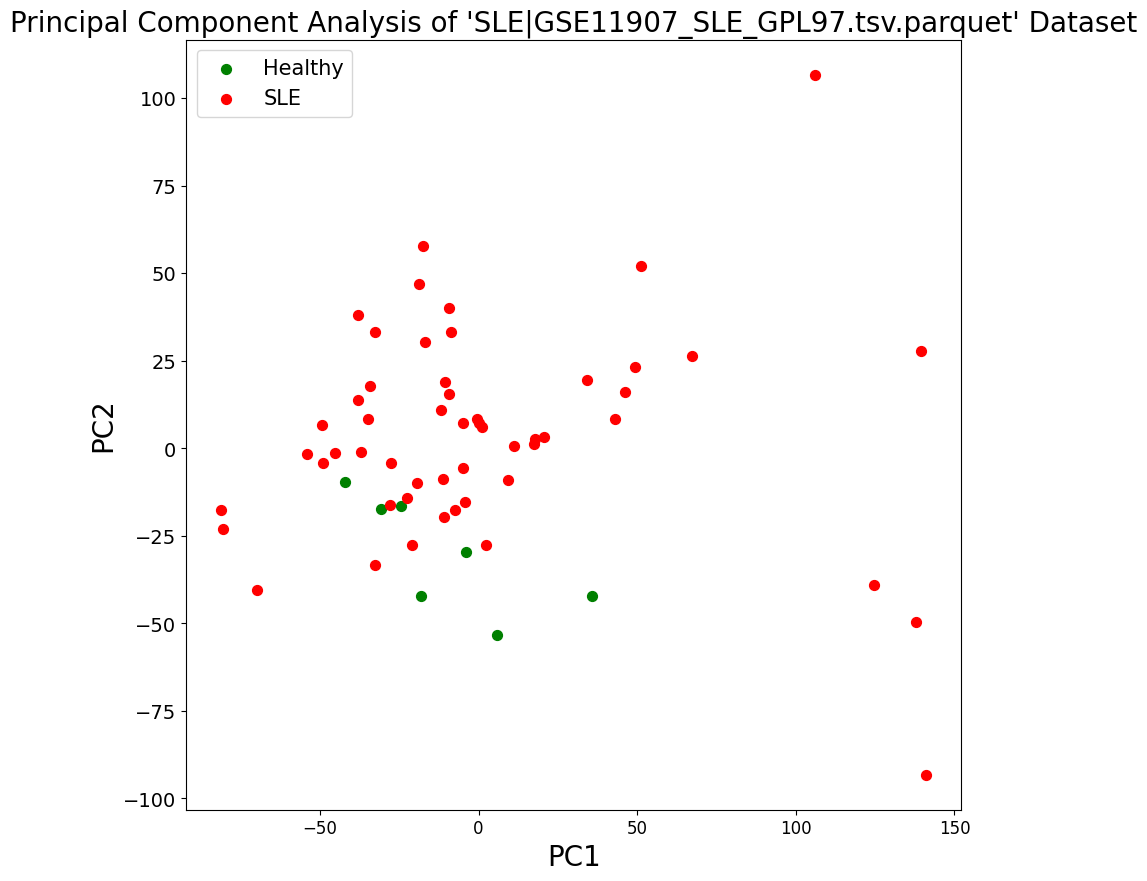

<Figure size 640x480 with 0 Axes>

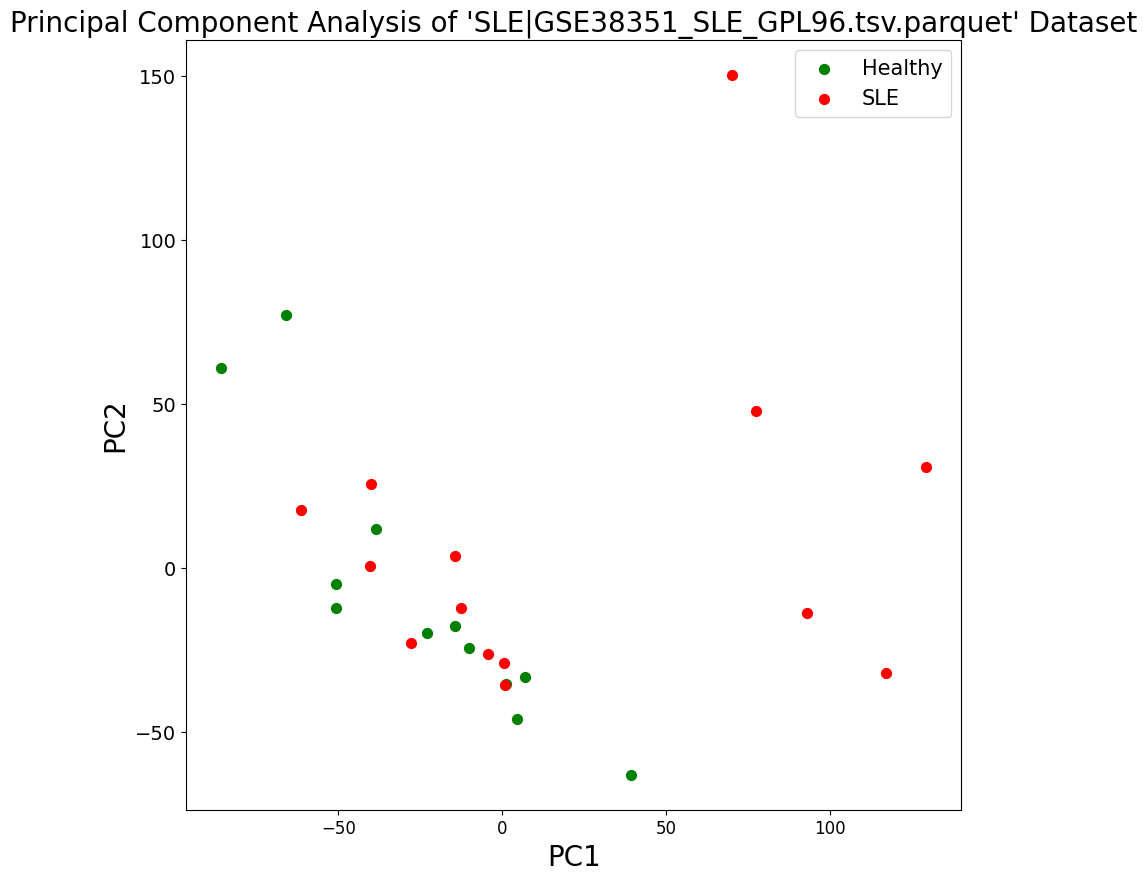

<Figure size 640x480 with 0 Axes>

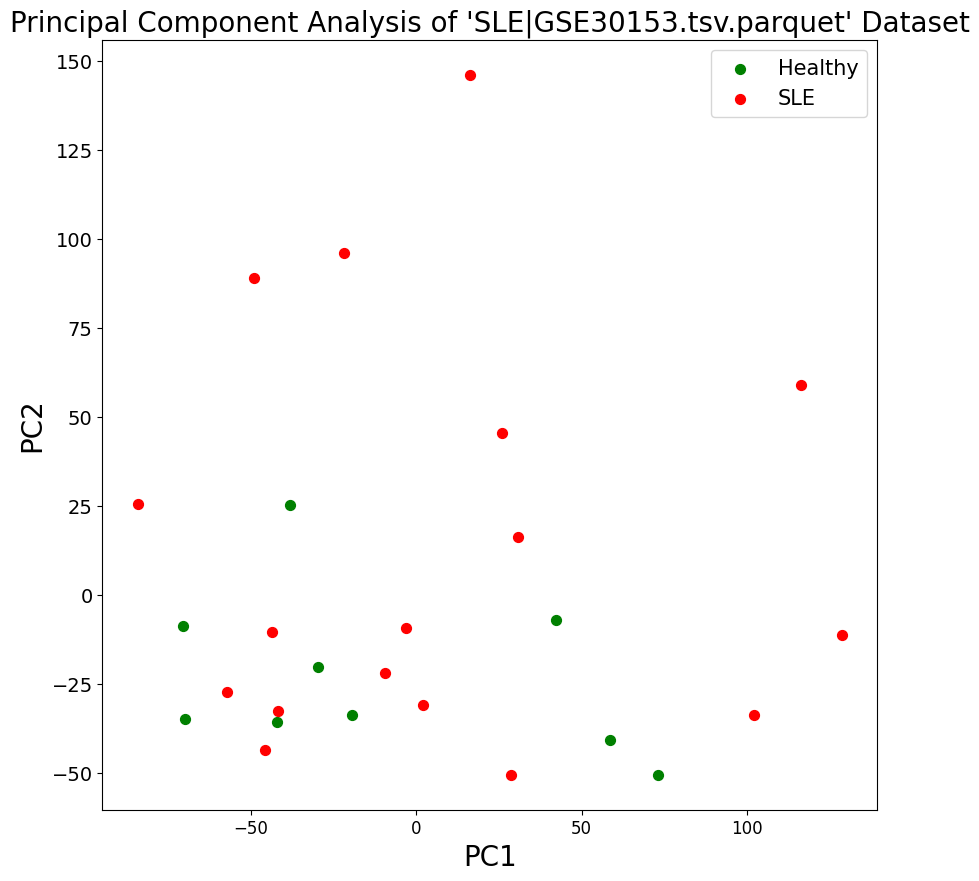

<Figure size 640x480 with 0 Axes>

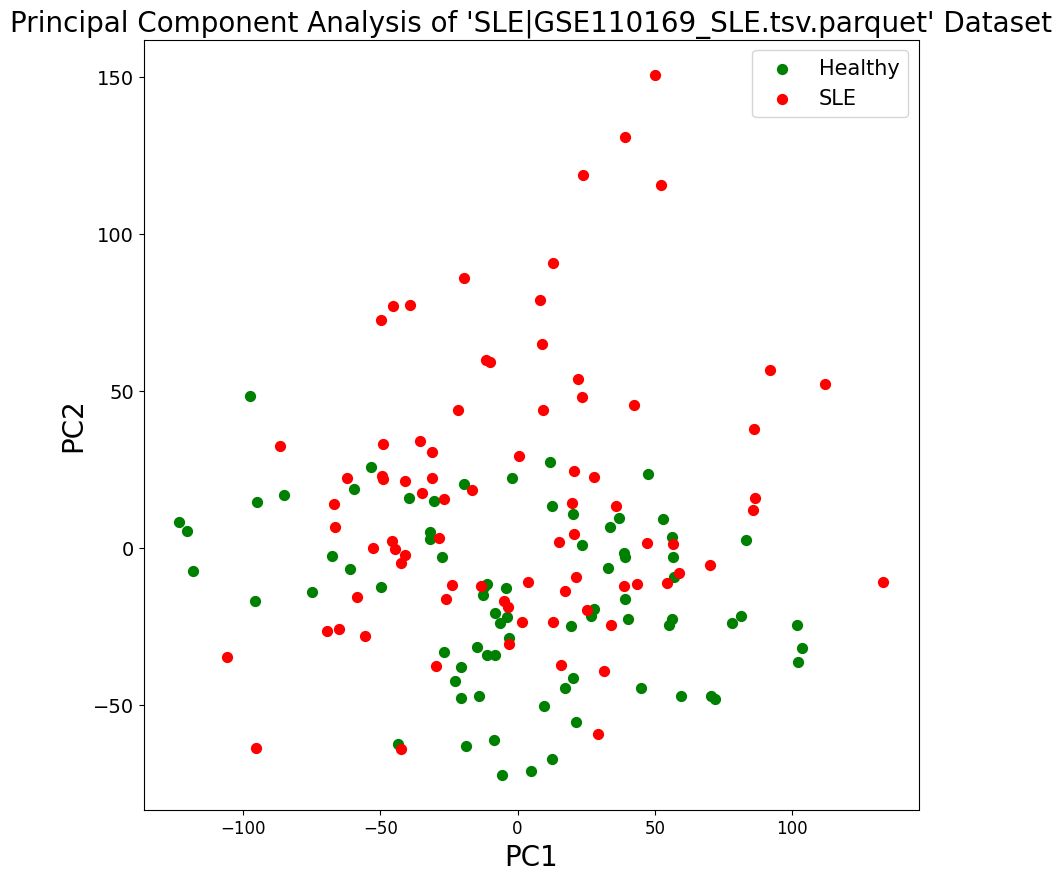

<Figure size 640x480 with 0 Axes>

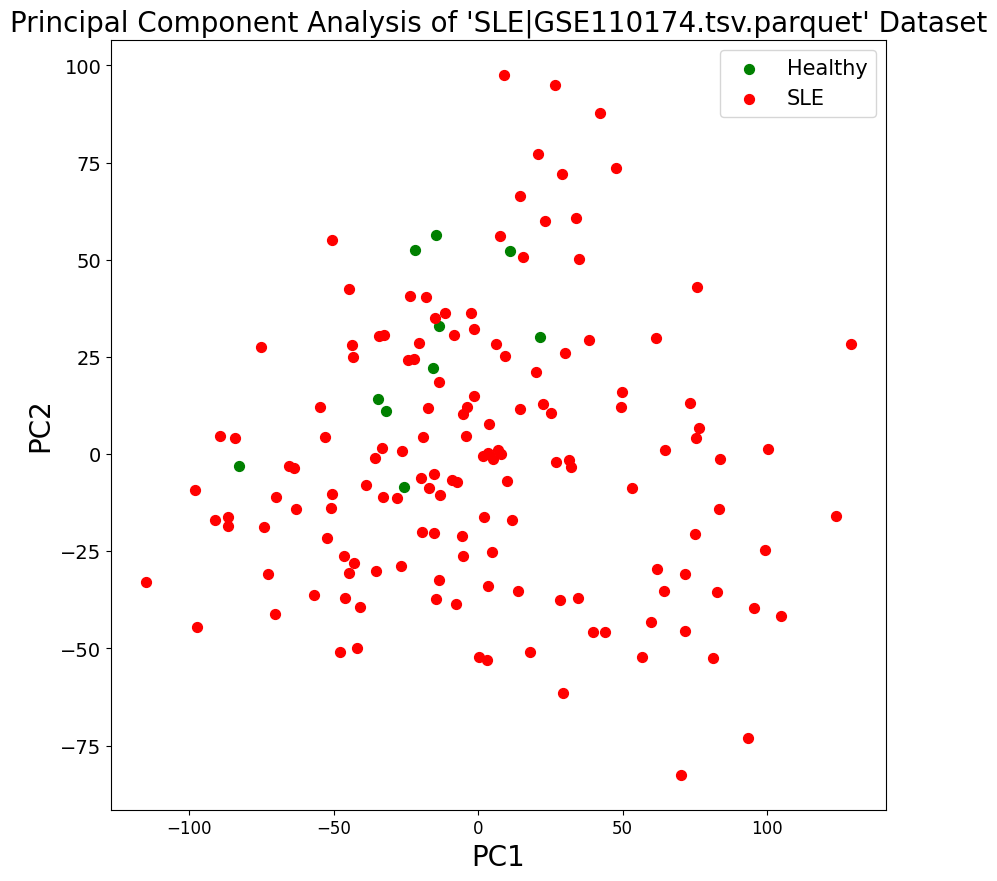

<Figure size 640x480 with 0 Axes>

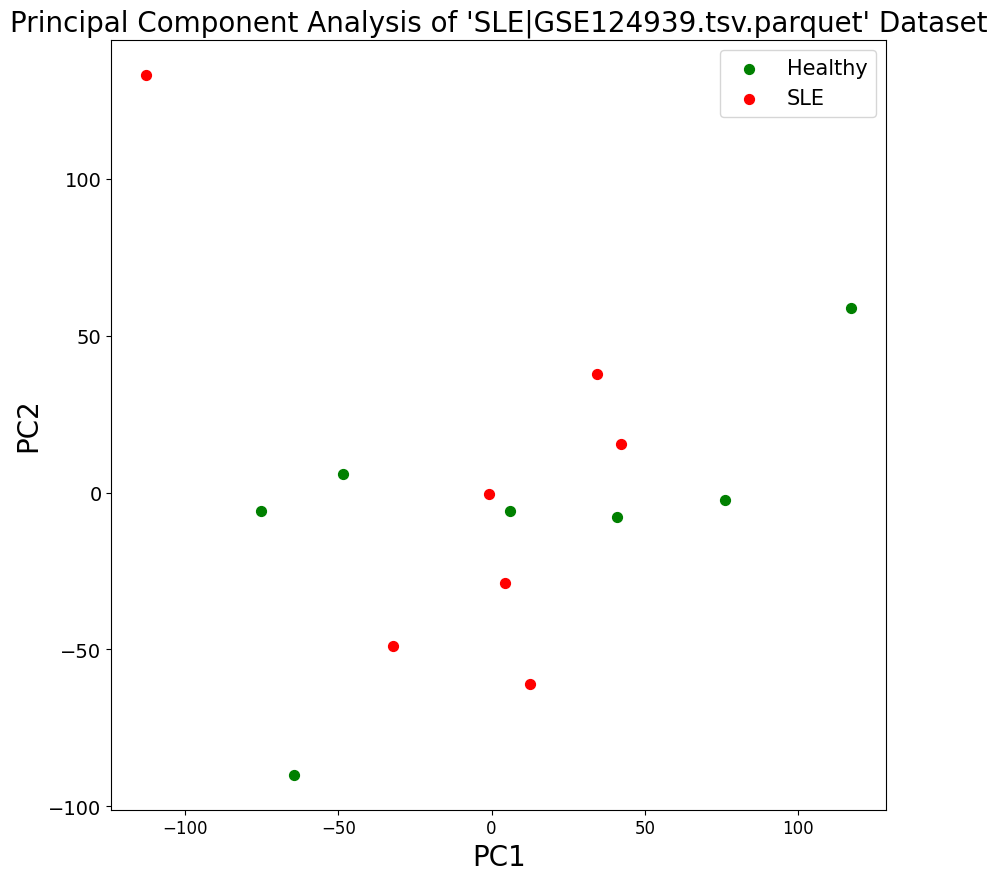

<Figure size 640x480 with 0 Axes>

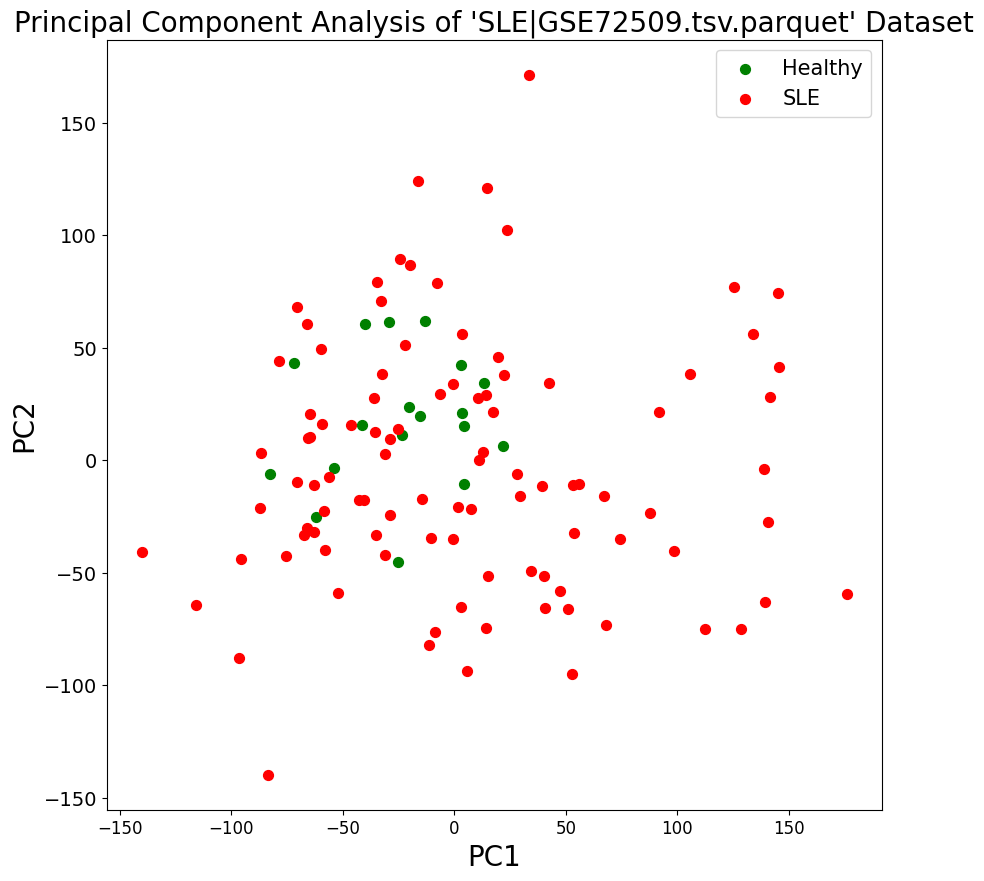

<Figure size 640x480 with 0 Axes>

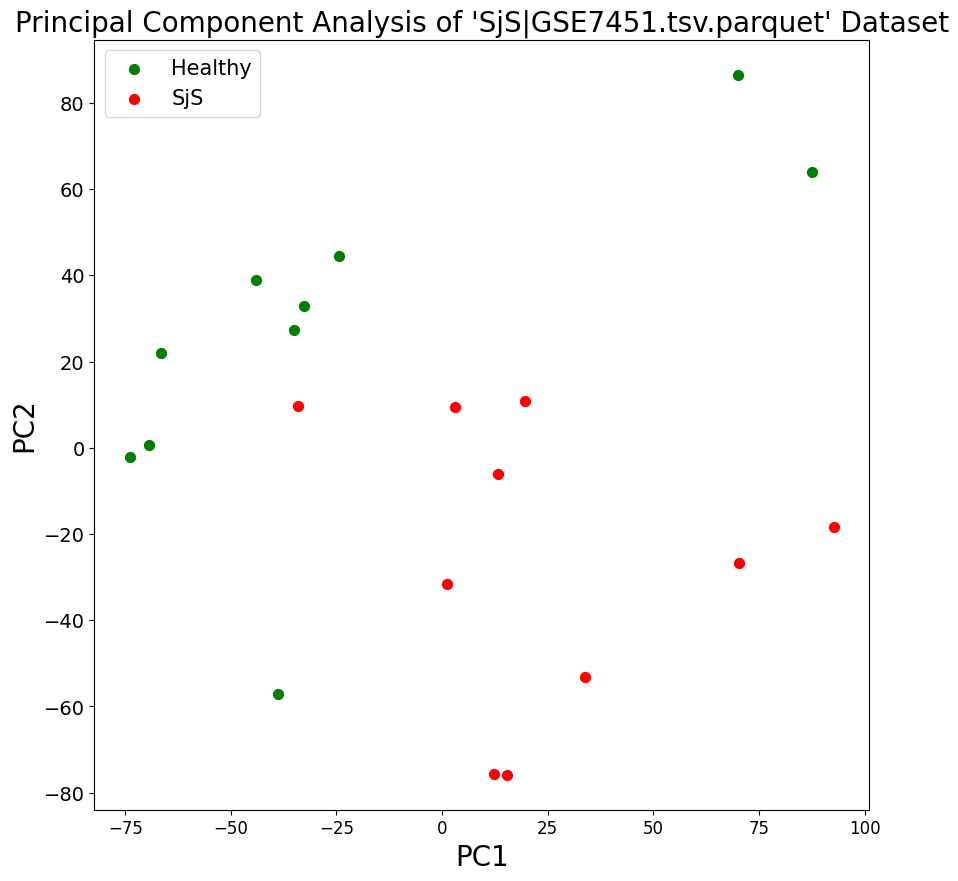

<Figure size 640x480 with 0 Axes>

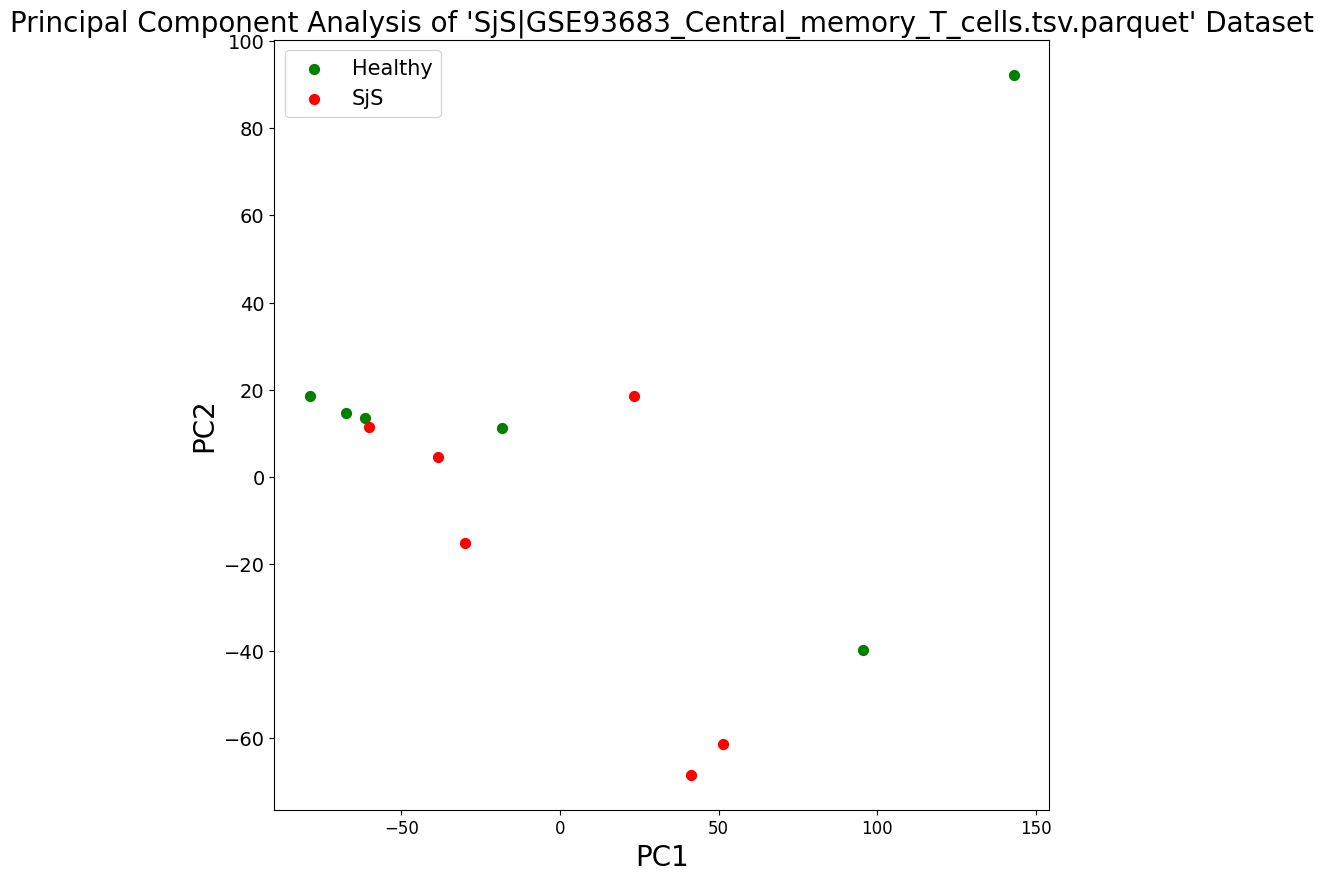

<Figure size 640x480 with 0 Axes>

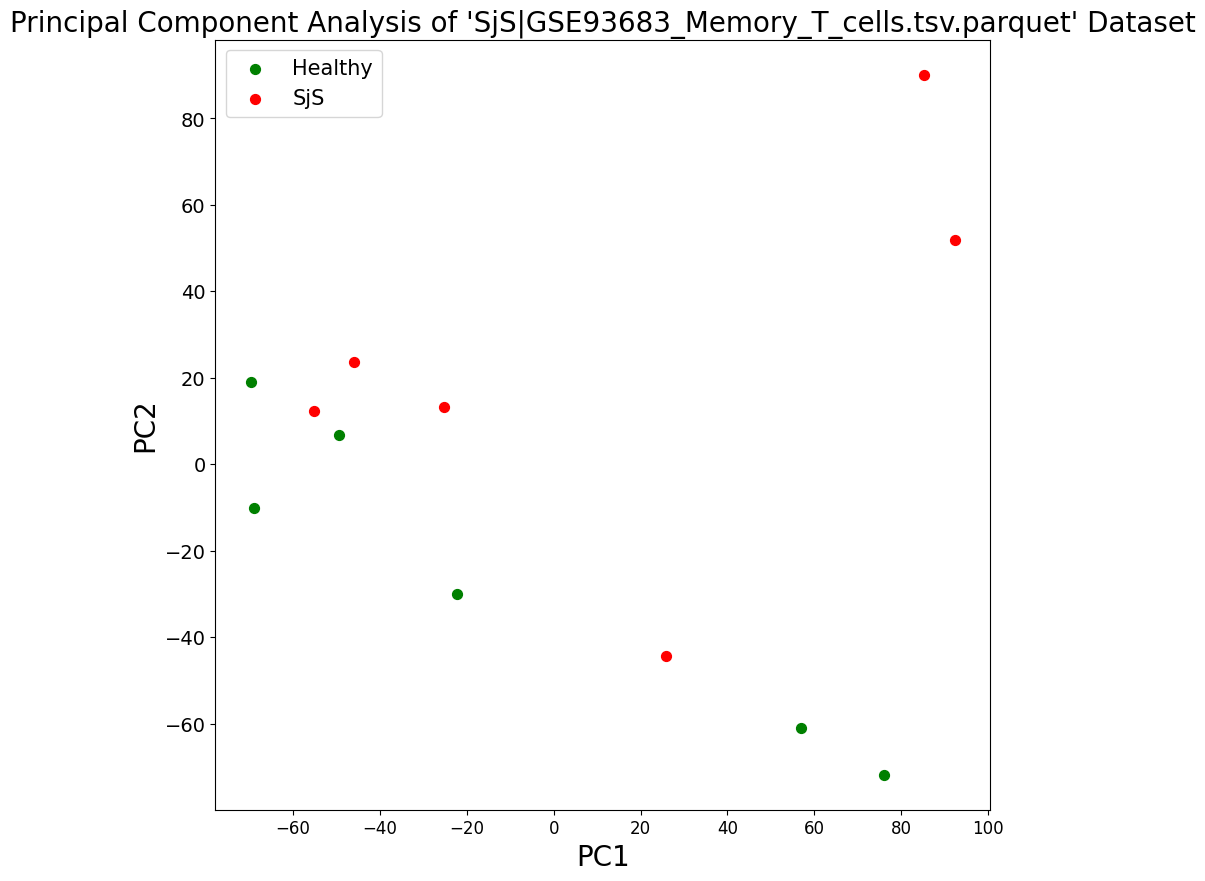

<Figure size 640x480 with 0 Axes>

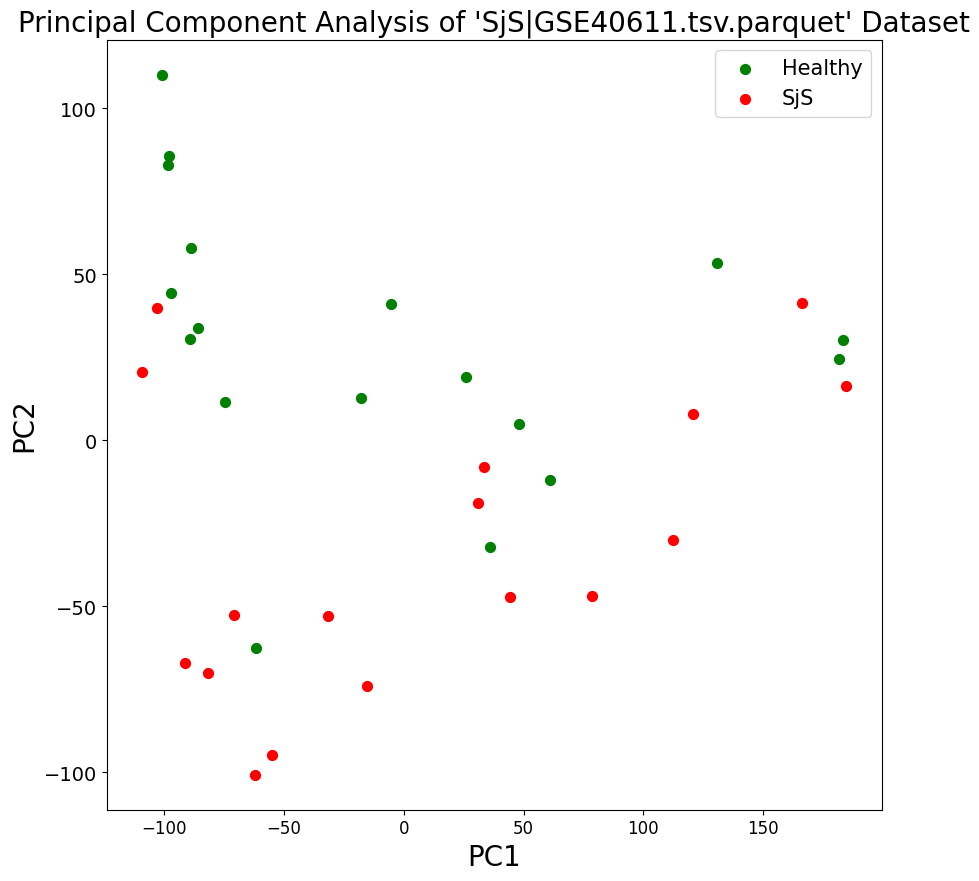

<Figure size 640x480 with 0 Axes>

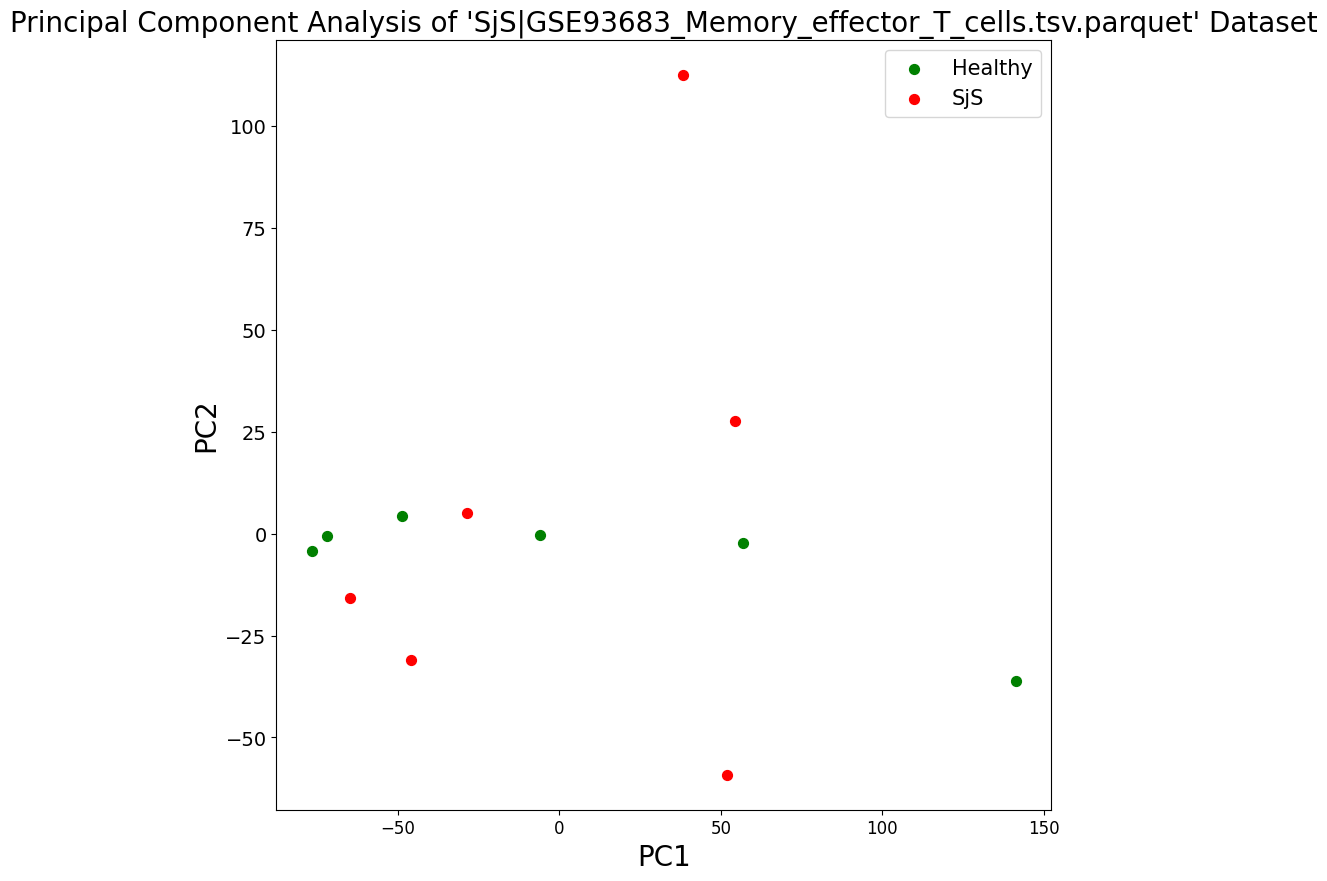

<Figure size 640x480 with 0 Axes>

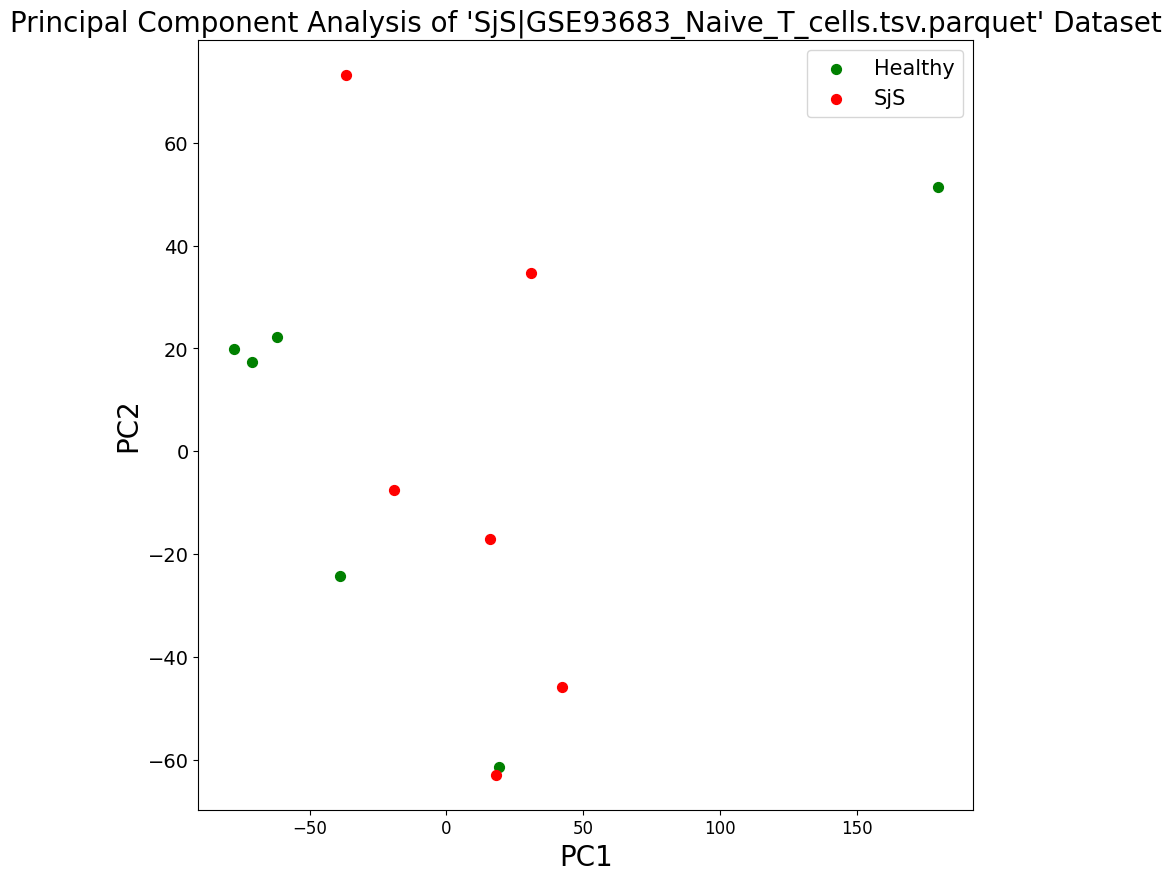

<Figure size 640x480 with 0 Axes>

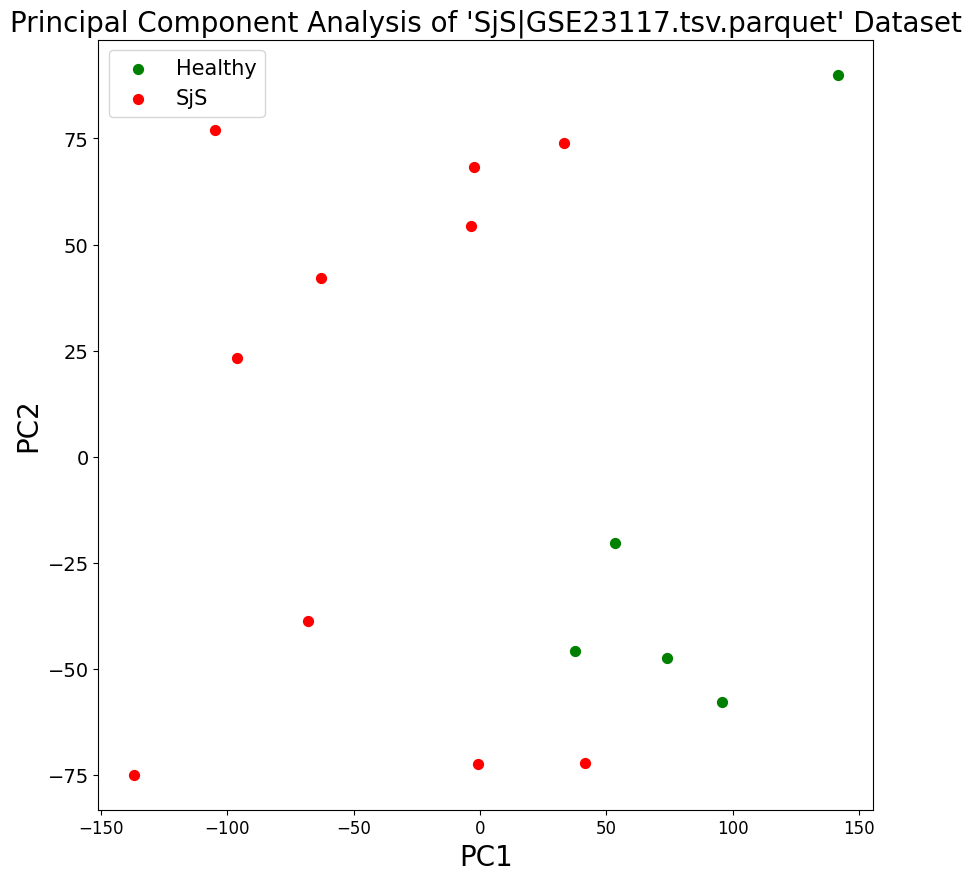

<Figure size 640x480 with 0 Axes>

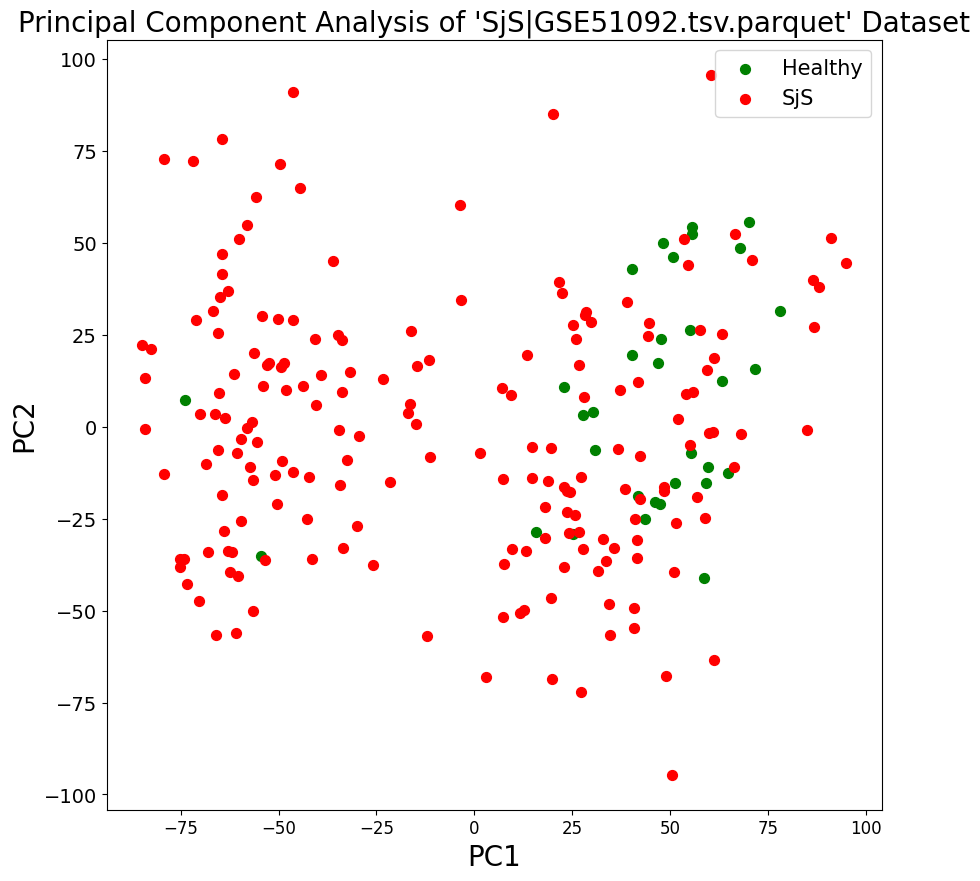

<Figure size 640x480 with 0 Axes>

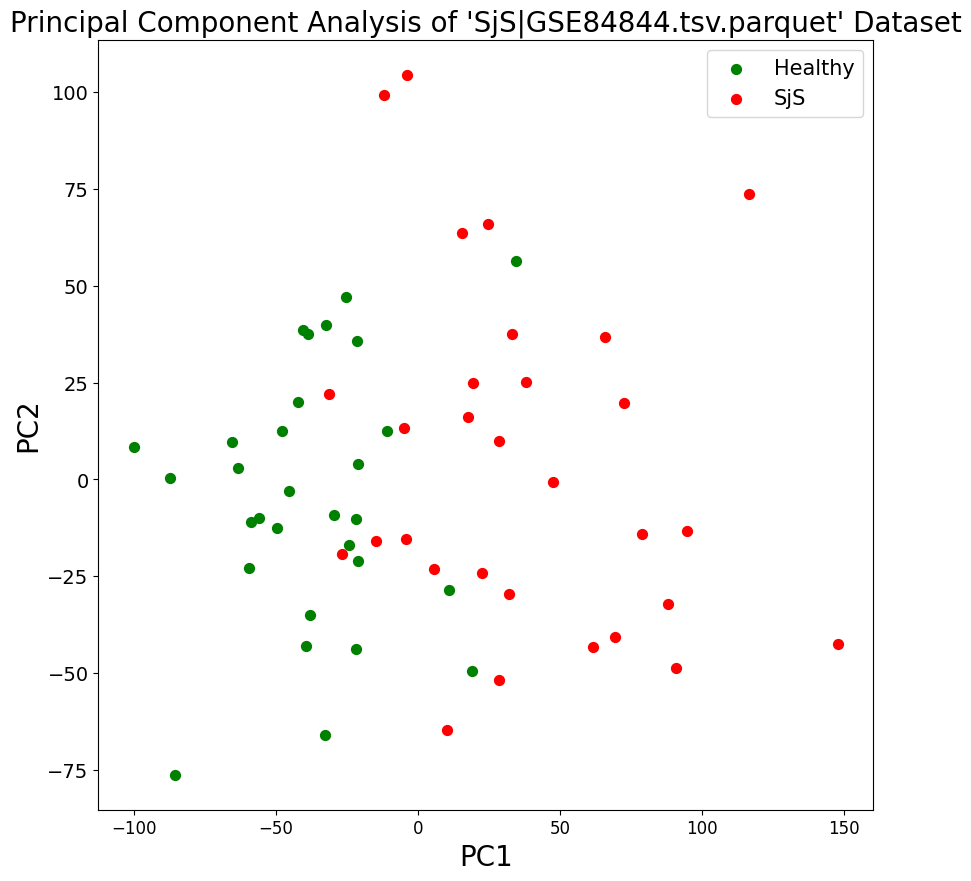

In [21]:
for condition in Condition:
    for file_path in Path(f"{files_path}/{condition.name}").glob('*.parquet'):
        file = os.path.basename(file_path)
        logging.info(f"Processing file: {file}")
        
        pca = PcaHelper(FileDataLoader(condition, file_name=file), files_path, metadata_path, datasets_info_path)
        pca.draw(
            column_that_defines_colors="Condition",
            target_colors=[
                ("Healthy", "g"),
                (condition.name, "r")
            ]
        )